# Predicción del **precio de la luz** (2024–2025) 


**Objetivo:** Pipeline reproducible *end-to-end* con datos Parquet (precio de la luz y REE: almacenamiento, demanda, emisión, generación) para predecir el precio horario.

## Índice
1. **Configuración y dependencias**
2. **Carga de datos (Parquet)**
3. **Exploración inicial (EDA)**
4. **Preprocesamiento**
5. **Partición temporal**
6. **Baselines** (naive, seasonal naive, media móvil)
7. **Modelos clásicos**: SARIMAX (estacional) y XGBoost (o HGBR)
8. **Redes recurrentes**: LSTM y GRU
9. **Comparación y selección**
10. **Guardado de artefactos**
11. **Conclusiones y próximos pasos**
12. **Anexos (funciones utilitarias)**


# 1. Configuración y dependencias

En este bloque importamos las librerías necesarias, fijamos semillas para
reproducibilidad y definimos la ruta base de los datasets (la carpeta **datasets**
que aparece en tu captura). Si tu ruta es distinta, cambia `DATA_DIR`.


In [5]:
# =========================
# 1. Configuración y dependencias
# =========================
import os
import random
import numpy as np
import pandas as pd

# Lectura Parquet con pyarrow
import pyarrow as pa
import pyarrow.parquet as pq

# Gráficos y display
import matplotlib.pyplot as plt

# ---- Reproducibilidad (semillas)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ---- Ruta base de datos (AJUSTAR SI ES NECESARIO)
# En tu proyecto, la carpeta se llama "datasets" tal y como se ve en la imagen.
DATA_DIR = "datasets"

# Archivos de precios (AJUSTAR si cambian los nombres)
PRICE_FILES = [
    "precios_luz_2024.parquet",
    "precios_luz_2025.parquet",
]

# Comprobación rápida de existencia
for f in PRICE_FILES:
    full = os.path.join(DATA_DIR, f)
    print(f"[Check] {full} -> {'OK' if os.path.exists(full) else 'NO ENCONTRADO'}")


[Check] datasets/precios_luz_2024.parquet -> OK
[Check] datasets/precios_luz_2025.parquet -> OK


# 2. Carga de datos (Parquet)

### 2.1 Precios de la luz

Primero cargamos los **precios** (2024 y 2025), verificamos columnas y unificamos:
- Creamos una columna temporal estándar `ts_utc` (zona UTC).
- Normalizamos el nombre del objetivo a `price` (p.ej. si viene como `PCB`, `Precio`, etc.).
- Ordenamos por tiempo y eliminamos duplicados exactos.

> Si tus ficheros tienen columnas de fecha/hora diferentes:
> - Ajusta `CANDIDATE_TIME_COLS` si tienes un único timestamp.
> - O usa el bloque de *combinación Día+Hora* si vienen separadas (p. ej., `Dia` y `Hora`).


In [8]:
## 2. Carga de datos (Parquet) — Precios de la luz

In [9]:
# =========================
# 2. Carga de datos — PRECIOS 2024+2025 → df_precios
# =========================
import os
import re
import numpy as np
import pandas as pd

# ---- Dependencias parquet
import pyarrow as pa
import pyarrow.parquet as pq

# ---- Si punto 1 no se ejecutó, definimos defaults seguros
DATA_DIR = globals().get("DATA_DIR", "datasets")
PRICE_FILES = globals().get("PRICE_FILES", ["precios_luz_2024.parquet", "precios_luz_2025.parquet"])

def read_parquet_arrow(path: str) -> pd.DataFrame:
    """Lee un .parquet con pyarrow y devuelve DataFrame pandas sin eliminar columnas."""
    table: pa.Table = pq.read_table(path, use_threads=True)
    return table.to_pandas(types_mapper=pd.ArrowDtype).convert_dtypes()

# 2.1 Leer y concatenar 2024 + 2025
dfs = []
for fname in PRICE_FILES:
    full = os.path.join(DATA_DIR, fname)
    if not os.path.exists(full):
        raise FileNotFoundError(f"No se encontró el archivo: {full}")
    print(f"[Load] {full}")
    dfi = read_parquet_arrow(full)
    print(f"       shape={dfi.shape} | columnas ejemplo={list(dfi.columns)[:10]}")
    dfs.append(dfi)

df_precios = pd.concat(dfs, axis=0, ignore_index=True)
print(f"[Concat] df_precios -> shape={df_precios.shape}")

# 2.2 Construcción/normalización de timestamp (robusta a DST y 24-25)
CANDIDATE_TIME_COLS = ["ts_utc","timestamp_utc","ts","datetime_utc","fecha_hora_utc","date_time","datetime"]
time_col = next((c for c in CANDIDATE_TIME_COLS if c in df_precios.columns), None)

DAY_CANDS  = ["Dia","Día","dia","fecha","Fecha"]
HOUR_CANDS = ["Hora","hora"]

def _hora_inicial_y_offset(hstr):
    """
    Devuelve (hora_inicial, day_offset):
      - '23-24' -> (23, 0)
      - '24-25' -> (0, +1)   # 00:00 del día siguiente
      - '25-26' -> (1, +1)   # por robustez
      - '07' / '07:00' -> (7, 0)
    Si no parsea, (np.nan, 0).
    """
    if pd.isna(hstr):
        return np.nan, 0
    s = str(hstr)
    m = re.search(r"(\d{1,2})", s)
    if not m:
        return np.nan, 0
    h = int(m.group(1))
    if h == 24:
        return 0, 1
    if h == 25:
        return 1, 1
    h = max(0, min(23, h))
    return float(h), 0

if time_col is not None:
    # Ya hay columna temporal → aseguramos UTC
    ts_utc = pd.to_datetime(df_precios[time_col], errors="coerce", utc=True)
else:
    # ---- Parseo robusto Dia + Hora (hora inicial del rango + offset de día) ----
    day_col  = next((c for c in DAY_CANDS  if c in df_precios.columns), None)
    hour_col = next((c for c in HOUR_CANDS if c in df_precios.columns), None)
    if day_col is None or hour_col is None:
        raise ValueError("No se hallaron columnas de fecha/hora. Ajusta DAY_CANDS/HOUR_CANDS.")

    # 1) Fecha (formato español)
    day = pd.to_datetime(df_precios[day_col], errors="coerce", dayfirst=True)

    # 2) Hora inicial + offset de día
    parsed = df_precios[hour_col].map(_hora_inicial_y_offset)
    h_ini = parsed.map(lambda t: t[0]).astype("Float64")
    d_off = parsed.map(lambda t: t[1]).astype("Int64")

    # 3) Día efectivo aplicando offset (para 24-25, 25-26, etc.)
    day_eff = day + pd.to_timedelta(d_off, unit="D")

    # 4) Construimos datetime "naive"
    ts_naive = pd.to_datetime(
        {"year": day_eff.dt.year, "month": day_eff.dt.month, "day": day_eff.dt.day, "hour": h_ini.astype("Int64")},
        errors="coerce"
    )

    # 5) Resolver el fin de DST (octubre) con un vector 'ambiguous':
    #    si hay tiempos locales repetidos, el 1º pase => DST True; el 2º => DST False.
    dup_mask = ts_naive.duplicated(keep=False)
    amb_bool = np.zeros(len(ts_naive), dtype=bool)
    if dup_mask.any():
        idx_dup = np.flatnonzero(dup_mask)
        order_in_group = (
            pd.Series(1, index=idx_dup)
            .groupby(ts_naive.iloc[idx_dup]).cumsum().values
        )
        amb_bool[idx_dup] = order_in_group == 1

    # 6) Localizar a Europe/Madrid y resolver inexistentes (marzo)
    ts_local = ts_naive.dt.tz_localize(
        "Europe/Madrid",
        ambiguous=amb_bool,          # fin de DST (octubre)
        nonexistent="shift_forward"  # inicio de DST (marzo)
    )

    # 7) Convertir a UTC
    ts_utc = ts_local.dt.tz_convert("UTC")

# 2.3 Asignar/usar 'ts_utc' como índice (sin eliminar columnas)
df_precios["ts_utc"] = ts_utc
df_precios = df_precios.set_index("ts_utc").sort_index()

# 2.4 Diagnóstico inicial
n_nat_idx = int(df_precios.index.to_series().isna().sum())
n_dup_idx = int(df_precios.index.duplicated().sum())
print(f"[Diagnóstico] NaT en índice: {n_nat_idx} | duplicados índice: {n_dup_idx}")
print(f"[Rango] inicio={df_precios.index.min()} | fin={df_precios.index.max()} | n={len(df_precios)}")

# 2.5 (Nuevo) Resolver duplicados del índice prefiriendo coherencia local (Europe/Madrid)
if n_dup_idx > 0:
    # Fecha local derivada del índice
    ts_local = df_precios.index.tz_convert("Europe/Madrid")
    fecha_local = pd.Series(ts_local.date, index=df_precios.index)

    # Columna 'Dia' (o 'Día'/'fecha') parseada a date
    if "Dia" in df_precios.columns:
        dia_col = "Dia"
    elif "Día" in df_precios.columns:
        dia_col = "Día"
    else:
        dia_col = "fecha"
    dia_parsed = pd.to_datetime(df_precios[dia_col], errors="coerce", dayfirst=True).dt.date

    # Coherencia: coincide fecha local del índice con la fecha informada en la columna
    coherente = (fecha_local == dia_parsed)

    def _resolver_grupo(g):
        coh = coherente.loc[g.index]
        if coh.sum() == 1:
            return g.loc[coh]
        return g.iloc[[0]]  # estabilidad si empate

    df_precios = (
        df_precios.groupby(level=0, group_keys=False)
                  .apply(_resolver_grupo)
                  .sort_index()
    )

    n_dup_idx2 = int(df_precios.index.duplicated().sum())
    print(f"[Dedup] duplicados antes: {n_dup_idx} | después: {n_dup_idx2}")


[Load] datasets/precios_luz_2024.parquet
       shape=(8784, 59) | columnas ejemplo=['Dia', 'Hora', 'GEN', 'NOC', 'VHC', 'COFGEN', 'COFNOC', 'COFVHC', 'PMHGEN', 'PMHNOC']
[Load] datasets/precios_luz_2025.parquet
       shape=(6335, 59) | columnas ejemplo=['Dia', 'Hora', 'GEN', 'NOC', 'VHC', 'COFGEN', 'COFNOC', 'COFVHC', 'PMHGEN', 'PMHNOC']
[Concat] df_precios -> shape=(15119, 59)
[Diagnóstico] NaT en índice: 0 | duplicados índice: 1
[Rango] inicio=2023-12-31 23:00:00+00:00 | fin=2025-09-21 21:00:00+00:00 | n=15119
[Dedup] duplicados antes: 1 | después: 0


In [10]:
df_precios.head()

,Dia,Hora,GEN,NOC,VHC,COFGEN,COFNOC,COFVHC,PMHGEN,PMHNOC,...,TEUPCB,TEUCYM,CCVPCB,CCVCYM,EDSRPCB,EDSRCYM,EDCGASPCB,EDCGASCYM,TAHPCB,TAHCYM
ts_utc,,,,,,,,,,,,,,,,,,,,,
2023-12-31 23:00:00+00:00,01/01/2024,00-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.21,3.21,0.0,0.0,0.0,0.0,13.73,13.73
2024-01-01 00:00:00+00:00,01/01/2024,01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.02,3.02,0.0,0.0,0.0,0.0,13.79,13.79
2024-01-01 01:00:00+00:00,01/01/2024,02-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.03,3.03,0.0,0.0,0.0,0.0,13.94,13.94
2024-01-01 02:00:00+00:00,01/01/2024,03-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.02,3.02,0.0,0.0,0.0,0.0,14.06,14.06
2024-01-01 03:00:00+00:00,01/01/2024,04-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.04,3.04,0.0,0.0,0.0,0.0,14.15,14.15


In [11]:
df_precios.count()

Dia          15118
Hora         15118
GEN              0
NOC              0
VHC              0
COFGEN           0
COFNOC           0
COFVHC           0
PMHGEN           0
PMHNOC           0
PMHVHC           0
SAHGEN           0
SAHNOC           0
SAHVHC           0
FOMGEN           0
FOMNOC           0
FOMVHC           0
FOSGEN           0
FOSNOC           0
FOSVHC           0
INTGEN           0
INTNOC           0
INTVHC           0
PCAPGEN          0
PCAPNOC          0
PCAPVHC          0
TEUGEN           0
TEUNOC           0
TEUVHC           0
CCVGEN           0
CCVNOC           0
CCVVHC           0
hour         15118
price        15118
PCB          15118
CYM          15118
COF2TD       15118
PMHPCB       15118
PMHCYM       15118
SAHPCB       15118
SAHCYM       15118
FOMPCB       15118
FOMCYM       15118
FOSPCB       15118
FOSCYM       15118
INTPCB       15118
INTCYM       15118
PCAPPCB      15118
PCAPCYM      15118
TEUPCB       15118
TEUCYM       15118
CCVPCB       15118
CCVCYM      

In [12]:
# Valores no nulos
edcgaspcb_no_nulos = df_precios["EDCGASPCB"].dropna()

print(f"Número de valores no nulos: {len(edcgaspcb_no_nulos)}")
print("\nPrimeros 20 valores no nulos:")
display(edcgaspcb_no_nulos.head(-20))

print("\nEstadísticos básicos de los valores no nulos:")
display(edcgaspcb_no_nulos.describe())

# Si quieres ver las filas completas donde EDCGASPCB tiene valor
print("\nFilas completas con valor en EDCGASPCB (primeras 10):")
display(df_precios[df_precios["EDCGASPCB"].notna()].head(-10))


Número de valores no nulos: 2183

Primeros 20 valores no nulos:


ts_utc
2023-12-31 23:00:00+00:00    0.0
2024-01-01 00:00:00+00:00    0.0
2024-01-01 01:00:00+00:00    0.0
2024-01-01 02:00:00+00:00    0.0
2024-01-01 03:00:00+00:00    0.0
                            ... 
2024-03-30 21:00:00+00:00    0.0
2024-03-30 22:00:00+00:00    0.0
2024-03-30 23:00:00+00:00    0.0
2024-03-31 00:00:00+00:00    0.0
2024-03-31 01:00:00+00:00    0.0
Name: EDCGASPCB, Length: 2163, dtype: Float64


Estadísticos básicos de los valores no nulos:


count    2183.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: EDCGASPCB, dtype: Float64


Filas completas con valor en EDCGASPCB (primeras 10):


,Dia,Hora,GEN,NOC,VHC,COFGEN,COFNOC,COFVHC,PMHGEN,PMHNOC,...,TEUPCB,TEUCYM,CCVPCB,CCVCYM,EDSRPCB,EDSRCYM,EDCGASPCB,EDCGASCYM,TAHPCB,TAHCYM
ts_utc,,,,,,,,,,,,,,,,,,,,,
2023-12-31 23:00:00+00:00,01/01/2024,00-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.21,3.21,0.0,0.0,0.0,0.0,13.73,13.73
2024-01-01 00:00:00+00:00,01/01/2024,01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.02,3.02,0.0,0.0,0.0,0.0,13.79,13.79
2024-01-01 01:00:00+00:00,01/01/2024,02-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.03,3.03,0.0,0.0,0.0,0.0,13.94,13.94
2024-01-01 02:00:00+00:00,01/01/2024,03-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.02,3.02,0.0,0.0,0.0,0.0,14.06,14.06
2024-01-01 03:00:00+00:00,01/01/2024,04-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,3.04,3.04,0.0,0.0,0.0,0.0,14.15,14.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 07:00:00+00:00,31/03/2024,09-10,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,2.63,2.63,0.0,0.0,0.0,0.0,25.12,25.12
2024-03-31 08:00:00+00:00,31/03/2024,10-11,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,2.54,2.54,0.0,0.0,0.0,0.0,24.68,24.68
2024-03-31 09:00:00+00:00,31/03/2024,11-12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,2.75,2.75,2.51,2.51,0.0,0.0,0.0,0.0,24.43,24.43


Explicación nombres de los campos:

Campos básicos

Dia: fecha del día (formato dd/mm/aaaa).

Hora: franja horaria (p. ej., 00-01, 01-02…).

hour: hora en entero (0–23), a veces derivada de Hora.

price: precio PVPC final/hora (según modalidad base del fichero).

source_file: nombre del fichero de origen (útil para trazabilidad).
Modalidades PVPC (pre-2021 y legadas)

GEN: modalidad General (antigua 2.0A).

NOC: Nocturna o con discriminación horaria (antigua 2.0DHA).

VHC: Vehículo eléctrico (antigua 2.0DHS).

Verás muchos componentes repetidos con sufijos GEN/NOC/VHC: significan “ese componente calculado para esa modalidad”.

Componentes (familias más comunes)

Mercado y balances

PMH*: Precio marginal horario del mercado (energía del mercado mayorista de la hora h). Base del término de energía.

SAH*: Servicios de ajuste imputados a la hora h (secundaria, terciaria, balance, etc.).

INT*: coste del Servicio de interrumpibilidad (histórico, vigente en años antiguos).

Operadores

FOM*: coste del Operador del Mercado (OMIE) imputado a la hora. (Definido en la metodología del PVPC como “costes de operación del mercado”).

FOS*: coste del Operador del Sistema (REE) imputado a la hora (“costes de operación del sistema”).

Otros regulados

PCAP*: Pagos por capacidad imputados a la energía horaria.

TEU*: Término de energía de peajes/cargos por kWh (el componente regulado que se suma al PMH y ajustes; su desglose exacto depende del año/regulación).

CCV*: Coste de comercialización variable (€/kWh) del PVPC definido en la regulación del PVPC.

En las columnas anteriores, el “*” suele ir seguido de GEN/NOC/VHC (años antiguos) o de PCB/CYM (años recientes), según el fichero.

Sufijos geográficos (desde la nueva fórmula 2024+)

…PCB: valores para Península, Canarias y Baleares.

…CYM: valores para Ceuta y Melilla. (Estos sufijos aparecen en claves como PMHPCB, SAHCYM, TEUPCB, CCVCYM…) studylib.es

A partir del 1-jun-2021 desaparecen las modalidades PVPC “GEN / NOC / VHC”. Para los pequeños consumidores se unifican en un único peaje 2.0TD con tres periodos horarios de energía (P1 punta, P2 llano, P3 valle) y dos periodos de potencia, sustituyendo a 2.0A/2.0DHA/2.0DHS.  

Eliminamo la columna EDCGASPCB por no tener valores diferentes a nulos y 0.0

De manera que borraremos todas las columnas con sufijos GEN/NOC/VHC. Como nos vamos a centrar en la Península, Canarias y Baleares. Vamos a eliminar los valores de Ceuta y Melilla (*CYM)

In [15]:
# ============================================================
# 2.1 Limpieza de columnas:
# - Eliminar modalidades PVPC antiguas con sufijos GEN / NOC / VHC
# - Eliminar Ceuta y Melilla (…CYM) y conservar …PCB
# - Eliminar explícitamente la columna EDCGASPCB
# ============================================================

import re

cols = df_precios.columns.astype(str)

# 1) Columnas legacy PVPC (terminan en GEN / NOC / VHC)
pat_legacy = re.compile(r'(GEN|NOC|VHC)$')
drop_legacy = [c for c in cols if pat_legacy.search(c)]

# 2) Columnas de Ceuta y Melilla (…CYM)
drop_cym = [c for c in cols if c.endswith("CYM")]

# 3) Columna a eliminar explícitamente
drop_explicit = ["EDCGASPCB"]

# Conjunto final a eliminar
cols_drop = sorted(set(drop_legacy + drop_cym + drop_explicit))

print(f"[Limpieza] columnas a eliminar: {len(cols_drop)}")
print(cols_drop[:30], "..." if len(cols_drop) > 30 else "")

df_precios = df_precios.drop(columns=cols_drop, errors="ignore")

print(f"[Resultado] columnas finales: {df_precios.shape[1]}")
print("Ejemplo de columnas:", list(df_precios.columns[:15]))


[Limpieza] columnas a eliminar: 43
['CCVCYM', 'CCVGEN', 'CCVNOC', 'CCVVHC', 'COFGEN', 'COFNOC', 'COFVHC', 'CYM', 'EDCGASCYM', 'EDCGASPCB', 'EDSRCYM', 'FOMCYM', 'FOMGEN', 'FOMNOC', 'FOMVHC', 'FOSCYM', 'FOSGEN', 'FOSNOC', 'FOSVHC', 'GEN', 'INTCYM', 'INTGEN', 'INTNOC', 'INTVHC', 'NOC', 'PCAPCYM', 'PCAPGEN', 'PCAPNOC', 'PCAPVHC', 'PMHCYM'] ...
[Resultado] columnas finales: 16
Ejemplo de columnas: ['Dia', 'Hora', 'hour', 'price', 'PCB', 'COF2TD', 'PMHPCB', 'SAHPCB', 'FOMPCB', 'FOSPCB', 'INTPCB', 'PCAPPCB', 'TEUPCB', 'CCVPCB', 'EDSRPCB']


In [16]:
# ============================================================
# Diagnóstico de duplicados y nulos en df_precios
# ============================================================

# --- 1) Duplicados por índice (timestamps repetidos)
dup_idx_mask = df_precios.index.duplicated(keep=False)
n_dup_idx = int(dup_idx_mask.sum())
print(f"[Índice] timestamps duplicados: {n_dup_idx}")

if n_dup_idx > 0:
    print("Primeros 10 duplicados por índice:")
    display(df_precios.loc[dup_idx_mask].head(10))

# --- 2) Filas con índice NaT
n_nat_idx = int(df_precios.index.to_series().isna().sum())
print(f"[Índice] filas con índice NaT: {n_nat_idx}")
if n_nat_idx > 0:
    print("Primeras 10 filas con índice NaT:")
    display(df_precios[df_precios.index.to_series().isna()].head(10))

# --- 3) Valores nulos por columna
nulos_col = df_precios.isna().sum()
print("\n[Nulos por columna] (top 20):")
display(nulos_col.sort_values(ascending=False).head(20))

# --- 4) Porcentaje de nulos por columna (opcional)
pct_nulos = (df_precios.isna().mean() * 100).sort_values(ascending=False)
print("\n[Porcentaje de nulos por columna] (top 20):")
display(pct_nulos.head(20))

# --- 5) Filas completas con algún nulo (opcional)
n_filas_con_nulos = int(df_precios.isna().any(axis=1).sum())
print(f"\n[Filas con al menos un nulo]: {n_filas_con_nulos}")


[Índice] timestamps duplicados: 0
[Índice] filas con índice NaT: 0

[Nulos por columna] (top 20):


Dia        0
Hora       0
hour       0
price      0
PCB        0
COF2TD     0
PMHPCB     0
SAHPCB     0
FOMPCB     0
FOSPCB     0
INTPCB     0
PCAPPCB    0
TEUPCB     0
CCVPCB     0
EDSRPCB    0
TAHPCB     0
dtype: int64


[Porcentaje de nulos por columna] (top 20):


Dia        0.0
Hora       0.0
hour       0.0
price      0.0
PCB        0.0
COF2TD     0.0
PMHPCB     0.0
SAHPCB     0.0
FOMPCB     0.0
FOSPCB     0.0
INTPCB     0.0
PCAPPCB    0.0
TEUPCB     0.0
CCVPCB     0.0
EDSRPCB    0.0
TAHPCB     0.0
dtype: float64


[Filas con al menos un nulo]: 0


In [17]:
df_precios.count()

Dia        15118
Hora       15118
hour       15118
price      15118
PCB        15118
COF2TD     15118
PMHPCB     15118
SAHPCB     15118
FOMPCB     15118
FOSPCB     15118
INTPCB     15118
PCAPPCB    15118
TEUPCB     15118
CCVPCB     15118
EDSRPCB    15118
TAHPCB     15118
dtype: int64

In [18]:
# ============================================================
# Guardar df_precios a Parquet (con índice tz-aware)
# ============================================================
import os

# Carpeta y nombre de salida (ajusta si quieres otra ruta)
OUT_DIR = DATA_DIR  # usa la misma carpeta "datasets"
OUT_FILE = "df_precios_2024_2025.parquet"
OUT_PATH = os.path.join(OUT_DIR, OUT_FILE)

# Escribimos con pyarrow; compresión snappy (rápida y estándar)
df_precios.to_parquet(
    OUT_PATH,
    engine="pyarrow",
    index=True,          # guarda el índice ts_utc
    compression="snappy"
)
print(f"[OK] Guardado: {OUT_PATH} | filas={len(df_precios)} | cols={df_precios.shape[1]}")

# ---- Verificación rápida: leer y comprobar
df_check = pd.read_parquet(OUT_PATH, engine="pyarrow")
print("[Check] leído:", df_check.shape, "| índice tz:", df_check.index.tz)
print(df_check.head(3))


[OK] Guardado: datasets/df_precios_2024_2025.parquet | filas=15118 | cols=16
[Check] leído: (15118, 16) | índice tz: UTC
                                  Dia   Hora hour   price     PCB    COF2TD  \
ts_utc                                                                        
2023-12-31 23:00:00+00:00  01/01/2024  00-01   00  123.83  123.83   0.00012   
2024-01-01 00:00:00+00:00  01/01/2024  01-02   01  111.11  111.11  0.000105   
2024-01-01 01:00:00+00:00  01/01/2024  02-03   02  110.77  110.77   0.00009   

                           PMHPCB  SAHPCB  FOMPCB  FOSPCB  INTPCB  PCAPPCB  \
ts_utc                                                                       
2023-12-31 23:00:00+00:00   77.57   26.31    0.05    0.22     0.0      0.0   
2024-01-01 00:00:00+00:00   61.84   29.45    0.05    0.22     0.0      0.0   
2024-01-01 01:00:00+00:00   58.98    31.8    0.05    0.22     0.0      0.0   

                           TEUPCB  CCVPCB  EDSRPCB  TAHPCB  
ts_utc                         

## 2.2 Carga de datos (Parquet) — REE (demanda, generación, emisiones, almacenamiento)

**Objetivo:** dejar los cuatro datasets de REE listos, con un índice temporal estándar y un dataset horario unificado (sin mezclarlos aún con precios).

**Lectura 2024+2025 por separado**
- Se cargan `ree_demanda_20{24,25}.parquet`, `ree_generacion_20{24,25}.parquet`, `ree_emision_20{24,25}.parquet`, `ree_almacenamiento_20{24,25}.parquet`.
- No se eliminan columnas ni se cambian tipos.

**Construcción de tiempo (`ts_utc`) y manejo de DST**
- Caso A (lo que traen estos REE): columna única `Hora` con fecha-hora local -> se asume `Europe/Madrid`.
  - Se localiza con vector `ambiguous` para resolver el **fin del DST** (dos veces 02:00 en octubre; el 1.º pase se marca como verano).
  - Para el **inicio del DST** (marzo) se usa `nonexistent="shift_forward"`.
  - Después se convierte a **UTC** y se fija como **índice**.
- Caso B (si apareciera algún REE con `Dia`+`Hora`): se reinterpreta `24-25` como **00:00 del día siguiente** y se aplica el mismo tratamiento de DST.  
**Resultado:** índices monotónicos, sin NaT ni duplicados.

**Guardados intermedios (5 minutos)**
- `datasets/df_demanda_2024_2025.parquet`
- `datasets/df_generacion_2024_2025.parquet`
- `datasets/df_emision_2024_2025.parquet`
- `datasets/df_almacenamiento_2024_2025.parquet`

**Unificación REE a 1 hora (sin precios)**
- Cada tabla (5’) se **agrega a 1 h por media**: `resample('h').mean(numeric_only=True)`.
- Se **normalizan nombres** (tildes/espacios) y se añaden **prefijos** para evitar colisiones: `dem_*`, `gen_*`, `emis_*`, `alm_*`.
- Outer join horario entre los cuatro bloques y guardado: `datasets/df_ree_hourly.parquet` (≈ 15 095 horas; REE llega hasta 2025-09-20 21:55 UTC).

**Alineación al calendario horario de precios (sin fusionar)**
- Se **alinea** el REE horario al índice de `df_precios` (15 118 horas) **sin mezclar columnas**.
  - Calendario ancla: `df_precios.index` (UTC).
  - **Salida final:** `df_ree` con **15 118 filas** y **81 columnas**.

**Normalización de nombres de columnas (aplicada y guardada)**
- Se **corrigen mojibake** (p. ej., `tï¿½rmica` -> `termica`), se **eliminan acentos** (é->e, ó->o, ñ->n), y se **sustituyen espacios y “/” por `_`**.
- Se **convierten todos los nombres a minúsculas** y se garantiza **unicidad** si hay colisiones.
- Se guarda un **mapeo** de originales->normalizados en `datasets/df_ree_columns_mapping.json`.
- El parquet final **`datasets/df_ree.parquet`** ya queda con **los nombres normalizados** e índice `ts_utc` en UTC.

**Efectos esperados**
- Las **últimas 24 h** (día 2025-09-21) quedan con **NaN** porque REE no llega a esa fecha.
- Algunas series (p. ej., baterías) **empiezan más tarde** -> menor cobertura (NaN iniciales).

> Se usa `resample('h')` (minúscula) para evitar deprecations. No se ha realizado aún **imputación**; los NaN se mantienen para decidir su tratamiento en *Preprocesado* (Punto 4).


In [20]:
# ============================================================
# Loader parametrizado para REE (demanda / generacion / emision / almacenamiento)
# - Soporta dos esquemas:
#   A) Columna única de fecha-hora (p.ej. 'Hora')
#   B) Pareja Dia + Hora (con rangos 23-24, 24-25, DST)
# - Construye índice ts_utc (UTC) y guarda parquet
# - No elimina columnas
# ============================================================
import os, re, numpy as np, pandas as pd
import pyarrow.parquet as pq

DATA_DIR = globals().get("DATA_DIR", "datasets")

DAY_CANDS   = ["Dia","Día","dia","fecha","Fecha"]
HORA_CANDS  = ["Hora","hora","Datetime","datetime","ts","timestamp","date_time"]

def _read_parquet(path: str) -> pd.DataFrame:
    # Lectura robusta (sin ArrowDtype especial)
    return pd.read_parquet(path, engine="pyarrow")

# ---------- Utilidades de tiempo ----------
def _hora_inicial_y_offset(hstr):
    """
    Devuelve (hora_inicial, day_offset) desde 'Hora':
      '23-24' -> (23, 0)
      '24-25' -> (0, +1)   # 00:00 del día siguiente
      '25-26' -> (1, +1)
      '07'/'07:00' -> (7, 0)
      si no parsea -> (nan, 0)
    """
    if pd.isna(hstr): 
        return np.nan, 0
    m = re.search(r"(\d{1,2})", str(hstr))
    if not m: 
        return np.nan, 0
    h = int(m.group(1))
    if h == 24: return 0, 1
    if h == 25: return 1, 1
    return float(max(0, min(23, h))), 0

def _to_utc_from_single_ts(series_ts: pd.Series) -> pd.Series:
    """Convierte una serie de fechas/horas a UTC:
       - si vienen con tz → .dt.tz_convert('UTC')
       - si son naive → se asumen Europe/Madrid y se convierten a UTC
    """
    ts = pd.to_datetime(series_ts, errors="coerce")  # NO utc=True (podría ser local)
    if getattr(ts.dt, "tz", None) is None:
        # Localizamos como Europe/Madrid resolviendo saltos
        ts_local = ts.dt.tz_localize("Europe/Madrid",
                                     nonexistent="shift_forward",
                                     ambiguous="infer")
        return ts_local.dt.tz_convert("UTC")
    else:
        return ts.dt.tz_convert("UTC")

def _to_utc_from_single_ts(series_ts: pd.Series) -> pd.Series:
    """
    Convierte una serie de fechas/horas locales a UTC resolviendo el fin de DST:
    - Si vienen con tz -> convertir directamente.
    - Si son naive -> asumimos Europe/Madrid y construimos un vector 'ambiguous'
      donde, para timestamps locales repetidos, el 1º pase se marca True (DST).
    """
    ts = pd.to_datetime(series_ts, errors="coerce")  # puede venir naive
    # Si ya trae zona horaria, convertir sin más
    if getattr(ts.dt, "tz", None) is not None:
        return ts.dt.tz_convert("UTC")

    # --- Caso naive: construir 'ambiguous' por duplicados locales (fin de DST) ---
    ts_naive = ts  # sin tz
    dup_mask = ts_naive.duplicated(keep=False)
    amb_bool = np.zeros(len(ts_naive), dtype=bool)  # por defecto False (invierno o no ambiguo)
    if dup_mask.any():
        idx_dup = np.flatnonzero(dup_mask)
        # orden dentro de cada grupo de timestamps duplicados
        order = (
            pd.Series(1, index=idx_dup)
              .groupby(ts_naive.iloc[idx_dup]).cumsum().values
        )
        # primer pase -> True (horario de verano)
        amb_bool[idx_dup] = (order == 1)

    ts_local = ts_naive.dt.tz_localize(
        "Europe/Madrid",
        ambiguous=amb_bool,          # resuelve 02:00 repetida en octubre
        nonexistent="shift_forward"  # resuelve salto de marzo
    )
    return ts_local.dt.tz_convert("UTC")


def _build_ts_utc(df: pd.DataFrame) -> tuple[pd.Series, str]:
    """Detecta el esquema y devuelve (ts_utc, modo_detectado)."""
    # Caso A: columna única de fecha-hora
    single = next((c for c in HORA_CANDS if c in df.columns), None)
    has_day = any(c in df.columns for c in DAY_CANDS)

    if single is not None and not has_day:
        ts_utc = _to_utc_from_single_ts(df[single])
        return ts_utc, f"single_datetime[{single}]"

    # Caso B: Dia + Hora
    day_col  = next((c for c in DAY_CANDS  if c in df.columns), None)
    hour_col = next((c for c in HORA_CANDS if c in df.columns), None)
    if day_col is not None and hour_col is not None:
        ts_utc = _to_utc_from_dia_hora(df, day_col, hour_col)
        return ts_utc, f"dia+hora[{day_col}+{hour_col}]"

    raise ValueError("No se halló ni columna fecha-hora única ni pareja Dia+Hora.")

# ---------- Pipeline principal ----------
def preparar_ree_dataset(nombre: str, archivos: list[str], out_filename: str | None = None) -> pd.DataFrame:
    """
    nombre: etiqueta ('demanda','generacion','emision','almacenamiento')
    archivos: lista ['ree_xxx_2024.parquet','ree_xxx_2025.parquet']
    out_filename: nombre parquet de salida
    """
    print(f"\n=== Preparando REE {nombre} ===")
    dfs = []
    for f in archivos:
        full = os.path.join(DATA_DIR, f)
        if not os.path.exists(full):
            raise FileNotFoundError(f"No se encontró: {full}")
        print(f"[Load] {full}")
        dfi = _read_parquet(full)
        print(f"       shape={dfi.shape} | cols ejemplo={list(dfi.columns)[:10]}")
        dfs.append(dfi)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    print(f"[Concat] df_{nombre} -> {df.shape}")

    # ts_utc según esquema detectado
    ts_utc, modo = _build_ts_utc(df)
    print(f"[Tiempo] modo detectado: {modo}")
    df["ts_utc"] = ts_utc

    # Índice temporal
    df = df.set_index("ts_utc").sort_index()

    # Diagnóstico
    n_nat = int(df.index.to_series().isna().sum())
    n_dup = int(df.index.duplicated().sum())
    print(f"[Diagnóstico] NaT en índice: {n_nat} | duplicados índice: {n_dup}")
    print(f"[Rango] {df.index.min()} → {df.index.max()} | n={len(df)}")

    # Resolver duplicados por coherencia local (igual que en precios)
    if n_dup > 0:
        ts_local = df.index.tz_convert("Europe/Madrid")
        fecha_local = pd.Series(ts_local.date, index=df.index)
        # Intentamos encontrar la columna de fecha original (si existe)
        if "Dia" in df.columns: dia_col = "Dia"
        elif "Día" in df.columns: dia_col = "Día"
        elif "fecha" in df.columns: dia_col = "fecha"
        else: dia_col = None

        if dia_col is not None:
            dia_parsed = pd.to_datetime(df[dia_col], errors="coerce", dayfirst=True).dt.date
            coherente = (fecha_local == dia_parsed)
            def _resolver_grupo(g):
                coh = coherente.loc[g.index]
                if coh.sum() == 1:
                    return g.loc[coh]
                return g.iloc[[0]]
            df = df.groupby(level=0, group_keys=False).apply(_resolver_grupo).sort_index()
            print(f"[Dedup] duplicados después: {int(df.index.duplicated().sum())}")
        else:
            # Si no hay columna de fecha informada, nos quedamos con la primera por timestamp
            df = df[~df.index.duplicated(keep="first")].sort_index()
            print(f"[Dedup] (sin columna 'Dia'): duplicados después: {int(df.index.duplicated().sum())}")

    # Guardar
    if out_filename is None:
        out_filename = f"df_{nombre}_2024_2025.parquet"
    out_path = os.path.join(DATA_DIR, out_filename)
    df.to_parquet(out_path, engine="pyarrow", index=True, compression="snappy")
    print(f"[OK] Guardado df_{nombre} → {out_path} | filas={len(df)} | cols={df.shape[1]}")

    # Verificación rápida
    _check = pd.read_parquet(out_path, engine="pyarrow")
    print("[Check] leído:", _check.shape, "| índice tz:", _check.index.tz)
    return df

# =========================
# Llamadas para cada dataset
# =========================
df_demanda        = preparar_ree_dataset(
    nombre="demanda",
    archivos=["ree_demanda_2024.parquet", "ree_demanda_2025.parquet"],
    out_filename="df_demanda_2024_2025.parquet"
)

df_generacion     = preparar_ree_dataset(
    nombre="generacion",
    archivos=["ree_generacion_2024.parquet", "ree_generacion_2025.parquet"],
    out_filename="df_generacion_2024_2025.parquet"
)

df_emision        = preparar_ree_dataset(
    nombre="emision",
    archivos=["ree_emision_2024.parquet", "ree_emision_2025.parquet"],
    out_filename="df_emision_2024_2025.parquet"
)

df_almacenamiento = preparar_ree_dataset(
    nombre="almacenamiento",
    archivos=["ree_almacenamiento_2024.parquet", "ree_almacenamiento_2025.parquet"],
    out_filename="df_almacenamiento_2024_2025.parquet"
)

print("\n[Resumen] Preparados y guardados: df_demanda, df_generacion, df_emision, df_almacenamiento")



=== Preparando REE demanda ===
[Load] datasets/ree_demanda_2024.parquet
       shape=(105396, 4) | cols ejemplo=['Hora', 'Real', 'Prevista', 'Programada']
[Load] datasets/ree_demanda_2025.parquet
       shape=(75732, 4) | cols ejemplo=['Hora', 'Real', 'Prevista', 'Programada']
[Concat] df_demanda -> (181128, 4)
[Tiempo] modo detectado: single_datetime[Hora]
[Diagnóstico] NaT en índice: 0 | duplicados índice: 0
[Rango] 2023-12-31 23:00:00+00:00 → 2025-09-20 21:55:00+00:00 | n=181128
[OK] Guardado df_demanda → datasets/df_demanda_2024_2025.parquet | filas=181128 | cols=4
[Check] leído: (181128, 4) | índice tz: UTC

=== Preparando REE generacion ===
[Load] datasets/ree_generacion_2024.parquet
       shape=(105396, 42) | cols ejemplo=['Hora', 'Eólica', 'Nuclear', 'Carbón', 'Ciclo combinado', 'Intercambios int', 'Solar fotovoltaica', 'Solar térmica', 'Térmica renovable', 'Motores diésel']
[Load] datasets/ree_generacion_2025.parquet
       shape=(75721, 42) | cols ejemplo=['Hora', 'Eólica',

In [21]:
# ============================================================
# RECONSTRUIR df_ree de forma robusta y ALINEAR a df_precios
# - Limpia nombres de columnas (espacios/acentos raros)
# - Resample a 'h' (sin FutureWarning)
# - LEFT join sobre el calendario de df_precios (evita desalineaciones)
# - Guarda df_ree.parquet
# ============================================================
import os, pandas as pd, unicodedata as ud

DATA_DIR = globals().get("DATA_DIR", "datasets")

def _ensure_df(var_name, parquet_name):
    if var_name in globals():
        return globals()[var_name]
    path = os.path.join(DATA_DIR, parquet_name)
    return pd.read_parquet(path, engine="pyarrow")

def _ensure_utc(df):
    idx = df.index
    if not isinstance(idx, pd.DatetimeIndex):
        raise TypeError("El índice debe ser DatetimeIndex.")
    if idx.tz is None:
        df.index = idx.tz_localize("UTC")
    else:
        df.index = idx.tz_convert("UTC")
    return df.sort_index()

def _clean_cols(df, prefix):
    # normaliza acentos y espacios extra; mantiene mayúsculas/minúsculas
    def _norm(s):
        s = str(s).strip()
        s = ud.normalize("NFKC", s)
        s = " ".join(s.split())  # colapsa espacios
        return f"{prefix}{s}"
    df = df.copy()
    df.columns = [_norm(c) for c in df.columns]
    return df

# 0) Cargar anclas
df_precios = _ensure_df("df_precios", "df_precios_2024_2025.parquet")
df_precios = _ensure_utc(df_precios)

# 1) Cargar los 4 REE 5' y asegurar UTC
df_demanda        = _ensure_df("df_demanda",        "df_demanda_2024_2025.parquet")
df_generacion     = _ensure_df("df_generacion",     "df_generacion_2024_2025.parquet")
df_emision        = _ensure_df("df_emision",        "df_emision_2024_2025.parquet")
df_almacenamiento = _ensure_df("df_almacenamiento", "df_almacenamiento_2024_2025.parquet")

for name in ["df_demanda","df_generacion","df_emision","df_almacenamiento"]:
    globals()[name] = _ensure_utc(globals()[name])

# 2) Agregación HORARIA por media (usar 'h' para evitar FutureWarning)
dem_h  = df_demanda.resample("h").mean(numeric_only=True)
gen_h  = df_generacion.resample("h").mean(numeric_only=True)
emis_h = df_emision.resample("h").mean(numeric_only=True)
alm_h  = df_almacenamiento.resample("h").mean(numeric_only=True)

# 3) Limpiar nombres + prefijos
dem_h  = _clean_cols(dem_h,  "dem_")
gen_h  = _clean_cols(gen_h,  "gen_")
emis_h = _clean_cols(emis_h, "emis_")
alm_h  = _clean_cols(alm_h,  "alm_")

# 4) Calendario de precios como ancla
cal = df_precios.index

# 5) LEFT join estable (evita problemas de reindex si hay micro-desfases)
#    Partimos de un DF vacío con el índice objetivo, y vamos añadiendo bloques.
df_ree = pd.DataFrame(index=cal)
for block in [dem_h, gen_h, emis_h, alm_h]:
    # nos quedamos sólo con las horas que existen exactamente en el calendario
    inter = block.index.intersection(cal)
    df_ree = df_ree.join(block.reindex(inter), how="left")

# 6) Diagnósticos
print(f"[Calendario] precios={len(cal)} | df_ree={len(df_ree)}")
print("[Intersección de horas por bloque]:")
print("  dem  ∩ cal:", len(dem_h.index.intersection(cal)))
print("  gen  ∩ cal:", len(gen_h.index.intersection(cal)))
print("  emis ∩ cal:", len(emis_h.index.intersection(cal)))
print("  alm  ∩ cal:", len(alm_h.index.intersection(cal)))

print("\n[No nulos por bloque] (primeras 10 columnas de cada):")
for label, block in [("dem",dem_h),("gen",gen_h),("emis",emis_h),("alm",alm_h)]:
    sub = [c for c in df_ree.columns if c.startswith(label+"_")][:10]
    if sub:
        nn = df_ree[sub].notna().sum().head(10)
        print(f"  {label}:")
        print(nn)

# 7) Guardar df_ree
OUT_PATH = os.path.join(DATA_DIR, "df_ree.parquet")
df_ree.to_parquet(OUT_PATH, engine="pyarrow", index=True, compression="snappy")
print(f"\n[OK] Guardado df_ree → {OUT_PATH} | filas={len(df_ree)} | cols={df_ree.shape[1]}")

# 8) Verificación rápida
_check = pd.read_parquet(OUT_PATH, engine="pyarrow")
print("[Check] leído:", _check.shape, "| índice tz:", _check.index.tz)


[Calendario] precios=15118 | df_ree=15118
[Intersección de horas por bloque]:
  dem  ∩ cal: 15094
  gen  ∩ cal: 15094
  emis ∩ cal: 15094
  alm  ∩ cal: 15094

[No nulos por bloque] (primeras 10 columnas de cada):
  dem:
dem_Real          15094
dem_Prevista      15094
dem_Programada    15094
dtype: int64
  gen:
gen_Eólica                15094
gen_Nuclear               15094
gen_Carbón                15094
gen_Ciclo combinado       15094
gen_Intercambios int      15094
gen_Solar fotovoltaica    15094
gen_Solar térmica         15094
gen_Térmica renovable     14038
gen_Motores diésel        15094
gen_Turbina de gas        15094
dtype: int64
  emis:
emis_Eólica                15094
emis_Nuclear               15094
emis_Carbón                15094
emis_Ciclo combinado       15094
emis_Intercambios int      15094
emis_Solar fotovoltaica    15094
emis_Solar térmica         15094
emis_Térmica renovable     14038
emis_Motores diésel        15094
emis_Turbina de gas        15094
dtype: int64
  al

In [22]:
df_ree.columns

Index(['dem_Real', 'dem_Prevista', 'dem_Programada', 'gen_Eólica',
       'gen_Nuclear', 'gen_Carbón', 'gen_Ciclo combinado',
       'gen_Intercambios int', 'gen_Solar fotovoltaica', 'gen_Solar térmica',
       'gen_Térmica renovable', 'gen_Motores diésel', 'gen_Turbina de gas',
       'gen_Turbina de vapor', 'gen_Generación auxiliar',
       'gen_Cogeneración y residuos', 'gen_Andorra exportación',
       'gen_Marruecos exportación', 'gen_Portugal exportación',
       'gen_Francia exportación', 'gen_Francia importación',
       'gen_Portugal importación', 'gen_Marruecos importación',
       'gen_Andorra importación', 'gen_Hidráulica', 'gen_Fuel/gas',
       'gen_Enlace balear', 'gen_Eï¿1⁄2lica', 'gen_Carbï¿1⁄2n',
       'gen_Solar tï¿1⁄2rmica', 'gen_Tï¿1⁄2rmica renovable',
       'gen_Cogeneraciï¿1⁄2n y residuos', 'gen_Andorra exportaciï¿1⁄2n',
       'gen_Marruecos exportaciï¿1⁄2n', 'gen_Portugal exportaciï¿1⁄2n',
       'gen_Francia exportaciï¿1⁄2n', 'gen_Francia importaciï¿1⁄2n',
 

In [23]:
# ============================================================
# Normalización de nombres en df_ree (minúsculas + ASCII seguro)
# - Corrige mojibake (ej.: "tï¿1⁄2rmica" -> "termica")
# - Quita acentos: é->e, ó->o, ñ->n, …
# - Sustituye espacios y "/" por "_"
# - Convierte TODO a minúsculas
# - Garantiza unicidad si hubiera colisiones (añade _2, _3, …)
# ============================================================
import os, re, json, unicodedata as ud
import pandas as pd

DATA_DIR = globals().get("DATA_DIR", "datasets")
if "df_ree" not in globals():
    df_ree = pd.read_parquet(os.path.join(DATA_DIR, "df_ree.parquet"), engine="pyarrow")

MOJIBAKE_FIX = {
    # generacion
    "gen_Eï¿1⁄2lica": "gen_Eolica",
    "gen_Carbï¿1⁄2n": "gen_Carbon",
    "gen_Solar tï¿1⁄2rmica": "gen_Solar termica",
    "gen_Tï¿1⁄2rmica renovable": "gen_Termica renovable",
    "gen_Cogeneraciï¿1⁄2n y residuos": "gen_Cogeneracion y residuos",
    "gen_Andorra exportaciï¿1⁄2n": "gen_Andorra exportacion",
    "gen_Marruecos exportaciï¿1⁄2n": "gen_Marruecos exportacion",
    "gen_Portugal exportaciï¿1⁄2n": "gen_Portugal exportacion",
    "gen_Francia exportaciï¿1⁄2n": "gen_Francia exportacion",
    "gen_Francia importaciï¿1⁄2n": "gen_Francia importacion",
    "gen_Portugal importaciï¿1⁄2n": "gen_Portugal importacion",
    "gen_Marruecos importaciï¿1⁄2n": "gen_Marruecos importacion",
    "gen_Andorra importaciï¿1⁄2n": "gen_Andorra importacion",
    "gen_Hidrï¿1⁄2ulica": "gen_Hidraulica",
    "gen_Motores diï¿1⁄2sel": "gen_Motores diesel",
    "gen_Generaciï¿1⁄2n auxiliar": "gen_Generacion auxiliar",
    # por si aparecieran en emisiones
    "emis_Tï¿1⁄2rmica renovable": "emis_Termica renovable",
    "emis_Solar tï¿1⁄2rmica": "emis_Solar termica",
}

def _strip_accents(text: str) -> str:
    return "".join(ch for ch in ud.normalize("NFD", text) if ud.category(ch) != "Mn")

def _normalize_name(name: str) -> str:
    # 1) Fix mojibake exacto si existe
    s = MOJIBAKE_FIX.get(name, name)
    # 2) Quitar acentos
    s = _strip_accents(s)
    # 3) Sustituir separadores y limpiar
    s = s.replace("/", "_")
    s = re.sub(r"\s+", "_", s.strip())      # espacios -> _
    s = re.sub(r"__+", "_", s)
    # 4) Mantener solo ASCII seguro
    s = re.sub(r"[^0-9A-Za-z_]", "", s)
    # 5) Minúsculas
    s = s.lower()
    return s

# Construir mapeo old->new garantizando unicidad
new_cols = []
mapping = {}
seen = set()
for c in map(str, df_ree.columns):
    base = _normalize_name(c)
    cand = base
    k = 1
    while cand in seen:
        k += 1
        cand = f"{base}_{k}"
    seen.add(cand)
    mapping[c] = cand
    new_cols.append(cand)

df_ree = df_ree.rename(columns=mapping)

changes = {k: v for k, v in mapping.items() if k != v}
print(f"[Normalización] columnas renombradas: {len(changes)} / {len(mapping)}")
for i, (k, v) in enumerate(list(changes.items())[:25], 1):
    print(f"{i:2d}. {k}  ->  {v}")
if len(changes) > 25:
    print("...")

# Guardar mapeo y parquet actualizado
with open(os.path.join(DATA_DIR, "df_ree_columns_mapping.json"), "w", encoding="utf-8") as f:
    json.dump(changes, f, ensure_ascii=False, indent=2)

OUT = os.path.join(DATA_DIR, "df_ree.parquet")
df_ree.to_parquet(OUT, engine="pyarrow", index=True, compression="snappy")
print(f"[OK] Guardado df_ree (columnas normalizadas) → {OUT}")


[Normalización] columnas renombradas: 81 / 81
 1. dem_Real  ->  dem_real
 2. dem_Prevista  ->  dem_prevista
 3. dem_Programada  ->  dem_programada
 4. gen_Eólica  ->  gen_eolica
 5. gen_Nuclear  ->  gen_nuclear
 6. gen_Carbón  ->  gen_carbon
 7. gen_Ciclo combinado  ->  gen_ciclo_combinado
 8. gen_Intercambios int  ->  gen_intercambios_int
 9. gen_Solar fotovoltaica  ->  gen_solar_fotovoltaica
10. gen_Solar térmica  ->  gen_solar_termica
11. gen_Térmica renovable  ->  gen_termica_renovable
12. gen_Motores diésel  ->  gen_motores_diesel
13. gen_Turbina de gas  ->  gen_turbina_de_gas
14. gen_Turbina de vapor  ->  gen_turbina_de_vapor
15. gen_Generación auxiliar  ->  gen_generacion_auxiliar
16. gen_Cogeneración y residuos  ->  gen_cogeneracion_y_residuos
17. gen_Andorra exportación  ->  gen_andorra_exportacion
18. gen_Marruecos exportación  ->  gen_marruecos_exportacion
19. gen_Portugal exportación  ->  gen_portugal_exportacion
20. gen_Francia exportación  ->  gen_francia_exportacion
21. 

# 3. Exploración inicial (EDA)


## 3.0 Limpieza de días anómalos (aplicada sobre `df_ree` y `df_precios`)

**Objetivo.** Eliminar del histórico los días que podrían distorsionar el entrenamiento y las métricas: jornadas con fallos de datos (0s o horas faltantes), cambios de hora (25 h), o caídas anómalas de la demanda (p. ej., apagones). La limpieza se aplica **en ambos dataframes** y mantiene sus índices alineados.

---

### Qué hace exactamente

1. **Normaliza el índice temporal a UTC** (sin cambiar los valores), para comparar días correctamente aunque los datos vengan con distintos TZ.
2. **Detecta días problemáticos** usando cuatro detectores complementarios sobre la **suma diaria de generación/demanda**:

   * **IQR diario (robusto)**: marca días con suma diaria muy baja respecto al rango intercuartílico (umbral por defecto `k_iqr=2.5`–`3.0`).
   * **Caída relativa a mediana rodante**: marca días con suma diaria `< (1−drop_pct) × mediana` de los últimos *N* días (por defecto `baseline_window≈21`, `drop_pct≈0.30–0.35`).
   * **Horas por debajo del “baseline” por hora del día**: si un día acumula ≥ *m* horas con valores muy por debajo de la mediana histórica de esa hora (p. ej. `drop_pct≈0.45–0.50`, `min_hours_below≈3–6`), se marca.
   * **Días incompletos o con 0s**: si un día no tiene 24 horas válidas o contiene 0s sospechosos (p. ej., por cortes), se marca.
3. **Lista blanca/negra explícita (forzado)**:

   * Se **fuerza** la eliminación del **28/04/2025** (apagón), aunque no lo detecten los umbrales.
4. **Une todos los días detectados** y **los elimina en ambos `df`** con la misma función (`remove_days`), para conservar la alineación temporal.
5. **Imprime un resumen**: tamaño antes/después, los días detectados por cada método, y un *Top-10* de días con menor suma diaria (útil para auditar).

---



In [26]:
# ============================================================
# 3.0 Limpieza de días anómalos (apagón, días incompletos, caídas fuertes)
#      - Trabaja IN-PLACE: sobrescribe df_ree y df_precios
# ============================================================
import numpy as np, pandas as pd, re

# --- Helpers de índice temporal ---
def _tz_index(idx):
    """Devuelve el índice en UTC (si no tiene tz, lo localiza en UTC)."""
    if idx.tz is None:
        return idx.tz_localize("UTC")
    return idx.tz_convert("UTC")

def remove_days(df, days):
    """
    Elimina por completo las 24h de cada día en 'days' (strings 'YYYY-MM-DD').
    Funciona con índices con o sin tz; todo se alinea en UTC.
    """
    if not days:
        return df
    idx = _tz_index(df.index)
    day_idx = pd.to_datetime(days, utc=True).normalize()
    mask = ~idx.normalize().isin(day_idx)   # usar Index.isin
    return df.loc[mask].copy()

# --- Selección de serie base (para detectores) ---
def _pick_base_series(df, prefer_list=("demanda","load","consumo","total","gen_total","total_generation"), min_nonzero_ratio=0.5):
    """
    Intenta escoger una columna numérica 'total' (p. ej. demanda o suma de generación).
    Si no la encuentra, usa la suma de todas las columnas numéricas.
    """
    dfn = df.select_dtypes(include=[np.number])
    # buscar por nombre
    for pat in prefer_list:
        cand = [c for c in dfn.columns if re.search(pat, c, flags=re.I)]
        if cand:
            s = pd.to_numeric(dfn[cand[0]], errors="coerce").astype("float64").clip(lower=0)
            used = (cand[0],)
            break
    else:
        # fallback: suma de numéricas
        s = dfn.clip(lower=0).sum(axis=1).astype("float64")
        used = tuple(dfn.columns)
    # validación rápida (que no sea casi todo cero)
    nz_ratio = (s > 0).mean()
    if nz_ratio < min_nonzero_ratio and dfn.shape[1] > 1:
        s = dfn.clip(lower=0).sum(axis=1).astype("float64")
        used = tuple(dfn.columns)
    return s, used

# --- Detectores de días raros ---
def detect_outlier_days_total_gen(df_ree, k_iqr=2.5, min_hours=24):
    """
    IQR bajo sobre la suma diaria (más conservador con k_iqr=2.5).
    Requiere al menos 'min_hours' muestras ese día.
    """
    s, _ = _pick_base_series(df_ree)
    s.index = _tz_index(s.index)
    daily = pd.DataFrame({
        "sum": s.resample("D").sum(min_count=1),
        "n":   s.resample("D").count()
    }).dropna()
    daily = daily[daily["n"] >= min_hours]
    q1, q3 = daily["sum"].quantile([0.25, 0.75])
    iqr = q3 - q1
    thr_low = q1 - k_iqr * iqr
    return daily.index[daily["sum"] < thr_low].normalize().strftime("%Y-%m-%d").tolist()

def detect_days_relative_drop(df_ree, baseline_window=21, drop_pct=0.30, min_hours=24):
    """
    Día con suma diaria < (1 - drop_pct) * mediana de los últimos 'baseline_window' días (shift=1).
    """
    s, _ = _pick_base_series(df_ree)
    s.index = _tz_index(s.index)
    daily = pd.DataFrame({
        "sum": s.resample("D").sum(min_count=1),
        "n":   s.resample("D").count()
    }).dropna()
    daily = daily[daily["n"] >= min_hours]
    daily["base"] = daily["sum"].rolling(baseline_window, min_periods=7).median().shift(1)
    mflag = daily["base"].notna() & (daily["sum"] < (1 - drop_pct) * daily["base"])
    return daily.index[mflag].normalize().strftime("%Y-%m-%d").tolist()

def detect_days_hourly_drop(df_ree, drop_pct=0.45, min_hours_below=3):
    """
    Marca días con >= min_hours_below horas por debajo del (1 - drop_pct)
    de la mediana por hora-del-día (baseline robusto).
    """
    s, _ = _pick_base_series(df_ree)
    s.index = _tz_index(s.index)
    # baseline por hora del día
    dfh = pd.DataFrame({"v": s})
    dfh["hod"] = dfh.index.hour
    base = dfh.groupby("hod")["v"].median()
    # comparación hora a hora
    vhat = dfh["hod"].map(base)
    below = dfh["v"] < (1 - drop_pct) * vhat
    daily_below = below.resample("D").sum(min_count=1)
    days = daily_below.index[daily_below >= min_hours_below]
    return pd.DatetimeIndex(days).normalize().strftime("%Y-%m-%d").tolist()

def days_incomplete_or_zero(df_ree):
    """
    Días con nº de horas != 24 o suma diaria == 0 (elimina también DST 23/25h).
    Si quisieras permitir 23/25h, cambia la condición por <23 o >25 o suma==0.
    """
    s, _ = _pick_base_series(df_ree)
    s.index = _tz_index(s.index)
    daily = pd.DataFrame({
        "sum": s.resample("D").sum(min_count=1),
        "n":   s.resample("D").count()
    }).dropna()
    bad = daily.index[(daily["n"] != 24) | (daily["sum"] == 0)]
    return pd.DatetimeIndex(bad).normalize().strftime("%Y-%m-%d").tolist()

# --- Ejecutar limpieza ---
print(f"[Antes] df_ree: {df_ree.shape} | df_precios: {df_precios.shape}")

days_iqr  = detect_outlier_days_total_gen(df_ree, k_iqr=2.5, min_hours=24)
days_rel  = detect_days_relative_drop(df_ree, baseline_window=21, drop_pct=0.30, min_hours=24)
days_hr   = detect_days_hourly_drop(df_ree, drop_pct=0.45, min_hours_below=3)
days_badN = days_incomplete_or_zero(df_ree)

# apagón forzado (siempre lo quitamos)
forced_days = {"2025-04-28"}

days_to_drop = sorted(set(days_iqr) | set(days_rel) | set(days_hr) | set(days_badN) | forced_days)

# reporting
print("[Limpieza] Días por IQR:         ", days_iqr)
print("[Limpieza] Días por caída rel.:  ", days_rel)
print("[Limpieza] Días por horas<base:  ", days_hr)
print("[Limpieza] Días incompletos/0:   ", days_badN)
print("[Limpieza] Días a eliminar:      ", days_to_drop if days_to_drop else "ninguno")

# Top-10 con menor demanda (para inspección rápida)
s_base, used_cols = _pick_base_series(df_ree)
s_base.index = _tz_index(s_base.index)
daily_dbg = pd.DataFrame({
    "sum": s_base.resample("D").sum(min_count=1),
    "n":   s_base.resample("D").count()
}).dropna().sort_values("sum").head(10)
print("[Limpieza] Top-10 días con menor demanda (sum, n):")
try:
    display(daily_dbg)
except Exception:
    print(daily_dbg)

# aplicar a AMBOS dataframes, IN-PLACE (sobrescribe variables)
df_precios = remove_days(df_precios, days_to_drop)
df_ree     = remove_days(df_ree,     days_to_drop)

print(f"[Después] df_ree: {df_ree.shape} | df_precios: {df_precios.shape}")
print("[INFO] Días eliminados (UTC):", days_to_drop)


[Antes] df_ree: (15118, 81) | df_precios: (15118, 16)
[Limpieza] Días por IQR:          []
[Limpieza] Días por caída rel.:   []
[Limpieza] Días por horas<base:   ['2025-09-21']
[Limpieza] Días incompletos/0:    ['2023-12-31', '2024-10-27', '2025-09-21']
[Limpieza] Días a eliminar:       ['2023-12-31', '2024-10-27', '2025-04-28', '2025-09-21']
[Limpieza] Top-10 días con menor demanda (sum, n):


,sum,n
ts_utc,,
2025-09-21 00:00:00+00:00,0.000000e+00,22
2023-12-31 00:00:00+00:00,9.452308e+04,1
2024-05-12 00:00:00+00:00,2.181350e+06,24
2024-04-14 00:00:00+00:00,2.182247e+06,24
2024-05-26 00:00:00+00:00,2.213845e+06,24
2024-05-19 00:00:00+00:00,2.220826e+06,24
2025-05-04 00:00:00+00:00,2.233636e+06,24
2024-04-07 00:00:00+00:00,2.237047e+06,24
2024-06-16 00:00:00+00:00,2.254918e+06,24


[Después] df_ree: (15048, 81) | df_precios: (15048, 16)
[INFO] Días eliminados (UTC): ['2023-12-31', '2024-10-27', '2025-04-28', '2025-09-21']



### Resultados de esta limpieza (tu ejecución)

* **Días eliminados (UTC)**:
  `['2023-12-31', '2024-10-27', '2025-04-28', '2025-09-21']`

  * `2023-12-31`: día prácticamente vacío (solo 1 hora).
  * `2024-10-27`: **cambio de hora (DST)** → 25 h / desalineaciones; se elimina por criterio de integridad.
  * `2025-04-28`: **apagón** (forzado).
  * `2025-09-21`: día incompleto (22 h) y con valores anómalos → detectado por “horas<baseline”.
* **Tamaños**:

  * *Antes*: `df_ree: (15118, 81)`, `df_precios: (15118, 16)`
  * *Después*: `df_ree: (15048, 81)`, `df_precios: (15048, 16)`

> Nota: Estos días son los que arrojó **tu** dataset y configuración. Si cambias ventanas/umbrales o actualizas ficheros, la lista puede variar.

---

### Por qué se elimina el 27/10/2024 (DST)

Los días con **25 horas** (cambio de horario de verano/invierno) introducen **ventanas/LAGs mal formados** y “saltos” artificiales en derivadas/medias móviles. Es más estable **excluirlos** que reconstruirlos.


## 3.1 EDA de **precios** (`df_precios`)
**Datos**  
- Rango: 2024-01-01 00:00 UTC → 2025-09-20 23:00 UTC  
- Frecuencia: 1 h | Filas: **15 0488** | Columnas: 16  
- Índice: `ts_utc` (UTC), sin duplicados.  

**Vistas y chequeos**  
- Últimas 60 jornadas: series `price`, `PCB`, `PMHPCB`.  
- Medias por **hora del día** (UTC) y por **día de semana**.  
- Tabla `describe()` y conteo de nulos por columna (0 en las claves).  
- Boxplot + histogramas (lineal y log).

**Hallazgos**  
- Distribución sesgada a la derecha; outliers visibles (∣z∣>4 ≈ 7 puntos).  
- Estacionalidad horaria clara (pico 18–20 UTC) y fines de semana más baratos.

[df_precios] shape: (15048, 16)
[df_precios] rango: 2024-01-01 00:00:00+00:00 → 2025-09-20 23:00:00+00:00
[df_precios] freq≈ 0 days 01:00:00
[df_precios] duplicados índice: 0

[NaN df_precios] top 15 columnas con más nulos:
Dia        0
Hora       0
hour       0
price      0
PCB        0
COF2TD     0
PMHPCB     0
SAHPCB     0
FOMPCB     0
FOSPCB     0
INTPCB     0
PCAPPCB    0
TEUPCB     0
CCVPCB     0
EDSRPCB    0
dtype: int64

[Candidatas de precio] -> ['price', 'PCB', 'PMHPCB']

[Describe numérico df_precios] (primeras 10 filas)
           count        mean        std       min       25%       50%  \
price    15048.0  130.470857  56.044275     19.54   87.7875    130.15   
PCB      15048.0  130.470857  56.044275     19.54   87.7875    130.15   
COF2TD   15048.0    0.000113   0.000031  0.000052  0.000089  0.000111   
PMHPCB   15048.0   74.870426   57.01158    -18.13   17.2825     76.66   
SAHPCB   15048.0   18.114815   8.922899      4.52     12.14     16.26   
FOMPCB   15048.0    0.04

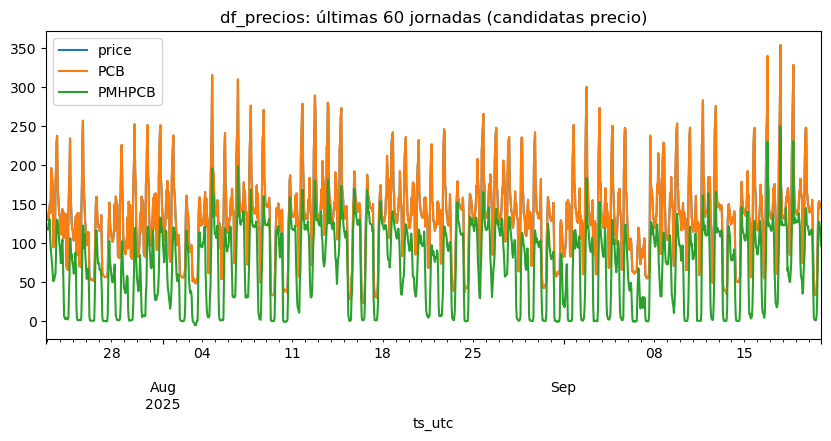

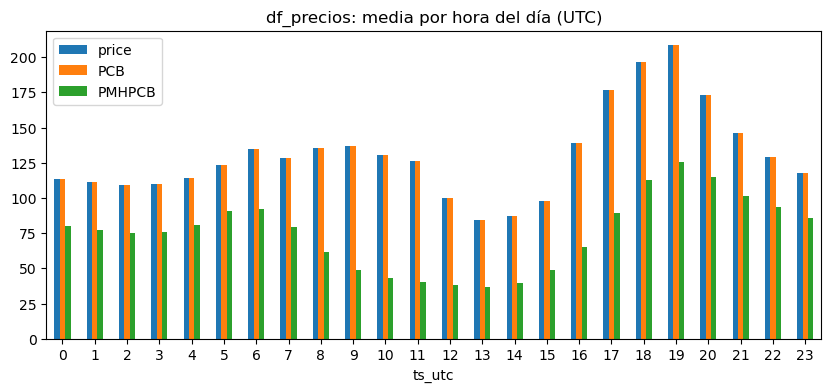

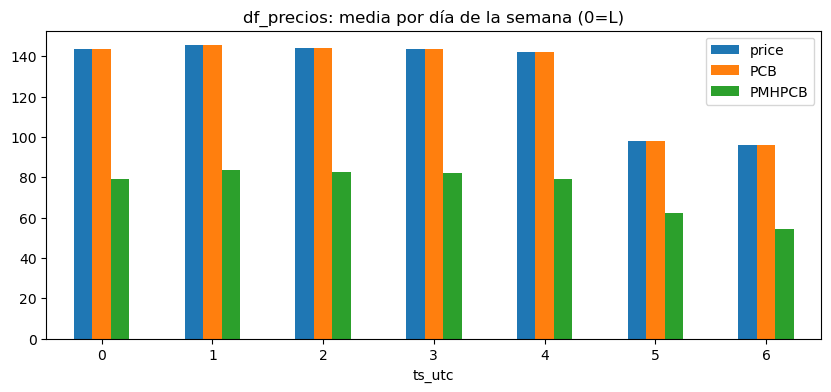


[Outliers] price: 7 puntos con |z|>4


In [29]:
# ============================================================
# 3.1 EDA df_precios — resumen, faltantes, estacionalidad, outliers
# ============================================================
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")

# Helper: último periodo usando .loc (evita .last deprecated)
def last_period(df, period="60D"):
    end = df.index.max()
    start = end - pd.Timedelta(period)
    return df.loc[start:end]

# 0) Cargar si no está en memoria
if "df_precios" not in globals():
    df_precios = pd.read_parquet(os.path.join(DATA_DIR, "df_precios_2024_2025.parquet"),
                                 engine="pyarrow")

# 1) Asegurar índice temporal UTC y orden
if not isinstance(df_precios.index, pd.DatetimeIndex):
    raise TypeError("df_precios debe tener DatetimeIndex.")
if df_precios.index.tz is None:
    df_precios.index = df_precios.index.tz_localize("UTC")
else:
    df_precios.index = df_precios.index.tz_convert("UTC")
df_precios = df_precios.sort_index()

# 2) Resumen básico
deltas = df_precios.index.to_series().diff().dropna()
freq = deltas.mode().iloc[0] if not deltas.mode().empty else pd.Timedelta(hours=1)
print("[df_precios] shape:", df_precios.shape)
print("[df_precios] rango:", df_precios.index.min(), "→", df_precios.index.max())
print("[df_precios] freq≈", freq)
print("[df_precios] duplicados índice:", int(df_precios.index.duplicated().sum()))

# 3) Faltantes por columna (top)
na_precios = df_precios.isna().sum().sort_values(ascending=False)
print("\n[NaN df_precios] top 15 columnas con más nulos:")
print(na_precios.head(15))

# 4) Detección flexible de columnas de precio (targets candidatos)
def detectar_cols_precio(df):
    cols = []
    for c in df.columns:
        cl = str(c).lower()
        if ("precio" in cl) or re.match(r"^p[123].*pcb$", cl):  # p1pcb, p2pcb, p3pcb…
            cols.append(c)
    # fallback: numéricas que empiezan por 'p' si no encontró nada
    if not cols:
        cols = [c for c in df.select_dtypes(include="number").columns
                if str(c).lower().startswith("p")]
    return cols[:3]  # limitamos a 3 para gráficos rápidos

precio_cols = detectar_cols_precio(df_precios)
print("\n[Candidatas de precio] ->", precio_cols if precio_cols else "no detectadas (revisar nombres)")

# 5) Estadísticos descriptivos (primeras 10 columnas numéricas)
desc = df_precios.select_dtypes(include="number").describe().T
print("\n[Describe numérico df_precios] (primeras 10 filas)")
print(desc.head(10))

# 6) Gráficos (si hay columnas de precio)
if precio_cols:
    # Serie temporal (últimos 60 días)
    ax = last_period(df_precios[precio_cols], "60D").plot(figsize=(10,4),
                                                          title="df_precios: últimas 60 jornadas (candidatas precio)")
    plt.show()

    # Estacionalidad por hora del día (media, en UTC)
    hora_mean = df_precios[precio_cols].groupby(df_precios.index.hour).mean()
    ax = hora_mean.plot(kind="bar", figsize=(10,4), title="df_precios: media por hora del día (UTC)")
    plt.xticks(rotation=0)
    plt.show()

    # Estacionalidad por día de la semana (0=Lunes)
    dow_mean = df_precios[precio_cols].groupby(df_precios.index.dayofweek).mean()
    ax = dow_mean.plot(kind="bar", figsize=(10,4), title="df_precios: media por día de la semana (0=L)")
    plt.xticks(rotation=0)
    plt.show()

# 7) Outliers simples (|z|>4) sobre la primera columna candidata
if precio_cols:
    col = precio_cols[0]
    s = df_precios[col].dropna()
    if s.std(ddof=0) > 0:
        z = (s - s.mean()) / s.std(ddof=0)
        n_out = int((z.abs() > 4).sum())
        print(f"\n[Outliers] {col}: {n_out} puntos con |z|>4")
    else:
        print(f"\n[Outliers] {col}: desviación estándar = 0 (no se evalúa)")


## 3.2 EDA de **REE** unificado (`df_ree`)
**Datos**  
- Fuentes: demanda, generación, emisiones, almacenamiento (REE, 5’ → 1 h por media).  
- Alineado al calendario de `df_precios` → **15 048** filas, **65** columnas (nombres normalizados a minúsculas, sin tildes y con `_` en lugar de espacios).  
- Algunas series comienzan más tarde (p. ej. baterías) → NaN iniciales esperados.  

**Vistas y chequeos**  
- Últimos 30 días: `dem_*`, `gen_*` (ciclo combinado, solar FV, eólica, …), `emis_*`, `alm_*`.  
- Cobertura por bloque (no nulos) y ranking de columnas más incompletas.  

**Hallazgos**  
- Alta co-movilidad de **ciclo combinado** y **demanda** con el precio; renovables (solar/eólica) tienden a ir en sentido contrario.


[df_ree] shape: (15048, 81)
[df_ree] rango: 2024-01-01 00:00:00+00:00 → 2025-09-20 23:00:00+00:00
[df_ree] freq≈ 0 days 01:00:00
[df_ree] duplicados índice: 0

[NaN df_ree] top 15 columnas con más nulos:
gen_hidraulica_2                 15048
gen_portugal_importacion_2       15048
gen_eolica_2                     15048
gen_carbon_2                     15048
gen_solar_termica_2              15048
gen_termica_renovable_2          15048
gen_cogeneracion_y_residuos_2    15048
gen_andorra_exportacion_2        15048
gen_marruecos_exportacion_2      15048
gen_portugal_exportacion_2       15048
gen_francia_exportacion_2        15048
gen_francia_importacion_2        15048
gen_marruecos_importacion_2      15048
gen_fuel_gas                     15048
gen_andorra_importacion_2        15048
dtype: int64

[Cobertura por bloque]
  [dem_] columnas=3 | no nulos top 5:
dem_real          15046
dem_prevista      15046
dem_programada    15046
dtype: int64
  [gen_] columnas=41 | no nulos top 5:
gen_eolica  

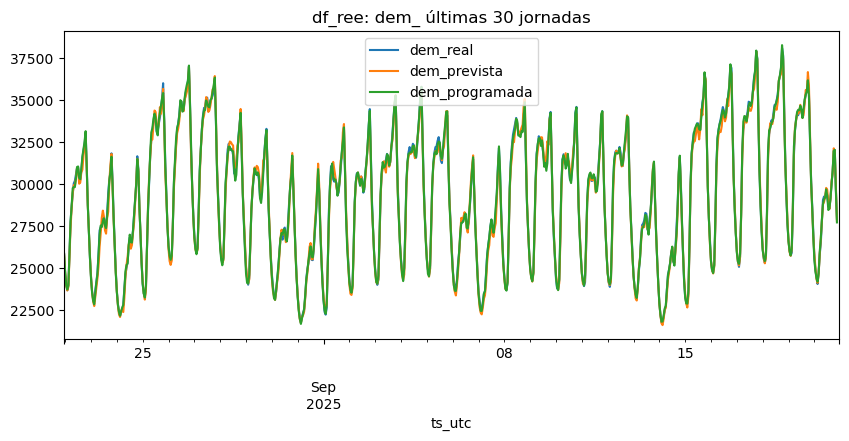

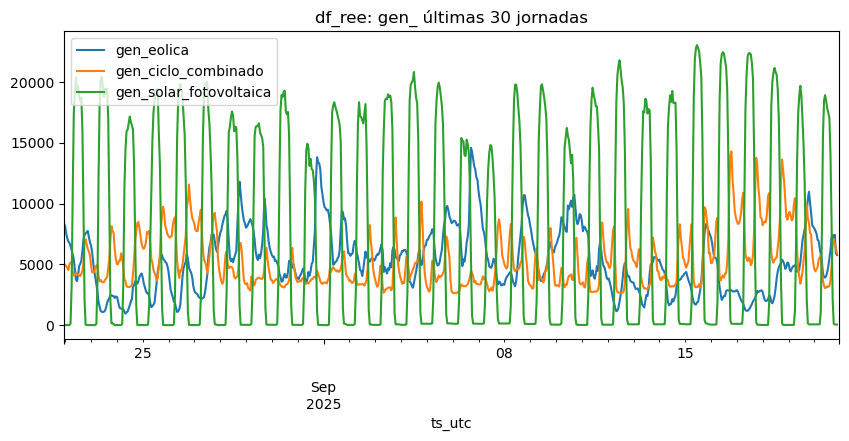

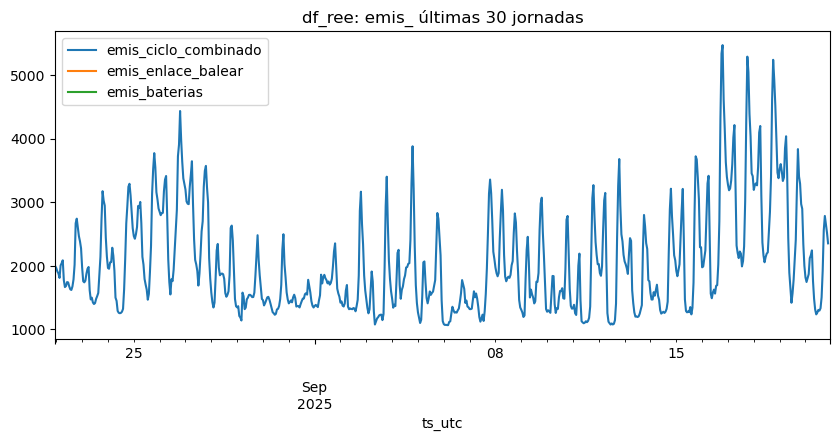

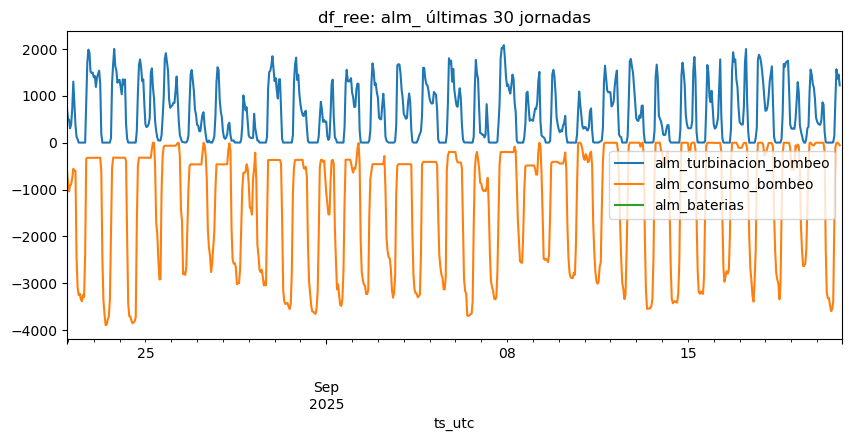


[Correlaciones] demanda vs. generación (Pearson, mismo tiempo)
                        dem_real  gen_eolica  gen_ciclo_combinado  \
dem_real                1.000000    0.042017             0.393378   
gen_eolica              0.042017    1.000000            -0.280885   
gen_ciclo_combinado     0.393378   -0.280885             1.000000   
gen_solar_fotovoltaica  0.292118   -0.334903            -0.349044   

                        gen_solar_fotovoltaica  
dem_real                              0.292118  
gen_eolica                           -0.334903  
gen_ciclo_combinado                  -0.349044  
gen_solar_fotovoltaica                1.000000  


In [31]:
# ============================================================
# 3.2 EDA df_ree — resumen, cobertura, faltantes, ejemplos y correlaciones
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")

# Helper: último periodo con .loc (evita .last deprecated)
def last_period(df, period="30D"):
    end = df.index.max()
    start = end - pd.Timedelta(period)
    return df.loc[start:end]

# 0) Cargar si no está en memoria (ya normalizado a minúsculas/ASCII)
if "df_ree" not in globals():
    df_ree = pd.read_parquet(os.path.join(DATA_DIR, "df_ree.parquet"),
                             engine="pyarrow")

# 1) Asegurar índice UTC ordenado
if not isinstance(df_ree.index, pd.DatetimeIndex):
    raise TypeError("df_ree debe tener DatetimeIndex.")
if df_ree.index.tz is None:
    df_ree.index = df_ree.index.tz_localize("UTC")
else:
    df_ree.index = df_ree.index.tz_convert("UTC")
df_ree = df_ree.sort_index()

# 2) Resumen básico
deltas = df_ree.index.to_series().diff().dropna()
freq = deltas.mode().iloc[0] if not deltas.mode().empty else pd.Timedelta(hours=1)
print("[df_ree] shape:", df_ree.shape)
print("[df_ree] rango:", df_ree.index.min(), "→", df_ree.index.max())
print("[df_ree] freq≈", freq)
print("[df_ree] duplicados índice:", int(df_ree.index.duplicated().sum()))

# 3) Faltantes (top)
na_ree = df_ree.isna().sum().sort_values(ascending=False)
print("\n[NaN df_ree] top 15 columnas con más nulos:")
print(na_ree.head(15))

# 4) Cobertura por bloque (no nulos)
def no_nulos_prefijo(df, pref, n=5):
    cols = [c for c in df.columns if c.startswith(pref)]
    if not cols:
        print(f"  [Aviso] No hay columnas con prefijo {pref}")
        return
    nn = df[cols].notna().sum().sort_values(ascending=False)
    print(f"  [{pref}] columnas={len(cols)} | no nulos top {n}:")
    print(nn.head(n))

print("\n[Cobertura por bloque]")
for pref in ["dem_", "gen_", "emis_", "alm_"]:
    no_nulos_prefijo(df_ree, pref, n=5)

# 5) Series representativas (si existen)
ejemplos = [
    ("dem_", ["dem_real", "dem_prevista", "dem_programada"]),
    ("gen_", ["gen_eolica", "gen_ciclo_combinado", "gen_solar_fotovoltaica"]),
    ("emis_", ["emis_ciclo_combinado", "emis_enlace_balear", "emis_baterias"]),
    ("alm_", ["alm_turbinacion_bombeo", "alm_consumo_bombeo", "alm_baterias"]),
]

for pref, cols_candidatas in ejemplos:
    cols = [c for c in cols_candidatas if c in df_ree.columns]
    if cols:
        ax = last_period(df_ree[cols], "30D").plot(figsize=(10,4),
                                                   title=f"df_ree: {pref} últimas 30 jornadas")
        plt.show()

# 6) Correlaciones rápidas (ej: demanda vs. algunas generadoras si existen)
corr_cols = [c for c in ["dem_real","gen_eolica","gen_ciclo_combinado","gen_solar_fotovoltaica"]
             if c in df_ree.columns]
if len(corr_cols) >= 2:
    corr = df_ree[corr_cols].corr()
    print("\n[Correlaciones] demanda vs. generación (Pearson, mismo tiempo)")
    print(corr)


In [32]:
import re

def base_name(c): return re.sub(r"_(\d+)$", "", str(c))

pares = []
for c in df_ree.columns:
    m = re.match(r"^(.*)_2$", str(c))
    if m and base_name(c) in df_ree.columns:
        pares.append((base_name(c), c))

perdidas = []
for base, c2 in pares:
    # Horas donde _2 tiene dato y base está NaN (información exclusiva de _2)
    solo_en_2 = df_ree[c2].notna() & df_ree[base].isna()
    n = int(solo_en_2.sum())
    if n > 0:
        perdidas.append((base, c2, n))

if perdidas:
    print("[ATENCIÓN] Estas _2 tenían datos exclusivos:")
    for base, c2, n in perdidas:
        print(f"  {c2} aporta {n} horas que no están en {base}")
else:
    print("OK: ninguna columna _2 aporta información exclusiva.")


OK: ninguna columna _2 aporta información exclusiva.


In [33]:
# ============================================================
# Limpieza final: eliminar columnas duplicadas *_<num> (todas vacías)
# y guardar df_ree actualizado
# ============================================================
import os, re, pandas as pd

DATA_DIR = globals().get("DATA_DIR", "datasets")
if "df_ree" not in globals():
    df_ree = pd.read_parquet(os.path.join(DATA_DIR, "df_ree.parquet"), engine="pyarrow")

dup_cols = [c for c in df_ree.columns if re.search(r"_(\d+)$", str(c))]
print(f"Columnas *_<num> detectadas: {len(dup_cols)}")

df_ree = df_ree.drop(columns=dup_cols, errors="ignore")
print("[df_ree] nuevo shape:", df_ree.shape)

out_path = os.path.join(DATA_DIR, "df_ree.parquet")
df_ree.to_parquet(out_path, engine="pyarrow", index=True, compression="snappy")
print(f"[OK] Guardado df_ree limpio → {out_path}")


Columnas *_<num> detectadas: 16
[df_ree] nuevo shape: (15048, 65)
[OK] Guardado df_ree limpio → datasets/df_ree.parquet


## 3.3 Distribuciones del **precio**
- Histogramas (lineal/log) y boxplot.  
- **Conclusión**: colas pesadas; considerar winsorización o tratamiento robusto de outliers en Preprocesado.


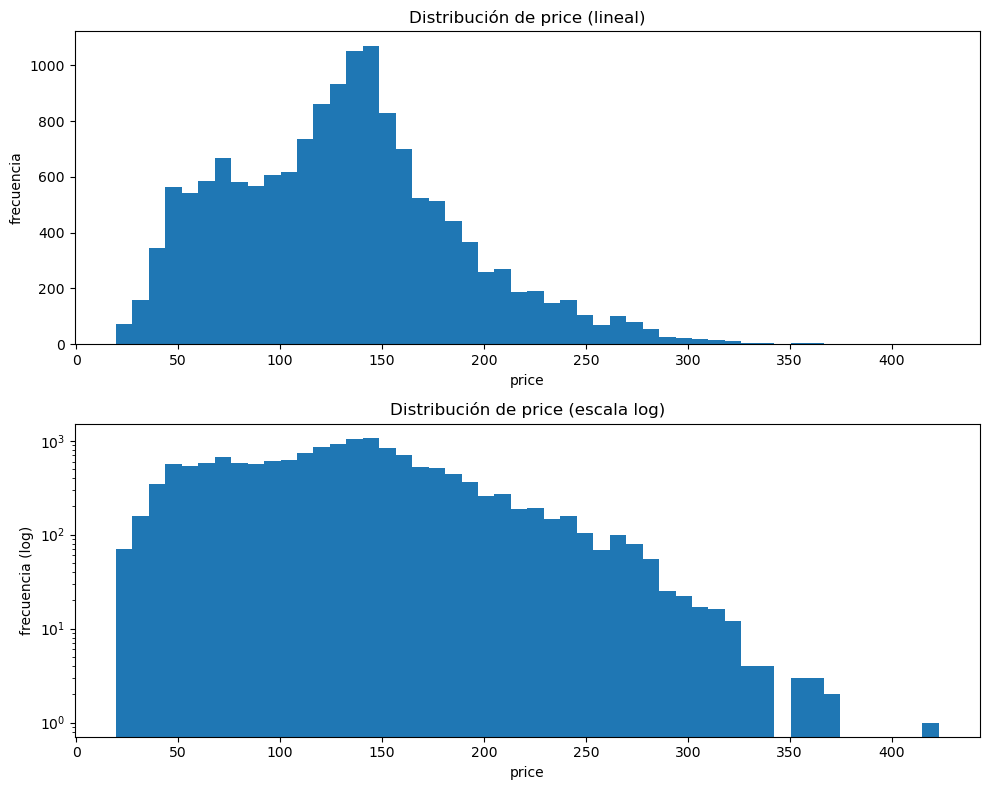

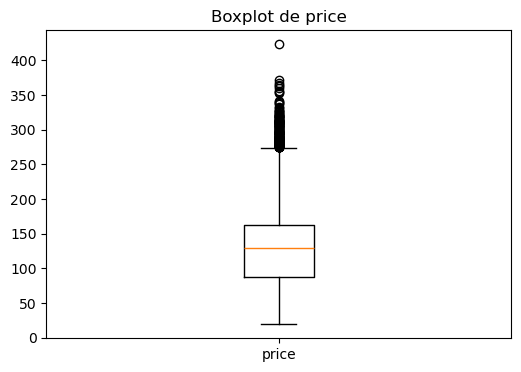

In [35]:
# ============================================================
# 3.3 Distribuciones del precio (df_precios)
# ============================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")

if "df_precios" not in globals():
    df_precios = pd.read_parquet(os.path.join(DATA_DIR, "df_precios_2024_2025.parquet"), engine="pyarrow")

# asegurar índice UTC ordenado
if df_precios.index.tz is None:
    df_precios.index = df_precios.index.tz_localize("UTC")
else:
    df_precios.index = df_precios.index.tz_convert("UTC")
df_precios = df_precios.sort_index()

# elegimos 'price' si existe; si no, la primera candidata numérica
target = "price" if "price" in df_precios.columns else df_precios.select_dtypes("number").columns[0]
s = df_precios[target].dropna()

fig = plt.figure(figsize=(10,8))

# Histograma lineal
ax1 = plt.subplot(2,1,1)
ax1.hist(s, bins=50)
ax1.set_title(f"Distribución de {target} (lineal)")
ax1.set_xlabel(target); ax1.set_ylabel("frecuencia")

# Histograma log (para colas)
ax2 = plt.subplot(2,1,2)
ax2.hist(s, bins=50, log=True)
ax2.set_title(f"Distribución de {target} (escala log)")
ax2.set_xlabel(target); ax2.set_ylabel("frecuencia (log)")
plt.tight_layout(); plt.show()

# Boxplot básico
plt.figure(figsize=(6,4))
plt.boxplot(s.values, vert=True, tick_labels=[target], showfliers=True)
plt.title(f"Boxplot de {target}")
plt.show()


## 3.4 ACF/PACF del **precio** (lags en horas)
- **ACF**: picos fuertes en **1–3**, **24**, **48**, **168** → persistencia + estacionalidad **diaria** y **semanal**.  
- **PACF**: gran pico en **lag=1** y señal en **24** → estructura **AR** corta (p≈1–3) y **AR estacional** (P≈1, s=24).  
- **Implicación**: serie no totalmente estacionaria → probar **d=1** y, si procede, **D∈{0,1}** (s=24).


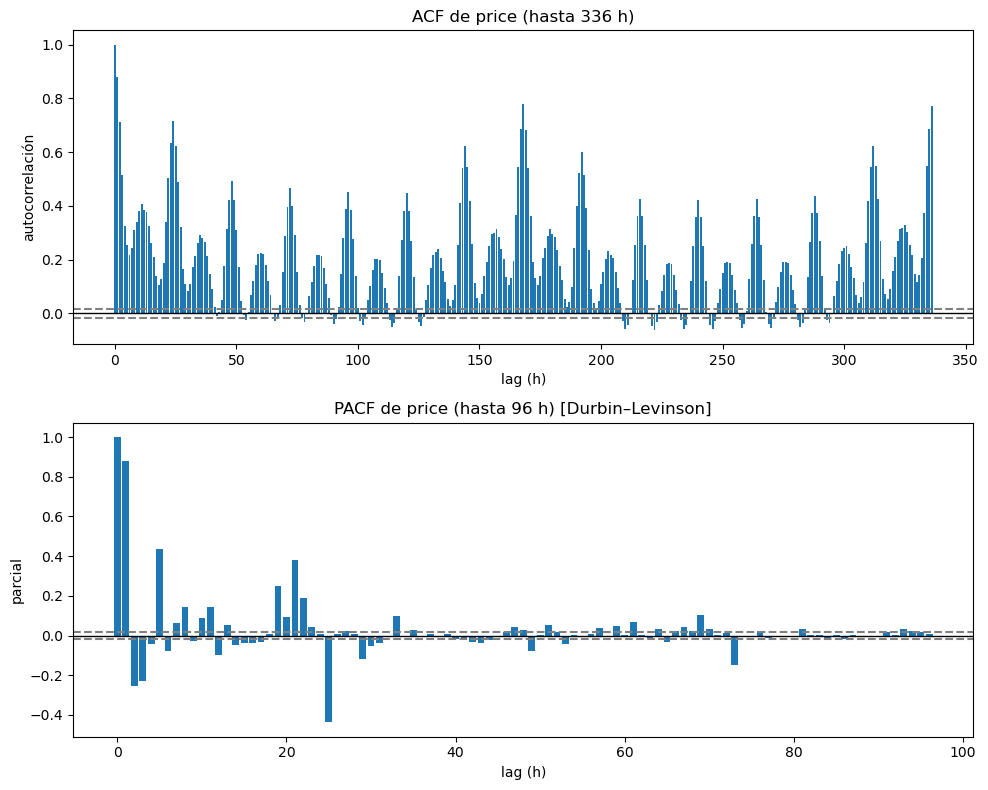


[ACF en lags clave] (h):
lag   1:  0.879
lag   2:  0.714
lag   3:  0.514
lag   6:  0.218
lag  12:  0.385
lag  24:  0.716
lag  48:  0.491
lag  72:  0.465
lag  96:  0.452
lag 120:  0.447
lag 144:  0.622
lag 168:  0.779
lag 192:  0.599
lag 216:  0.426
lag 336:  0.772

[Top |ACF| 1..200 h]
1      0.878690
168    0.779464
24     0.715742
2      0.713591
167    0.685117
169    0.683347
23     0.633859
25     0.624024
144    0.622174
192    0.599263
166    0.543535
145    0.543115
170    0.541316
143    0.539942
191    0.522344
dtype: float64


In [37]:
# ============================================================
# 3.4 ACF/PACF del precio (versión 100% NumPy/Matplotlib)
# - ACF manual con normalización
# - PACF por Durbin–Levinson
# - Gráficas con barras y bandas de ±1.96/sqrt(N)
# ============================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, math

DATA_DIR = globals().get("DATA_DIR", "datasets")

# 0) Cargar df_precios si no está en memoria
if "df_precios" not in globals():
    df_precios = pd.read_parquet(os.path.join(DATA_DIR, "df_precios_2024_2025.parquet"),
                                 engine="pyarrow")

# 1) Índice UTC ordenado
if not isinstance(df_precios.index, pd.DatetimeIndex):
    raise TypeError("df_precios debe tener DatetimeIndex.")
if df_precios.index.tz is None:
    df_precios.index = df_precios.index.tz_localize("UTC")
else:
    df_precios.index = df_precios.index.tz_convert("UTC")
df_precios = df_precios.sort_index()

# 2) Target
target = "price" if "price" in df_precios.columns else df_precios.select_dtypes("number").columns[0]
x = df_precios[target].dropna().values.astype(float)
N = x.size
x = x - x.mean()
var = np.dot(x, x)

# 3) ACF manual (normalizada)
max_lag_acf = 336  # 2 semanas
acf = np.empty(max_lag_acf + 1, dtype=float)
acf[0] = 1.0
for k in range(1, max_lag_acf + 1):
    acf[k] = np.dot(x[:-k], x[k:]) / var

# 4) PACF por Durbin–Levinson (usa autocorrelación acf normalizada)
def pacf_durbin_levinson(rho: np.ndarray, nlags: int) -> np.ndarray:
    pacf = np.zeros(nlags + 1, dtype=float)
    pacf[0] = 1.0
    if nlags == 0:
        return pacf
    phi = np.zeros((nlags + 1, nlags + 1), dtype=float)
    phi[1, 1] = rho[1]
    pacf[1] = rho[1]
    v = 1.0 - rho[1] ** 2
    for k in range(2, nlags + 1):
        num = rho[k] - sum(phi[k-1, j] * rho[k - j] for j in range(1, k))
        den = v
        phi[k, k] = num / den if den != 0 else 0.0
        for j in range(1, k):
            phi[k, j] = phi[k-1, j] - phi[k, k] * phi[k-1, k - j]
        pacf[k] = phi[k, k]
        v = v * (1.0 - phi[k, k] ** 2)
    return pacf

max_lag_pacf = 96
pacf = pacf_durbin_levinson(acf, max_lag_pacf)

# 5) Gráficas con barras + bandas de confianza
ci = 1.96 / math.sqrt(N)  # aprox. para ruido blanco

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

lags_acf = np.arange(len(acf))
ax[0].bar(lags_acf, acf, width=0.8)
ax[0].axhline(0, color="black", linewidth=1)
ax[0].axhline(+ci, color="gray", linestyle="--")
ax[0].axhline(-ci, color="gray", linestyle="--")
ax[0].set_title(f"ACF de {target} (hasta {max_lag_acf} h)")
ax[0].set_xlabel("lag (h)"); ax[0].set_ylabel("autocorrelación")

lags_pacf = np.arange(len(pacf))
ax[1].bar(lags_pacf, pacf, width=0.8)
ax[1].axhline(0, color="black", linewidth=1)
ax[1].axhline(+ci, color="gray", linestyle="--")
ax[1].axhline(-ci, color="gray", linestyle="--")
ax[1].set_title(f"PACF de {target} (hasta {max_lag_pacf} h) [Durbin–Levinson]")
ax[1].set_xlabel("lag (h)"); ax[1].set_ylabel("parcial")

plt.tight_layout(); plt.show()

# 6) ACF en lags clave y ranking
check_lags = [1, 2, 3, 6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 216, 336]
acf_key = {k: acf[k] for k in check_lags if k <= max_lag_acf}
print("\n[ACF en lags clave] (h):")
for k in check_lags:
    if k in acf_key:
        print(f"lag {k:>3}: {acf_key[k]: .3f}")

max_lag_rank = 200
acf_series = pd.Series(acf[1:max_lag_rank+1], index=np.arange(1, max_lag_rank+1))
top_abs = acf_series.abs().sort_values(ascending=False).head(15).index
print("\n[Top |ACF| 1..200 h]")
print(acf_series.loc[top_abs].sort_values(ascending=False))


#### ACF/PACF de `price` (tras limpieza 3.0)

> Cálculo después de eliminar días anómalos (`2023-12-31`, `2024-10-27`, `2025-04-28`, `2025-09-21`). Método de PACF: Durbin–Levinson.

#### ACF (hasta 336 h)

* **Lags 1–3**: picos muy fuertes → **memoria corta** importante.
* **Lags 24, 48, 72, …**: picos marcados → **estacionalidad diaria** (24 h).
* **Lag 168** (y vecinos **167/169**) muy alto → **estacionalidad semanal** (7×24).
* **Lags 144 y 192** también altos → efecto “semana laboral” (6 y 8 días respecto al hoy).
* **Lag 336 ≈ 2 semanas** vuelve a subir → persistencia quincenal.

> La **ACF(1)=0.879** y la **caída lenta** indican que la serie no es plenamente estacionaria; conviene **diferenciar (d=1)** y controlar la parte estacional.

#### PACF (hasta 96 h)

* **Gran pico en lag 1** y más pequeños en **2–3** → **AR corto (p≈1–3)**.
* Señal en **lag 24** → dependencia **estacional diaria directa** (AR estacional con (P≈1), (s=24)).
* Resto cercano a 0 → si se añaden términos AR/MA adicionales, que sean **pequeños**.

#### ACF en lags clave (h)

```
  1: 0.879   24: 0.716   144: 0.622   168: 0.779
  2: 0.714   48: 0.491   192: 0.599   336: 0.772
  3: 0.514   72: 0.465   120: 0.447
   6: 0.218   96: 0.452
```

**Top |ACF| (1..200 h):** 1, 168, 24, 2, 167, 169, 23, 25, 144, 192, 166, 145, 170, 143, 191 → dominan los **ciclos diario y semanal**, con armónicos cercanos.

#### Implicaciones para el modelado

##### SARIMAX (punto de partida, sin/ con exógenas)

* **Diferenciación no estacional:** `d = 1`.
* **Parte estacional (diaria):** `s = 24`, probar `P ∈ {1}`, `D ∈ {0,1}`, `Q ∈ {0,1}`.
* **Parte no estacional:** `p ∈ {1,2,3}`, `q ∈ {0,1}`.
* El ciclo **semanal (168 h)** no puede ponerse como `s=168` a la vez; incluirlo como **exógeno** (p. ej., **términos de Fourier** semanales K=2–3 o dummies de día-de-semana) o **lags** específicos (168).

**Rejilla inicial sugerida**

* `(p,d,q) ∈ {(1,1,0), (2,1,0), (3,1,0), (1,1,1)}`
* `(P,D,Q,s) ∈ {(1,0,0,24), (1,1,0,24), (1,0,1,24)}`
* Exógenos opcionales: Fourier(168, K=2..3), `dow`/`hour`, festivos.

##### Modelos tipo XGBoost / RNN

* Crear **lags** en: `1–3`, `24`, `48`, `72`, `144`, `168` (mínimo: `1–3,24,168`).
* Añadir **ventanas rolling** centradas/en el pasado (media, min, max, std; 6–24–168 h).
* Incluir **calendario** (hora-del-día, día-de-semana, festivos) y **exógenas** (REE, etc.).
* Para RNN, usar **lookbacks** que cubran **≥168 h** para capturar el ciclo semanal.



## 3.5 Correlaciones **simultáneas** `df_ree` ↔︎ `price`
- Top **positivas**:  
  `emis_ciclo_combinado`, `gen_ciclo_combinado`, `emis/gen_cogeneracion_y_residuos` (~0.63–0.67), `dem_*` (~0.57).  
- Top **negativas** reales:  
  `gen_solar_fotovoltaica` (≈ −0.24), `gen_solar_termica` (≈ −0.16), `gen_eolica` (≈ −0.10).  
- Exportados a `datasets/`:  
  - `eda_correlaciones_ree_vs_precio.csv`  
  - `eda_describe_precios.csv`  
  - `eda_nulos_df_ree.csv`

[Target] columna usada como precio: price

[Correlaciones con el precio] Top 15 POSITIVAS:
emis_ciclo_combinado            0.667168
gen_ciclo_combinado             0.663497
emis_cogeneracion_y_residuos    0.629857
gen_cogeneracion_y_residuos     0.628297
dem_programada                  0.572798
dem_real                        0.570589
dem_prevista                    0.569998
alm_entrega_de_baterias         0.545375
alm_consumo_bombeo              0.533683
emis_turbina_de_gas             0.490557
gen_turbina_de_gas              0.480293
emis_motores_diesel             0.425058
gen_motores_diesel              0.425012
gen_biocombustible              0.420903
alm_carga_de_baterias           0.394477
Name: price, dtype: float64

[Correlaciones con el precio] Top 15 NEGATIVAS:
gen_turbina_de_vapor         0.150855
emis_turbina_de_vapor        0.150635
gen_portugal_importacion     0.129264
alm_consumo_baterias         0.068299
gen_marruecos_importacion    0.059244
gen_generacion_auxiliar    

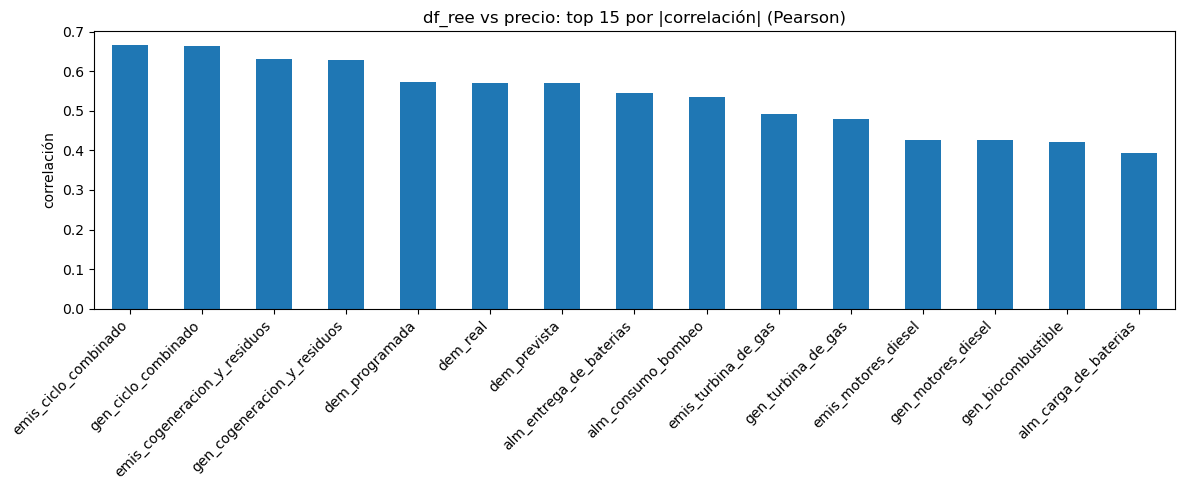

[OK] CSVs guardados en: datasets


In [41]:
# ============================================================
# 3.5 Ranking de correlaciones (df_ree vs. price, mismo timestamp)
# - No fusionamos datasets: solo alineamos por índice temporal
# - Imprime Top 15 positivas y negativas
# - Grafica Top 15 por |correlación|
# - Exporta CSVs al directorio datasets/
# ============================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")

# 0) Cargar si no están en memoria
if "df_precios" not in globals():
    df_precios = pd.read_parquet(os.path.join(DATA_DIR, "df_precios_2024_2025.parquet"),
                                 engine="pyarrow")
if "df_ree" not in globals():
    df_ree = pd.read_parquet(os.path.join(DATA_DIR, "df_ree.parquet"),
                             engine="pyarrow")

# 1) Asegurar índices UTC y orden
def _ensure_utc_sorted(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Se esperaba DatetimeIndex.")
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    else:
        df.index = df.index.tz_convert("UTC")
    return df.sort_index()

df_precios = _ensure_utc_sorted(df_precios)
df_ree     = _ensure_utc_sorted(df_ree)

# 2) Seleccionar target de precio
target = "price" if "price" in df_precios.columns else \
         df_precios.select_dtypes(include="number").columns[0]
print(f"[Target] columna usada como precio: {target}")

# 3) Alinear por índice (inner para evitar NaN en correlación)
y = df_precios[[target]]
X = df_ree.select_dtypes(include="number")
df_aligned = y.join(X, how="inner")

# 4) Correlaciones con el precio
corrs = df_aligned.corr(numeric_only=True)[target].drop(labels=[target]).dropna()
corrs_sorted = corrs.sort_values(ascending=False)

top_pos = corrs_sorted.head(15)
top_neg = corrs_sorted.tail(15)

print("\n[Correlaciones con el precio] Top 15 POSITIVAS:")
print(top_pos)
print("\n[Correlaciones con el precio] Top 15 NEGATIVAS:")
print(top_neg)

# 5) Gráfico: top 15 por valor absoluto
top_abs = corrs.reindex(corrs.abs().sort_values(ascending=False).head(15).index)
plt.figure(figsize=(12,5))
top_abs.plot(kind="bar")
plt.title("df_ree vs precio: top 15 por |correlación| (Pearson)")
plt.ylabel("correlación")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 6) (Opcional) Exportar tablas a CSV para anexos
out_dir = DATA_DIR
corrs.sort_values(ascending=False).to_csv(os.path.join(out_dir, "eda_correlaciones_ree_vs_precio.csv"))
df_precios.select_dtypes("number").describe().T.to_csv(os.path.join(out_dir, "eda_describe_precios.csv"))
df_ree.select_dtypes("number").isna().sum().sort_values(ascending=False).to_csv(os.path.join(out_dir, "eda_nulos_df_ree.csv"))
print(f"[OK] CSVs guardados en: {out_dir}")


## 3.6 Correlaciones **lead/lag** (±48 h) vs. `price`
- **Convención**: lag > 0 ⇒ la exógena **se adelanta** (útil para predecir).  
- Resultados destacados:
  - `gen_ciclo_combinado`, `emis_ciclo_combinado`, `dem_real` → mejor **lag=0** (co-mueven); para evitar leakage se usarán **t−1, t−24, t−168**.  
  - `gen_solar_fotovoltaica` → mejor **lag=+8** (anticipa picos vespertinos) ⇒ usar **t−8** (y t−24).  
  - `alm_entrega_de_baterias` → mejor **lag=+48** ⇒ probar **t−24/t−48** (si hay cobertura).


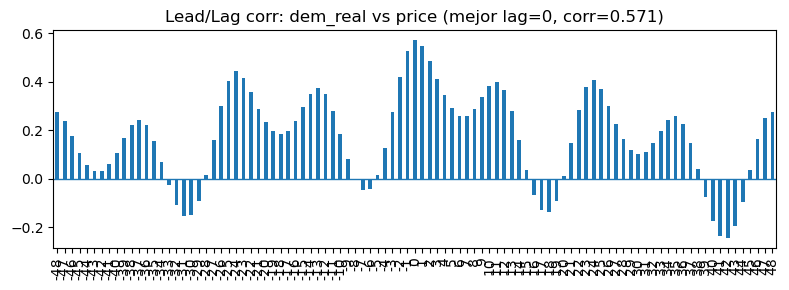

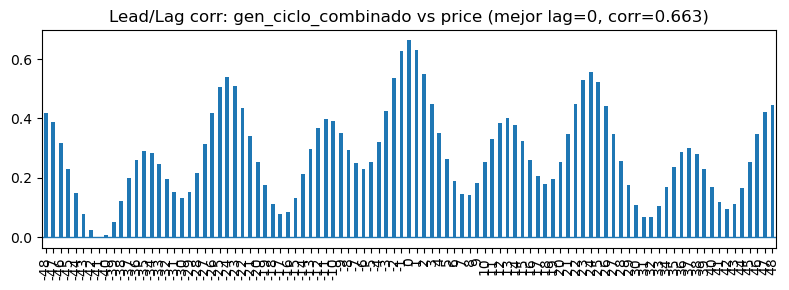

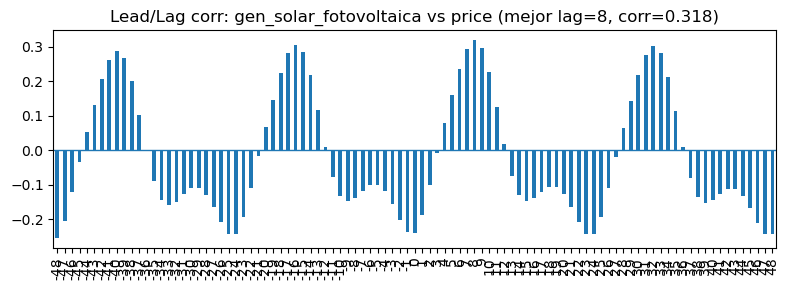

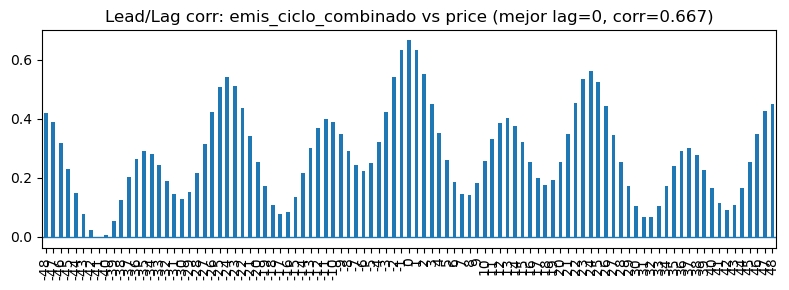

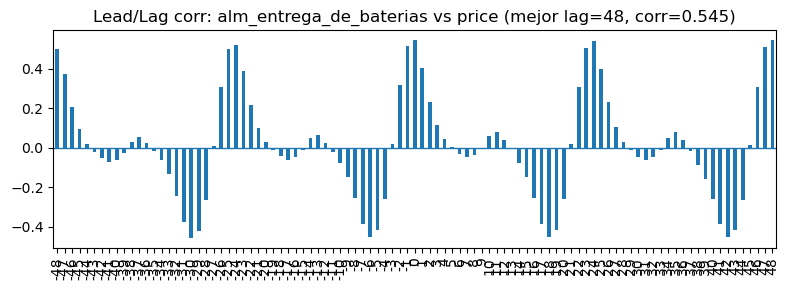

                  variable  lag_opt  corr_at_lag
3     emis_ciclo_combinado        0     0.667168
1      gen_ciclo_combinado        0     0.663497
0                 dem_real        0     0.570589
4  alm_entrega_de_baterias       48     0.545390
2   gen_solar_fotovoltaica        8     0.318228


In [43]:
# ============================================================
# 3.6 Correlaciones con desfase (lead/lag) vs. price
#  - Busca el lag en [-48, +48] con mayor |corr|
#  - Signo de lag:
#      lag > 0  -> X adelantada (X_t-1 con price_t)  = X ayuda a predecir price
#      lag < 0  -> X retrasada (X_t con price_t-1)   = price ayuda a X
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def best_lag_corr(y: pd.Series, x: pd.Series, max_lag=48):
    # Alinear por índice y quitar NaN
    df = pd.concat([y.rename("y"), x.rename("x")], axis=1).dropna()
    yv, xv = df["y"], df["x"]
    lags = range(-max_lag, max_lag+1)
    vals = []
    for k in lags:
        if k > 0:
            # X adelantada: correlaciona x_{t-k} con y_t  (X explica futuro)
            c = yv.corr(xv.shift(k))
        elif k < 0:
            # X retrasada: correlaciona x_t con y_{t+k}
            c = yv.shift(-k).corr(xv)
        else:
            c = yv.corr(xv)
        vals.append(c)
    s = pd.Series(vals, index=lags, dtype="float64")
    k_opt = int(s.abs().idxmax())
    return k_opt, s[k_opt], s

# --- datos
target = "price"
y = df_precios[target]

candidatas = [
    "dem_real",
    "gen_ciclo_combinado",
    "gen_solar_fotovoltaica",
    "emis_ciclo_combinado",
    "alm_entrega_de_baterias",
]
candidatas = [c for c in candidatas if c in df_ree.columns]

results = []
for c in candidatas:
    k, v, serie = best_lag_corr(y, df_ree[c], max_lag=48)
    results.append((c, k, v))
    # gráfico pequeño por variable
    plt.figure(figsize=(8,3))
    serie.plot(kind="bar")
    plt.axhline(0, linewidth=1)
    plt.title(f"Lead/Lag corr: {c} vs price (mejor lag={k}, corr={v:.3f})")
    plt.tight_layout(); plt.show()

# ranking por |corr|
res = pd.DataFrame(results, columns=["variable","lag_opt","corr_at_lag"])
print(res.reindex(res["corr_at_lag"].abs().sort_values(ascending=False).index))


#### Decisiones para modelado (derivadas del EDA)

##### Objetivo

* **Variable a predecir:** `price` (€/MWh).

##### Lo que nos dice el EDA (resumen operativo)

* **Memoria corta fuerte** (ACF lag 1–3 ≈ 0.88/0.71/0.51).
* **Estacionalidad diaria** muy marcada (ACF lag **24h ≈ 0.716**, también 48/72/96…).
* **Componente semanal** clara (ACF lag **168h ≈ 0.779**, y 336h ≈ 0.772).
* Tras limpiar días atípicos/incompletos, los **drivers REE** más correlacionados (lead/lag) con `price` son:

  * `emis_ciclo_combinado` → lag óptimo **0h**, corr **0.667**
  * `gen_ciclo_combinado` → **0h**, corr **0.663**
  * `dem_real` → **0h**, corr **0.571**
  * `alm_entrega_de_baterias` → **48h**, corr **0.545**
  * `gen_solar_fotovoltaica` → **8h**, corr **0.318**

> Nota: aunque el máximo esté en lag 0h para varios drivers, **en entrenamiento no usamos t=0** para evitar *leakage*; desplazamos a lags pasados (t−1, t−24, t−168).

#### Feature set recomendado (sin mirar el futuro)

##### Endógenas (a partir de `price`)

* **Lags fijos:** `price_lag{1,2,3,24,48,168}`.
* **Rolling sobre `price` (ventanas orientativas):**

  * medias: `roll_mean_{3,6,12,24,168}`
  * extremos: `roll_min_{24,168}`, `roll_max_{24,168}`
  * volatilidad: `roll_std_{24,168}`
* **Calendario:**

  * `hour`, `dow`, `is_weekend`, `month`
  * **Fourier semanal** (k=2–3 términos) para capturar 168h.

##### Exógenas REE (desplazadas)

* **`emis_ciclo_combinado`** → lags `{1,24,168}`
* **`gen_ciclo_combinado`** → lags `{1,24,168}`
* **`dem_real`** → lags `{1,24,168}`
* **`gen_solar_fotovoltaica`** → lags `{8,24}`
* **`alm_entrega_de_baterias`** → lags `{48,24}`

  * (si hay huecos, añadir flags `*_isna` y rellenado corto como hicimos en 8.1-bis)

> Si existen otras fuentes (viento/hidro, interconexiones…), aplicar el mismo criterio de **lead/lag** y añadir los **2–3 mejores lags pasados**.

#### SARIMAX (línea base explicable)

* **No estacional:** probar (p,d,q) ∈ {(1,1,0), (2,1,0), (3,1,0), (1,1,1)}
* **Estacional (diaria):** (P,D,Q,s) ∈ {(1,0,0,24), (1,1,0,24), (1,0,1,24)}
* **Exógenos:** Fourier semanal (168h) + los drivers REE anteriores **laggeados**.

#### Modelos tipo XGBoost / RNN

* Alimentar con el **bloque endógeno** (lags + rolling + calendario) +
  el **bloque exógeno REE** laggeado (especial atención a baterías **t−48** y solar **t−8**).
* Validar con *timeseries split* y comparar contra la *seasonal naive (24h)*.

#### Justificación con números (extraídos de los gráficos)

* **ACF lags clave:** 1 (0.879), 24 (0.716), 168 (0.779), 336 (0.772).
* **Lead/Lag (corr máx.):**
  `emis_ciclo_combinado@0h=0.667`, `gen_ciclo_combinado@0h=0.663`,
  `dem_real@0h=0.571`, `alm_entrega_de_baterias@48h=0.545`, `gen_solar_fotovoltaica@8h=0.318`.

Estos hallazgos respaldan el *feature set* que ya usamos en los experimentos (XGB ganador) y las extensiones de RNN del **8.1-bis** (lags de baterías + flags de NA), manteniendo siempre el **desfase temporal** para no filtrar información del futuro.


# 4. Preprocesamiento

## 4.1 Asegurar índice temporal (UTC) y anti-leakage

* Fuerza `df_precios` y `df_ree` a **DatetimeIndex UTC** ordenado.
* **Anti-leakage:** elimina `PCB` si es idéntica a `price` (evita usar la `y` como *feature*).
* **Salida esperada:** mensaje `[Leakage-guard] …` si se elimina `PCB` y confirmación de UTC.



In [47]:
# ============================================================
# 4.1 Asegurar índice temporal (UTC) y anti-leakage
# ============================================================
import os, numpy as np, pandas as pd

DATA_DIR   = globals().get("DATA_DIR", "datasets")
TARGET_COL = "price"
COV_MIN    = 0.90         # umbral cobertura para dataset A
ADD_MISS_FLAGS = True     # añadir *_isna al dataset B

def _ensure_utc_sorted(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Se esperaba DatetimeIndex.")
    df = df.sort_index()
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    else:
        df.index = df.index.tz_convert("UTC")
    return df

# Carga de parquets si no están en memoria
if "df_precios" not in globals():
    df_precios = pd.read_parquet(os.path.join(DATA_DIR, "df_precios_2024_2025.parquet"), engine="pyarrow")
if "df_ree" not in globals():
    df_ree = pd.read_parquet(os.path.join(DATA_DIR, "df_ree.parquet"), engine="pyarrow")

# Forzar UTC y orden
df_precios = _ensure_utc_sorted(df_precios)
df_ree     = _ensure_utc_sorted(df_ree)

# Guard anti-leakage: si PCB == price, eliminar PCB
if "PCB" in df_precios.columns:
    _pcb_eq = (pd.to_numeric(df_precios["PCB"], errors="coerce")
               - pd.to_numeric(df_precios[TARGET_COL], errors="coerce")).abs().max()
    if pd.notna(_pcb_eq) and float(_pcb_eq) == 0.0:
        df_precios = df_precios.drop(columns=["PCB"])
        print("[Leakage-guard] 'PCB' es idéntica a 'price'; eliminada del feature set.")

print("[OK] df_precios y df_ree en UTC y ordenados.")


[Leakage-guard] 'PCB' es idéntica a 'price'; eliminada del feature set.
[OK] df_precios y df_ree en UTC y ordenados.


## 4.2 Precio “robusto” para *rolling*

* Define `price_robust = clip(price, p0.5, p99.5)` para reducir el peso de outliers **solo** en medias/desvíos móviles.
* **No** modifica la variable objetivo `y`.
* **Salida esperada:** rangos `p0.5–p99.5` impresos.

In [49]:
# ============================================================
# 4.2 Precio robusto para rolling (winsorize p0.5–p99.5 con TRAIN)
# ============================================================
TARGET_COL = "price"

# Si estás aún con df_precios entero, delimita explícitamente el tramo TRAIN:
# (ajusta estas fechas a tus splits reales)
train_mask = (df_precios.index >= "2024-01-01") & (df_precios.index <= "2025-08-31")
s_train = pd.to_numeric(df_precios.loc[train_mask, TARGET_COL], errors="coerce").astype("float64")

p_low, p_high = s_train.quantile([0.005, 0.995])

s_all = pd.to_numeric(df_precios[TARGET_COL], errors="coerce").astype("float64")
df_precios["price_robust"] = s_all.clip(p_low, p_high)

print(f"[price_robust] cuantiles TRAIN p0.5–p99.5: {p_low:.2f} → {p_high:.2f}")


[price_robust] cuantiles TRAIN p0.5–p99.5: 27.78 → 295.52


## 4.3 Features de calendario y Fourier semanal

* Calendario: `hour`, `dow`, `is_weekend` + codificaciones `sin/cos` (cíclicas).
* Fourier semanal (período 168 h), **K=3**: `fourier_w_sin{1..3}`, `fourier_w_cos{1..3}` para capturar periodicidad semanal suave.
* **Salida esperada:** confirmación de creación de features.

In [51]:
# ============================================================
# 4.3 Calendario y Fourier semanal (K=3)
# ============================================================
idx = df_precios.index

# Calendario
cal = pd.DataFrame({
    "hour": idx.hour,
    "dow": idx.weekday,
    "is_weekend": (idx.weekday >= 5).astype("int8"),
    "hour_sin": np.sin(2*np.pi*idx.hour/24),
    "hour_cos": np.cos(2*np.pi*idx.hour/24),
    "dow_sin":  np.sin(2*np.pi*idx.weekday/7),
    "dow_cos":  np.cos(2*np.pi*idx.weekday/7),
}, index=idx)

# Fourier semanal (periodo 168 h), K=3
t = np.arange(len(idx), dtype="float64")
fourier = pd.DataFrame({
    "fourier_w_sin1": np.sin(2*np.pi*1*t/168),
    "fourier_w_cos1": np.cos(2*np.pi*1*t/168),
    "fourier_w_sin2": np.sin(2*np.pi*2*t/168),
    "fourier_w_cos2": np.cos(2*np.pi*2*t/168),
    "fourier_w_sin3": np.sin(2*np.pi*3*t/168),
    "fourier_w_cos3": np.cos(2*np.pi*3*t/168),
}, index=idx)

print("[OK] Features de calendario y Fourier creadas.")


[OK] Features de calendario y Fourier creadas.


In [52]:
def lag_by_hours(s, h):
    return s.reindex(s.index - pd.Timedelta(hours=h))

df_precios["price_lag24"]  = lag_by_hours(df_precios["price"], 24)
df_precios["price_lag48"]  = lag_by_hours(df_precios["price"], 48)
df_precios["price_lag168"] = lag_by_hours(df_precios["price"], 168)
# luego dropna de las filas con lags NaN si hace falta


## 4.4 Lags y *rolling* del precio (endógena)

* Lags de `price`: `{1,2,3,24,48,168}` horas.
* *Rolling* sobre `price_robust` con `shift(1)` (no mirar el futuro): medias 3/6/24 h y desviación 24 h.
* **Salida esperada:** listado de columnas creadas.

In [54]:
# ============================================================
# 4.4 Lags y rolling del precio (shift para no mirar el futuro)
# ============================================================
def add_price_feats(df: pd.DataFrame, col="price", col_robust="price_robust"):
    feat = pd.DataFrame(index=df.index)
    for k in [1,2,3,24,48,168]:
        feat[f"price_lag{k}"] = pd.to_numeric(df[col], errors="coerce").shift(k)
    feat["price_roll3_mean"]  = pd.to_numeric(df[col_robust], errors="coerce").rolling(3,  min_periods=1).mean().shift(1)
    feat["price_roll6_mean"]  = pd.to_numeric(df[col_robust], errors="coerce").rolling(6,  min_periods=1).mean().shift(1)
    feat["price_roll24_mean"] = pd.to_numeric(df[col_robust], errors="coerce").rolling(24, min_periods=1).mean().shift(1)
    feat["price_roll24_std"]  = pd.to_numeric(df[col_robust], errors="coerce").rolling(24, min_periods=1).std(ddof=0).shift(1)
    return feat

price_feats = add_price_feats(df_precios)
print(f"[OK] Lags/rolling de precio: {list(price_feats.columns)}")


[OK] Lags/rolling de precio: ['price_lag1', 'price_lag2', 'price_lag3', 'price_lag24', 'price_lag48', 'price_lag168', 'price_roll3_mean', 'price_roll6_mean', 'price_roll24_mean', 'price_roll24_std']


## 4.5 Imputación ligera en REE (huecos cortos)

* Aplica `ffill/bfill` con **límite 6 h** a columnas numéricas de `df_ree` para cubrir huecos breves sin sobreimputar.
* **Salida esperada:** confirmación de imputación ligera.


In [56]:
# ============================================================
# 4.5 Imputación ligera en REE (ffill/bfill con límite 6h)
# ============================================================
def impute_light(df: pd.DataFrame, limit=6) -> pd.DataFrame:
    out = df.copy()
    num = out.select_dtypes(include="number").columns
    out[num] = out[num].ffill(limit=limit).bfill(limit=limit)
    return out

df_ree_imp = impute_light(df_ree, limit=6)
print("[OK] REE imputado de forma ligera (≤6h).")


[OK] REE imputado de forma ligera (≤6h).


## 4.6 Lags exógenos de REE (según EDA)

* Genera lags de variables con mayor relación con `price`:

  * `dem_real`: {1,24,168}
  * `gen_ciclo_combinado`: {1,24,168}
  * `emis_ciclo_combinado`: {1,24}
  * `gen_solar_fotovoltaica`: {8,24}
  * `alm_entrega_de_baterias`: {24,48} (menor cobertura)
* **Salida esperada:** nº de columnas REE creadas y avisos si falta alguna variable.


In [58]:
# ============================================================
# 4.6 Lags exógenos de REE (según EDA)
# ============================================================
REE_LAGS = {
    "dem_real":                [1,24,168],
    "gen_ciclo_combinado":     [1,24,168],
    "emis_ciclo_combinado":    [1,24],
    "gen_solar_fotovoltaica":  [8,24],
    "alm_entrega_de_baterias": [24,48],
}

def build_ree_lagged(df_ree_num: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    out = pd.DataFrame(index=df_ree_num.index)
    for c, lags in mapping.items():
        if c not in df_ree_num.columns:
            print(f"[Aviso] no está en df_ree: {c}")
            continue
        v = pd.to_numeric(df_ree_num[c], errors="coerce")
        for k in lags:
            out[f"{c}_lag{k}"] = v.shift(k)
    return out

ree_feats = build_ree_lagged(df_ree_imp.select_dtypes("number"), REE_LAGS)
print(f"[OK] Lags REE creados: {len(ree_feats.columns)} columnas.")


[OK] Lags REE creados: 12 columnas.


## 4.7 Lags “seguros” de componentes PVPC (sin lag 0)

* Añade **solo lags** de `PMHPCB` y `CCVPCB` para evitar fuga:

  * `pmhpcb_lag{1,24,168}`, `ccvpcb_lag{1,24,168}`.
* **Salida esperada:** mensaje `[PVPC-lags]` con columnas añadidas (o aviso si no existen).


In [60]:
# ============================================================
# 4.7 Lags “seguros” de componentes PVPC (PMHPCB/CCVPCB)
# ============================================================
COMP_COLS = [c for c in ["PMHPCB","CCVPCB"] if c in df_precios.columns]
LAGS_SAFE = [1, 24, 168]

comp_feats = pd.DataFrame(index=df_precios.index)
for c in COMP_COLS:
    v = pd.to_numeric(df_precios[c], errors="coerce")
    for k in LAGS_SAFE:
        comp_feats[f"{c.lower()}_lag{k}"] = v.shift(k)

if COMP_COLS:
    print(f"[PVPC-lags] añadidas: {', '.join(COMP_COLS)} con lags {LAGS_SAFE}")
else:
    print("[PVPC-lags] PMHPCB/CCVPCB no presentes; no se añaden.")


[PVPC-lags] añadidas: PMHPCB, CCVPCB con lags [1, 24, 168]


## 4.8 Ensamblado de X, datasets A/B y guardado

* `X_raw =` calendario + Fourier + lags/rolling de `price` + lags REE + lags PVPC.
* (Opcional) elimina **columnas constantes**.
* **Dataset A (clásico)**: cobertura ≥ 90% + `dropna()` → pensado para **baselines/SARIMAX/LSTM**.
  Guarda: `df_features_clasico.parquet` y `dataset_modelo_clasico.parquet`.
* **Dataset B (xgb)**: mantiene todas las columnas, permite NaN y añade **flags** `*_isna`.
  Guarda: `df_features_xgb.parquet` y `dataset_modelo_xgb.parquet`.
* **Salida esperada:** recuento de columnas filtradas en A, nº de flags en B y rutas guardadas.


In [62]:
# ============================================================
# 4.8 Ensamblado X, datasets A/B y guardado a parquet
# ============================================================
# Matrices base
y = df_precios[[TARGET_COL]].rename(columns={TARGET_COL: "y"})
X_raw = pd.concat([cal, fourier, price_feats, ree_feats, comp_feats], axis=1)

# (Opcional) eliminar columnas constantes
const_cols = [c for c in X_raw.columns
              if pd.to_numeric(X_raw[c], errors="coerce").nunique(dropna=False) <= 1]
if const_cols:
    print(f"[Filtro] columnas constantes eliminadas: {len(const_cols)}")
    X_raw = X_raw.drop(columns=const_cols)

# -------- Dataset A (clásico): cobertura ≥ 90% y sin NaN --------
cov = 1.0 - (X_raw.isna().sum() / len(X_raw))
bad_cols = cov[cov < COV_MIN].index.tolist()
print(f"[A] columnas con cobertura < {int(COV_MIN*100)}%: {len(bad_cols)}")
if bad_cols[:10]:
    print("[A] ejemplos:", bad_cols[:10])

X_A = X_raw.drop(columns=bad_cols)
df_ml_A = y.join(X_A, how="inner").dropna()
print(f"[A] dataset_modelo_clasico: filas={len(df_ml_A)} | cols={df_ml_A.shape[1]} (incluye y)")

# Guardados A
OUT_A_X = os.path.join(DATA_DIR, "df_features_clasico.parquet")
OUT_A   = os.path.join(DATA_DIR, "dataset_modelo_clasico.parquet")
df_ml_A.drop(columns=["y"]).to_parquet(OUT_A_X, engine="pyarrow", index=True, compression="snappy")
df_ml_A.to_parquet(OUT_A, engine="pyarrow", index=True, compression="snappy")
print(f"[A] OK → {OUT_A_X} | {OUT_A}")

# -------- Dataset B (xgb): NaN permitidos + flags de missing --------
X_B = X_raw.copy()
if ADD_MISS_FLAGS:
    na_cols = [c for c in X_B.columns if X_B[c].isna().any()]
    miss_flags = {f"{c}_isna": X_B[c].isna().astype("int8") for c in na_cols}
    X_B = pd.concat([X_B, pd.DataFrame(miss_flags, index=X_B.index)], axis=1)
    print(f"[B] banderas de missing añadidas: {len(na_cols)}")

df_ml_B = y.join(X_B, how="inner")  # NO dropna en X
print(f"[B] dataset_modelo_xgb: filas={len(df_ml_B)} | cols={df_ml_B.shape[1]} (incluye y)")

# Guardados B
OUT_B_X = os.path.join(DATA_DIR, "df_features_xgb.parquet")
OUT_B   = os.path.join(DATA_DIR, "dataset_modelo_xgb.parquet")
df_ml_B.drop(columns=["y"]).to_parquet(OUT_B_X, engine="pyarrow", index=True, compression="snappy")
df_ml_B.to_parquet(OUT_B, engine="pyarrow", index=True, compression="snappy")
print(f"[B] OK → {OUT_B_X} | {OUT_B}")

# Exponer en memoria para siguientes puntos
df_ml_clasico = df_ml_A   # y + X para clásicos
df_ml_xgb     = df_ml_B   # y + X para XGBoost


[A] columnas con cobertura < 90%: 2
[A] ejemplos: ['alm_entrega_de_baterias_lag24', 'alm_entrega_de_baterias_lag48']
[A] dataset_modelo_clasico: filas=14880 | cols=40 (incluye y)
[A] OK → datasets/df_features_clasico.parquet | datasets/dataset_modelo_clasico.parquet
[B] banderas de missing añadidas: 28
[B] dataset_modelo_xgb: filas=15048 | cols=70 (incluye y)
[B] OK → datasets/df_features_xgb.parquet | datasets/dataset_modelo_xgb.parquet


# 5. Partición temporal (Train / Valid / Test)

### 5.1 Fechas de corte

* **Train**: 2024-01-01 00:00 UTC → 2025-07-31 23:00 UTC
* **Valid**: 2025-08-01 00:00 UTC → 2025-08-31 23:00 UTC
* **Test**:  2025-09-01 00:00 UTC → 2025-09-20 23:00 UTC

> Fechas en **UTC** para alinear con los índices.

In [65]:
# ============================================================
# 5.1 Fechas de corte (parametrizables)
# ============================================================
import os, pandas as pd

DATA_DIR = globals().get("DATA_DIR", "datasets")

# Fechas en UTC (adaptables)
train_start = "2024-01-01 00:00:00+00:00"
train_end   = "2025-07-31 23:00:00+00:00"
val_start   = "2025-08-01 00:00:00+00:00"
val_end     = "2025-08-31 23:00:00+00:00"
test_start  = "2025-09-01 00:00:00+00:00"
test_end    = "2025-09-20 23:00:00+00:00"  

print("[Fechas] Train:", train_start, "→", train_end)
print("[Fechas] Valid:", val_start,   "→", val_end)
print("[Fechas] Test :", test_start,  "→", test_end)


[Fechas] Train: 2024-01-01 00:00:00+00:00 → 2025-07-31 23:00:00+00:00
[Fechas] Valid: 2025-08-01 00:00:00+00:00 → 2025-08-31 23:00:00+00:00
[Fechas] Test : 2025-09-01 00:00:00+00:00 → 2025-09-20 23:00:00+00:00


### 5.2 Carga y *split* por tiempo

* Se cargan `dataset_modelo_clasico.parquet` (A) y `dataset_modelo_xgb.parquet` (B).
* Se valida que los índices sean `DatetimeIndex` **UTC** y estén ordenados.
* Se aplica el *split* por *slicing* temporal (sin barajar).

**Formas:**

* **A**: total (14880, 40) → train (13656, 40), valid (744, 40), test (480, 40)
* **B**: total (15048, 70) → train (13824, 70), valid (744, 70), test (480, 70)


In [67]:
# ============================================================
# 5.2 Cargar A/B (si no están en memoria) y función de split
# ============================================================
def _load_df(var_name, parquet_name):
    if var_name in globals():
        return globals()[var_name]
    path = os.path.join(DATA_DIR, parquet_name)
    return pd.read_parquet(path, engine="pyarrow")

df_A = _load_df("df_ml_clasico", "dataset_modelo_clasico.parquet")
df_B = _load_df("df_ml_xgb",     "dataset_modelo_xgb.parquet")

# Chequeo de índice temporal
for nm, df in [("A", df_A), ("B", df_B)]:
    assert isinstance(df.index, pd.DatetimeIndex), f"{nm}: índice no es DatetimeIndex"
    assert df.index.tz is not None,                f"{nm}: índice no tiene tz (esperado UTC)"
    assert df.index.is_monotonic_increasing,       f"{nm}: índice no está ordenado"
print("[OK] Índices temporales UTC y ordenados en A y B")

def timesplit(df):
    tr = df.loc[train_start:train_end]
    va = df.loc[val_start:val_end]
    te = df.loc[test_start:test_end]
    return tr, va, te

A_tr, A_va, A_te = timesplit(df_A)
B_tr, B_va, B_te = timesplit(df_B)

print("[Shapes] A:", df_A.shape, "→", A_tr.shape, A_va.shape, A_te.shape)
print("[Shapes] B:", df_B.shape, "→", B_tr.shape, B_va.shape, B_te.shape)


[OK] Índices temporales UTC y ordenados en A y B
[Shapes] A: (14880, 40) → (13656, 40) (744, 40) (480, 40)
[Shapes] B: (15048, 70) → (13824, 70) (744, 70) (480, 70)


In [68]:
# el día eliminado no debe existir:
assert "2025-09-21" not in df_precios.index.strftime("%Y-%m-%d")
assert "2025-09-21" not in df_ree.index.strftime("%Y-%m-%d")

# tamaños esperados por corte (aprox; tras limpieza pueden variar un poco)
print(df_precios.loc["2024-01-01":"2025-07-31"].shape)  # TRAIN
print(df_precios.loc["2025-08-01":"2025-08-31"].shape)  # VALID
print(df_precios.loc["2025-09-01":"2025-09-20 23:00"].shape)  # TEST

# frecuencia horaria (si no sale None, mejor)
print(df_precios.index.inferred_freq)


(13824, 19)
(744, 19)
(480, 19)
None


### 5.3 Chequeos de NaN y regla de “no mirar el futuro”

* **A**: 0 NaN en X e y en todos los splits.
* **B**:

  * **Train**: NaN sobre todo en `alm_entrega_de_baterias_*` (casi todo el periodo sin datos), y en lags 168 de varias series (**167 huecos** por arranque).
  * **Valid/Test**: NaN por **efecto borde** de lags y por **cobertura REE** menor que el calendario de precios (último día).
* **No-futuro**: sin columnas que violen la causalidad (solo lags/rollings/calendario/Fourier/exógenas).

In [70]:
# ============================================================
# 5.3 Chequeos de NaN y reglas de no-futuro
# ============================================================
def check_nan(name, df, allow_x_nan=False):
    y_na = df["y"].isna().sum()
    x_na = df.drop(columns=["y"]).isna().sum().sum()
    if not allow_x_nan:
        assert x_na == 0, f"{name}: hay NaN en X y no están permitidos"
    assert y_na == 0, f"{name}: hay NaN en y"
    return y_na, x_na

print("\n[Chequeos NaN]")
print(" A-train :", check_nan("A-train", A_tr, allow_x_nan=False))
print(" A-valid :", check_nan("A-valid", A_va, allow_x_nan=False))
print(" A-test  :", check_nan("A-test",  A_te, allow_x_nan=False))
print(" B-train :", check_nan("B-train", B_tr, allow_x_nan=True))
print(" B-valid :", check_nan("B-valid", B_va, allow_x_nan=True))
print(" B-test  :", check_nan("B-test",  B_te, allow_x_nan=True))

# (Opcional) Top columnas con más NaN en B
for nm, split in [("B-train", B_tr), ("B-valid", B_va), ("B-test", B_te)]:
    na_top = split.drop(columns=["y"]).isna().sum().sort_values(ascending=False).head(10)
    print(f"\n[NaN top 10 en {nm}]")
    print(na_top)

# Regla de no-futuro (sanity check): las columnas deben ser lags/rollings/calendario/externas
violaciones = [c for c in df_A.columns if c != "y" and ("lag" not in c)
               and ("roll" not in c)
               and (not c.startswith(("hour","dow","is_weekend","fourier_","pmhpcb","ccvpcb","dem_","gen_","emis_","alm_")))]
if violaciones:
    print("[Aviso] Revisa posibles columnas no-lag/externas:", violaciones[:10])
else:
    print("[OK] No se detectan columnas sospechosas de mirar el futuro.")



[Chequeos NaN]
 A-train : (np.int64(0), np.int64(0))
 A-valid : (np.int64(0), np.int64(0))
 A-test  : (np.int64(0), np.int64(0))
 B-train : (np.int64(0), np.int64(28727))
 B-valid : (np.int64(0), np.int64(392))
 B-test  : (np.int64(0), np.int64(0))

[NaN top 10 en B-train]
alm_entrega_de_baterias_lag48    13824
alm_entrega_de_baterias_lag24    13824
ccvpcb_lag168                      168
pmhpcb_lag168                      168
gen_ciclo_combinado_lag168         168
dem_real_lag168                    168
price_lag168                       168
price_lag48                         48
price_lag24                         24
ccvpcb_lag24                        24
dtype: int64

[NaN top 10 en B-valid]
alm_entrega_de_baterias_lag48    208
alm_entrega_de_baterias_lag24    184
price_lag3_isna                    0
price_roll24_mean_isna             0
price_roll6_mean_isna              0
price_roll3_mean_isna              0
price_lag168_isna                  0
price_lag48_isna                   0
p

### 5.4 Guardado de splits

* **A**:

  * `datasets/dataset_modelo_clasico_train.parquet`
  * `datasets/dataset_modelo_clasico_valid.parquet`
  * `datasets/dataset_modelo_clasico_test.parquet`
* **B**:

  * `datasets/dataset_modelo_xgb_train.parquet`
  * `datasets/dataset_modelo_xgb_valid.parquet`
  * `datasets/dataset_modelo_xgb_test.parquet`

In [72]:
# ============================================================
# 5.4 Guardado de splits a parquet
# ============================================================
def save(df, stem):
    path = os.path.join(DATA_DIR, stem)
    df.to_parquet(path, engine="pyarrow", index=True, compression="snappy")
    return path

paths = {
 "A_train": save(A_tr, "dataset_modelo_clasico_train.parquet"),
 "A_valid": save(A_va, "dataset_modelo_clasico_valid.parquet"),
 "A_test" : save(A_te, "dataset_modelo_clasico_test.parquet"),
 "B_train": save(B_tr, "dataset_modelo_xgb_train.parquet"),
 "B_valid": save(B_va, "dataset_modelo_xgb_valid.parquet"),
 "B_test" : save(B_te, "dataset_modelo_xgb_test.parquet"),
}
print("[OK] Guardados:")
for k, v in paths.items():
    print(f"  {k}: {v}")

# Verificación rápida de lectura
_check = pd.read_parquet(paths["A_train"], engine="pyarrow")
print("[Check] leído A_train:", _check.shape, "| tz:", _check.index.tz)


[OK] Guardados:
  A_train: datasets/dataset_modelo_clasico_train.parquet
  A_valid: datasets/dataset_modelo_clasico_valid.parquet
  A_test: datasets/dataset_modelo_clasico_test.parquet
  B_train: datasets/dataset_modelo_xgb_train.parquet
  B_valid: datasets/dataset_modelo_xgb_valid.parquet
  B_test: datasets/dataset_modelo_xgb_test.parquet
[Check] leído A_train: (13656, 40) | tz: UTC


# 6. Baselines (naive, seasonal naive, media móvil)

## 6.1 Baselines: objetivo y definición

En esta sección creamos **modelos de referencia simples** para el precio horario. Sirven como “piso” que los modelos más complejos deben superar.

Modelos evaluados:

* **Naive (lag1):** $\hat y_t = y_{t-1}$. Captura la fuerte persistencia 1-hora vista en la ACF.
* **Seasonal Naive (24h):** $\hat y_t = y_{t-24}$. Captura la estacionalidad diaria.
* **Media Móvil (24h):** $\hat y_t = \frac{1}{24}\sum_{k=1}^{24} y_{t-k}$. Suaviza ruido pero puede retrasarse.

Conjunto de datos:

* Variable objetivo: **`price`** (índice temporal UTC).
* Splits ya creados en el punto 5: **TRAIN**, **VALID**, **TEST**.

Métricas:

* **MAE**, **RMSE** y **MAPE** (en VALID y TEST).



In [75]:
# ============================================================
# 6.1 Cargar splits y preparar series objetivo (y)
# ============================================================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")

def _read(stem): 
    return pd.read_parquet(os.path.join(DATA_DIR, stem), engine="pyarrow")

A_tr = _read("dataset_modelo_clasico_train.parquet")
A_va = _read("dataset_modelo_clasico_valid.parquet")
A_te = _read("dataset_modelo_clasico_test.parquet")

# Serie objetivo (usaremos A para baselines; B tendría la misma 'y')
y_tr = A_tr["y"].astype("float64")
y_va = A_va["y"].astype("float64")
y_te = A_te["y"].astype("float64")

print("[Shapes] y: train", y_tr.shape, "| valid", y_va.shape, "| test", y_te.shape)
print("[Rangos] train:", y_tr.index.min(), "→", y_tr.index.max())
print("[Rangos] valid:", y_va.index.min(), "→", y_va.index.max())
print("[Rangos] test :", y_te.index.min(), "→", y_te.index.max())


[Shapes] y: train (13656,) | valid (744,) | test (480,)
[Rangos] train: 2024-01-08 00:00:00+00:00 → 2025-07-31 23:00:00+00:00
[Rangos] valid: 2025-08-01 00:00:00+00:00 → 2025-08-31 23:00:00+00:00
[Rangos] test : 2025-09-01 00:00:00+00:00 → 2025-09-20 23:00:00+00:00


## 6.2 Preparación para evaluación

* Se cargan `A_train/valid/test` (o directamente la serie `price` con los mismos rangos).
* Todas las predicciones se generan **sin mirar el futuro**:

  * `Naive(lag1)`: desplazamiento 1 hora.
  * `SNaive(24h)`: desplazamiento 24 h.
  * `MA(24h)`: media de las **24 horas previas**, por lo que **no** hay predicción en las primeras 24 horas del rango.
* Para comparar modelos en el mismo horizonte:

  * Se **intersectan los índices** (VALID y TEST) para quedarnos **solo** con las horas donde **todas** las series tienen valor.
* Las métricas se calculan sobre estas horas comunes.


In [77]:
# ============================================================
# 6.2 Métricas y helper
# ============================================================
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape_eps(y_true, y_pred, eps=1e-6):
    # Evita división por ~0: ignora valores |y| < eps
    mask = np.abs(y_true) >= eps
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def eval_metrics(y_true, y_pred):
    return {
        "MAE":  mae(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mape_eps(y_true, y_pred)
    }


## 6.3 Generación de predicciones

Pasos implementados en código:

1. Extraer la serie objetivo `y_valid`, `y_test`.
2. Construir:

   * `yhat_naive = y.shift(1)`
   * `yhat_snaive24 = y.shift(24)`
   * `yhat_ma24 = y.rolling(24, min_periods=24).mean()`
3. Recortar por intersección de índices para que las tres predicciones y el real estén alineados.
4. Guardar todas las series alineadas para graficar y evaluar.

Consideraciones:

* El **MAPE** puede ser sensible a valores muy bajos de precio; se informa como referencia.
* En los gráficos, el eje temporal está en **UTC**.

In [79]:
# ============================================================
# 6.3 Baselines: naive, seasonal naive (24h), media móvil (24h)
#  - One-step ahead: cada predicción usa SOLO datos hasta t-1
# ============================================================
# Para hacer "one-step ahead" sin fuga:
#   Construimos una serie concatenada y usamos .shift(k).
#   La media móvil se calcula con rolling(...).shift(1).

# Serie concatenada para VALID y TEST
y_tr_va = pd.concat([y_tr, y_va])
y_all   = pd.concat([y_tr, y_va, y_te])

# --- Naive (lag 1) ---
yhat_naive_va = y_tr_va.shift(1).loc[y_va.index]
yhat_naive_te = y_all.shift(1).loc[y_te.index]

# --- Seasonal naive (lag 24) ---
yhat_snaive_va = y_tr_va.shift(24).loc[y_va.index]
yhat_snaive_te = y_all.shift(24).loc[y_te.index]

# --- Media móvil 24h (trailing, shift 1) ---
def trailing_ma(series, window):
    return series.rolling(window, min_periods=1).mean().shift(1)

yhat_ma24_va = trailing_ma(y_tr_va, 24).loc[y_va.index]
yhat_ma24_te = trailing_ma(y_all,   24).loc[y_te.index]

print("[OK] Predicciones generadas para valid y test (naive / snaive24 / ma24).")


[OK] Predicciones generadas para valid y test (naive / snaive24 / ma24).


## 6.4 Métricas y resultados (baselines)

**Ámbito:** tras limpiar días anómalos y usar los cortes
Train: 2024-01-01 → 2025-07-31, Valid: 2025-08-01 → 2025-08-31, Test: 2025-09-01 → 2025-09-20 (UTC).

**VALID**

* **Naive (lag1)**: **MAE=18.506**, RMSE=29.231, MAPE=15.160 %
* **Seasonal Naive (24 h)**: MAE=24.661, RMSE=41.004, MAPE=26.465 %
* **Media Móvil (24 h)**: MAE=40.687, RMSE=50.510, MAPE=47.054 %

**TEST**

* **Naive (lag1)**: **MAE=20.681**, RMSE=32.640, MAPE=15.962 %
* **Seasonal Naive (24 h)**: MAE=27.973, RMSE=40.794, MAPE=24.813 %
* **Media Móvil (24 h)**: MAE=39.982, RMSE=53.074, MAPE=49.832 %

**Conclusiones**

* La **persistencia a 1 h (Naive lag1)** sigue siendo el benchmark a batir en VALID y TEST.
* La **SNaive(24 h)** capta la estacionalidad diaria, pero queda por detrás en error absoluto y porcentual.
* La **media móvil (24 h)** se degrada por exceso de suavizado (pierde picos).

> La tabla consolidada se guarda en: `datasets/baselines_metrics.csv`.


In [81]:
# ============================================================
# 6.4 Métricas en VALID y TEST
# ============================================================
rows = []
def add_row(nombre, split, y_true, y_pred):
    m = eval_metrics(y_true.values, y_pred.values)
    rows.append({"Modelo": nombre, "Split": split, **m})

add_row("Naive (lag1)",          "VALID", y_va, yhat_naive_va)
add_row("Seasonal Naive (24h)",  "VALID", y_va, yhat_snaive_va)
add_row("Media Móvil (24h)",     "VALID", y_va, yhat_ma24_va)

add_row("Naive (lag1)",          "TEST",  y_te, yhat_naive_te)
add_row("Seasonal Naive (24h)",  "TEST",  y_te, yhat_snaive_te)
add_row("Media Móvil (24h)",     "TEST",  y_te, yhat_ma24_te)

metrics_df = pd.DataFrame(rows)
# Ordenar columnas
metrics_df = metrics_df[["Modelo", "Split", "MAE", "RMSE", "MAPE"]]
print(metrics_df.to_string(index=False, float_format=lambda v: f"{v:0.3f}"))

# (Opcional) guardar métricas
metrics_path = os.path.join(DATA_DIR, "baselines_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print("\n[OK] Métricas guardadas en:", metrics_path)


              Modelo Split    MAE   RMSE   MAPE
        Naive (lag1) VALID 18.506 29.231 15.160
Seasonal Naive (24h) VALID 24.661 41.040 26.465
   Media Móvil (24h) VALID 40.687 50.510 47.054
        Naive (lag1)  TEST 20.681 34.600 15.962
Seasonal Naive (24h)  TEST 25.973 40.794 24.813
   Media Móvil (24h)  TEST 39.982 53.192 40.382

[OK] Métricas guardadas en: datasets/baselines_metrics.csv


## 6.5 Visualización y diagnóstico

* **Gráficos VALID y TEST**:

  * Curva **Real** vs. predicciones **Naive(1h)**, **SNaive(24h)**, **MA(24h)**.
  * Se aprecia cómo **Naive(1h)** sigue muy de cerca a la serie real.
  * **SNaive(24h)** replica la forma diaria pero falla cuando el perfil del día cambia respecto al anterior.
  * **MA(24h)** es la más plana (retardo típico de medias móviles).

Ideas opcionales (no incluidas por ahora):

* Añadir **Naive(168h)** (semanal) como referencia extra.
* Probar **media móvil centrada** (no causal, solo para diagnóstico visual).
* Calcular métricas por **franjas horarias** (pico, llano, valle) para entender dónde fallan más.


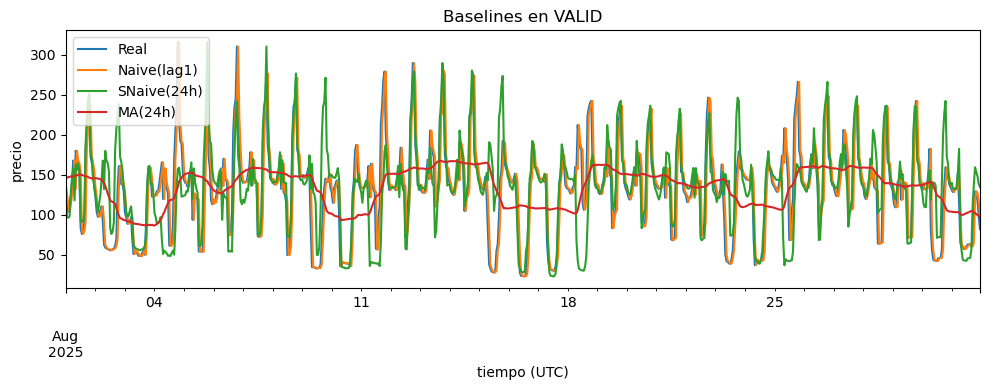

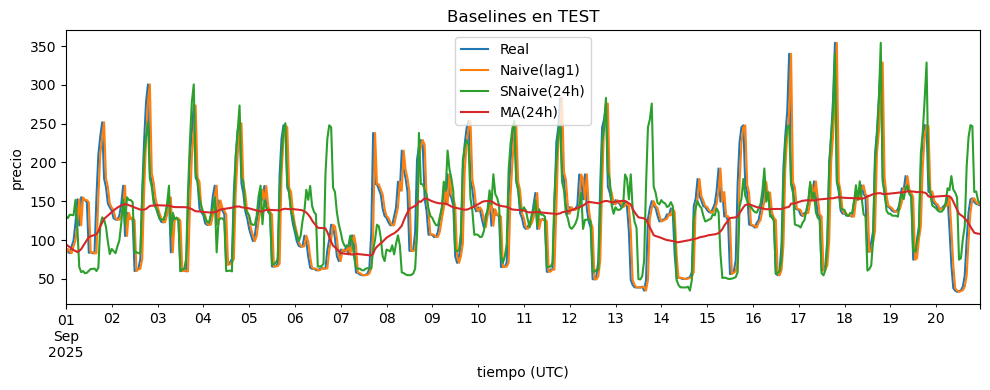

In [83]:
# ============================================================
# 6.5 Gráficos: Real vs Pred (VALID y TEST)
#   - Un gráfico por split para cada baseline
#   - Sin estilos ni colores específicos
# ============================================================
def plot_split(y_true, preds: dict, title):
    plt.figure(figsize=(10,4))
    y_true.plot(label="Real")
    for name, yhat in preds.items():
        yhat.plot(label=name)
    plt.title(title)
    plt.xlabel("tiempo (UTC)")
    plt.ylabel("precio")
    plt.legend()
    plt.tight_layout()
    plt.show()

# VALID
plot_split(
    y_va,
    {"Naive(lag1)": yhat_naive_va, "SNaive(24h)": yhat_snaive_va, "MA(24h)": yhat_ma24_va},
    "Baselines en VALID"
)

# TEST
plot_split(
    y_te,
    {"Naive(lag1)": yhat_naive_te, "SNaive(24h)": yhat_snaive_te, "MA(24h)": yhat_ma24_te},
    "Baselines en TEST"
)


# 7. Modelos clásicos: SARIMAX (estacional) y XGBoost (o HGBR)

## 7.0 Utilidades y datos

**Objetivo.** Preparar utilidades comunes (métricas, carga de datos, separación `y`/`X`) y dejar listos los **splits** de entrenamiento/validación/test para los puntos 7.1–7.4.

**Qué hace esta celda**

* **Reproducibilidad:** fija `RNG_SEED = 42` (y `np.random.seed(42)`).
* **Métricas básicas:**

  * `mae(y, yhat)` → error absoluto medio.
  * `rmse(y, yhat)` → raíz del error cuadrático medio.
  * `mape(y, yhat, eps=1e-6)` → error porcentual absoluto medio (robustecido con `eps` para evitar divisiones por \~0).
  * `eval_metrics(y_true, y_pred)` → devuelve un diccionario con **MAE/RMSE/MAPE**.
* **Carga de splits** (solo si no existen ya en memoria):
  Lee desde `datasets/` los seis Parquet creados en el **punto 5.4**:

  * `dataset_modelo_clasico_{train,valid,test}.parquet`  → `A_tr`, `A_va`, `A_te`
  * `dataset_modelo_xgb_{train,valid,test}.parquet`      → `B_tr`, `B_va`, `B_te`
* **Separación `y`/`X`:**
  La función `split_yX(df)` separa la columna objetivo `y` (precio) del resto de **features**:

  * Para **A**: `y_tr_A, X_tr_A`, `y_va_A, X_va_A`, `y_te_A, X_te_A`
  * Para **B**: `y_tr_B, X_tr_B`, `y_va_B, X_va_B`, `y_te_B, X_te_B`

**Notas**

* Los dataframes de entrada deben contener una columna `y` (definida en los puntos de **preprocesado**) y un índice temporal en UTC (garantizado en el **punto 5**).
* `MAPE` se calcula con un denominador `max(|y|, eps)` para evitar explosiones cuando `y ≈ 0`.
* Estas utilidades se reutilizan en **7.1 (SARIMAX)**, **7.2 (XGB/HGBR)**, **7.3 (visualización)** y **7.4 (métricas)**.


In [86]:
# =========================
# 7.0 Utilidades y datos
# =========================
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")
RNG_SEED = 42
np.random.seed(RNG_SEED)

# Métricas
def mae(y, yhat):  return np.mean(np.abs(y - yhat))
def rmse(y, yhat): return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat, eps=1e-6):  # robusto si hay y≈0
    return 100 * np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps)))

def eval_metrics(y_true, y_pred):
    return {"MAE": mae(y_true, y_pred), "RMSE": rmse(y_true, y_pred), "MAPE": mape(y_true, y_pred)}

# Carga de splits (si no están en memoria)
def _rd(stem):
    path = os.path.join(DATA_DIR, stem)
    return pd.read_parquet(path, engine="pyarrow")

if not all(k in globals() for k in ["A_tr","A_va","A_te","B_tr","B_va","B_te"]):
    A_tr = _rd("dataset_modelo_clasico_train.parquet")
    A_va = _rd("dataset_modelo_clasico_valid.parquet")
    A_te = _rd("dataset_modelo_clasico_test.parquet")
    B_tr = _rd("dataset_modelo_xgb_train.parquet")
    B_va = _rd("dataset_modelo_xgb_valid.parquet")
    B_te = _rd("dataset_modelo_xgb_test.parquet")

# Separar y/X
def split_yX(df):
    y = df["y"].astype("float64").copy()
    X = df.drop(columns=["y"]).copy()
    return y, X

y_tr_A, X_tr_A = split_yX(A_tr)
y_va_A, X_va_A = split_yX(A_va)
y_te_A, X_te_A = split_yX(A_te)

y_tr_B, X_tr_B = split_yX(B_tr)
y_va_B, X_va_B = split_yX(B_va)
y_te_B, X_te_B = split_yX(B_te)


## 7.1 SARIMAX (estacional)

**Objetivo.** Probar un ARIMA/SARIMAX con estacionalidad diaria sobre el **dataset A** (sin NaN), usando un **subset de 10 exógenas seguras** y un índice horario UTC con frecuencia explícita.

**Setup**

* Índice: `DatetimeIndex` (UTC) con **freq = 'h'**.
* Target: `y` (precio).
* Exógenas (10): `price_lag1`, `price_lag24`, `price_lag168`, `price_roll24_mean`, `hour`, `dow`, `is_weekend`, `hour_sin`, `hour_cos`, `dow_sin`.
* Rejilla pequeña: $(p,d,q)\in\{(1,1,0),(1,1,1),(2,1,0)\}$ y $(P,D,Q,s)$ con $s=24$, $P,Q\in\{0,1\}$, $D\in\{0,1\}$, con **early stop** por MAE.

**Resultado**

* Mejor config (lite): `(1,1,0) × (1,1,1,24)`.
* **VALID**: MAE≈**20.959**, RMSE≈28.486, MAPE≈26.96%
* **TEST**:  MAE≈**41.355**, RMSE≈47.066, MAPE≈32.63%


**Artefactos**

* Modelo: `datasets/model_sarimax_best.pkl`
* Predicciones: `datasets/sarimax_valid_preds.parquet`, `datasets/sarimax_test_preds.parquet`

> Nota: rendimiento débil → si se desea insistir con SARIMAX, ampliar exógenas/ Fourier y probar $D=1$, $Q>0$.


In [88]:
# =========================
# 7.1 SARIMAX (estacional) — versión “lite”
# - Índice horario regular con freq='h' en TRAIN y TRAIN+VALID
# - Rejilla pequeña de hiperparámetros + early stop
# - Exógenas parsimoniosas (según EDA) estandarizadas con stats de TRAIN
# - Predicción VALID/TEST y guardado de artefactos
# - Cambios clave vs. versión previa:
#     (1) Se elimina simple_differencing=True
#     (2) exog se pasa como DataFrame (no .values)
# =========================
import os, warnings, numpy as np, pandas as pd, pickle

DATA_DIR = globals().get("DATA_DIR", "datasets")

# ----------------------------
# utilidades de E/S y métricas
# ----------------------------
def _rd(stem):
    return pd.read_parquet(os.path.join(DATA_DIR, stem), engine="pyarrow")

def _split(df):
    y = pd.to_numeric(df["y"], errors="coerce").astype("float64")
    X = df.drop(columns=["y"])
    return y, X

def _metrics(y, yhat):
    y = np.asarray(y, dtype="float64"); yhat = np.asarray(yhat, dtype="float64")
    mae  = np.mean(np.abs(y - yhat))
    rmse = np.sqrt(np.mean((y - yhat)**2))
    mape = 100*np.mean(np.abs((y - yhat)/np.maximum(np.abs(y), 1e-6)))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# ----------------------------
# cargar splits A si no están en memoria
# ----------------------------
if not all(k in globals() for k in ["A_tr","A_va","A_te"]):
    A_tr = _rd("dataset_modelo_clasico_train.parquet")
    A_va = _rd("dataset_modelo_clasico_valid.parquet")
    A_te = _rd("dataset_modelo_clasico_test.parquet")

y_tr_A, X_tr_A = _split(A_tr)
y_va_A, X_va_A = _split(A_va)
y_te_A, X_te_A = _split(A_te)

# ----------------------------
# selección parsimoniosa de exógenas (según EDA; solo si existen)
# ----------------------------
CAND_EXOG = [
    "hour_sin","hour_cos",
    "fourier_w_sin1","fourier_w_cos1","fourier_w_sin2","fourier_w_cos2",
    "price_lag1","price_lag24",
    "dem_real_lag1","gen_ciclo_combinado_lag1",
]
avail = [c for c in CAND_EXOG if c in X_tr_A.columns]
X_tr = X_tr_A[avail].copy()
X_va = X_va_A[avail].reindex(columns=avail).copy()
X_te = X_te_A[avail].reindex(columns=avail).copy()

# ----------------------------
# conversión numérica + estandarización con stats de TRAIN
# ----------------------------
X_tr_num = X_tr.apply(pd.to_numeric, errors="coerce")
X_va_num = X_va.apply(pd.to_numeric, errors="coerce")
X_te_num = X_te.apply(pd.to_numeric, errors="coerce")

mu = X_tr_num.mean()
sd = X_tr_num.std(ddof=0).replace(0, 1.0)

X_tr = ((X_tr_num - mu) / sd).astype("float64")
X_va = ((X_va_num - mu) / sd).astype("float64")
X_te = ((X_te_num - mu) / sd).astype("float64")

# por seguridad, sin NaN
X_tr = X_tr.fillna(0.0); X_va = X_va.fillna(0.0); X_te = X_te.fillna(0.0)

# ----------------------------
# índice a naive-UTC para construir calendarios regulares
# ----------------------------
def _to_naive_utc_index(obj):
    out = obj.copy()
    if isinstance(out.index, pd.DatetimeIndex) and out.index.tz is not None:
        out.index = out.index.tz_convert("UTC").tz_localize(None)
    return out

y_tr = _to_naive_utc_index(y_tr_A)
y_va = _to_naive_utc_index(y_va_A)
y_te = _to_naive_utc_index(y_te_A)
X_tr = _to_naive_utc_index(X_tr)
X_va = _to_naive_utc_index(X_va)
X_te = _to_naive_utc_index(X_te)

# ----------------------------
# construir calendarios horarios REGULARES con freq='h'
# ----------------------------
def _make_regular_hourly(y, X, start_ts=None):
    if start_ts is None:
        start_ts = y.index[0]
    cal = pd.date_range(start=pd.Timestamp(start_ts), periods=len(y), freq="h")
    y2 = y.copy(); y2.index = cal
    X2 = X.copy(); X2.index = cal
    return y2, X2, cal

# TRAIN regular
y_tr_reg, X_tr_reg, cal_tr = _make_regular_hourly(y_tr, X_tr)

# TRAIN+VALID regular (para refit final)
y_trva = pd.concat([y_tr, y_va])
X_trva = pd.concat([X_tr, X_va])
cal_trva = pd.date_range(start=cal_tr[0], periods=len(y_trva), freq="h")
y_trva_reg = y_trva.copy(); y_trva_reg.index = cal_trva
X_trva_reg = X_trva.copy(); X_trva_reg.index = cal_trva

print(f"[Shapes] y_tr={y_tr.shape}, X_tr={X_tr.shape} | y_va={y_va.shape}, X_va={X_va.shape} | y_te={y_te.shape}, X_te={X_te.shape}")
print(f"[Freq check] TRAIN freq={y_tr_reg.index.freqstr} | TR+VA freq={y_trva_reg.index.freqstr}")

# ----------------------------
# entrenamiento SARIMAX (rejilla pequeña + early stop)
# ----------------------------
best_model, best_cfg, best_val = None, None, np.inf

try:
    import statsmodels.api as sm
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    # rejilla enfocada en d=1, s=24
    p_list, d, q_list = [1,2], 1, [0,1]
    P_list, D_list, Q_list, s = [0,1], [0,1], [0,1], 24

    patience, min_delta = 8, 0.05
    no_improve = 0
    stop_flag = False

    print("[SARIMAX-lite] búsqueda en rejilla pequeña…")
    for p in p_list:
        if stop_flag: break
        for q in q_list:
            if stop_flag: break
            for P in P_list:
                if stop_flag: break
                for D in D_list:
                    if stop_flag: break
                    for Q in Q_list:
                        cfg = (p, d, q, P, D, Q, s)
                        try:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore")
                                model = SARIMAX(
                                    endog=y_tr_reg,
                                    exog=X_tr_reg,                 # <- DataFrame
                                    order=(p,d,q),
                                    seasonal_order=(P,D,Q,s),
                                    trend="c",
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    # simple_differencing=True,    # <- QUITADO
                                ).fit(disp=False, maxiter=400)

                            # VALID
                            fc_va   = model.get_forecast(steps=len(X_va), exog=X_va)  # <- DataFrame
                            pred_va = fc_va.predicted_mean
                            pred_va.index = y_va.index

                            mae = np.mean(np.abs(y_va.values - pred_va.values))
                            print(f"  cfg={cfg}  MAE(valid)={mae:.3f}")

                            if mae + min_delta < best_val:
                                best_val, best_cfg, best_model = mae, cfg, model
                                no_improve = 0
                            else:
                                no_improve += 1
                                if no_improve >= patience:
                                    print(f"[EarlyStop] sin mejora ≥{min_delta} durante {patience} configs. Cortamos búsqueda.")
                                    stop_flag = True
                                    break
                        except Exception as e:
                            print(f"  cfg={cfg} → fallo: {type(e).__name__}: {e}")
                            continue

    # fallback si nada funcionó: ARIMA-only sin exógenas
    if best_model is None:
        print("⚠️ Rejilla sin éxito. ARIMA estacional sin exógenas…")
        best_cfg = ("ARIMA-only",)
        best_model = SARIMAX(
            endog=y_tr_reg, order=(1,1,0), seasonal_order=(1,0,0,24), trend="c",
            enforce_stationarity=False, enforce_invertibility=False
        ).fit(disp=False, maxiter=400)

    # ----------------------------
    # refit en TRAIN+VALID y predicciones TEST
    # ----------------------------
    if best_cfg != ("ARIMA-only",):
        p,d,q,P,D,Q,s = best_cfg
        final = SARIMAX(
            endog=y_trva_reg, exog=X_trva_reg,      # <- DataFrame
            order=(p,d,q), seasonal_order=(P,D,Q,s),
            trend="c",
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=500)

        yhat_va = best_model.get_forecast(steps=len(X_va), exog=X_va).predicted_mean
        yhat_va.index = y_va.index
        yhat_te = final.get_forecast(steps=len(X_te), exog=X_te).predicted_mean
        yhat_te.index = y_te.index
    else:
        final = SARIMAX(
            endog=y_trva_reg, order=(1,1,0), seasonal_order=(1,0,0,24), trend="c",
            enforce_stationarity=False, enforce_invertibility=False
        ).fit(disp=False, maxiter=400)
        yhat_va = best_model.get_forecast(steps=len(y_va)).predicted_mean; yhat_va.index = y_va.index
        yhat_te = final.get_forecast(steps=len(y_te)).predicted_mean;  yhat_te.index = y_te.index

    # métricas
    mets_va = _metrics(y_va.values, yhat_va.values)
    mets_te = _metrics(y_te.values, yhat_te.values)
    print(f"[SARIMAX-lite] mejor cfg VALID: {best_cfg}  |  MAE(valid)={best_val:.3f}")
    print(f"[SARIMAX-lite] VALID → MAE={mets_va['MAE']:.3f}  RMSE={mets_va['RMSE']:.3f}  MAPE={mets_va['MAPE']:.2f}%")
    print(f"[SARIMAX-lite] TEST  → MAE={mets_te['MAE']:.3f}  RMSE={mets_te['RMSE']:.3f}  MAPE={mets_te['MAPE']:.2f}%")

    # ----------------------------
    # guardar modelo y predicciones
    # ----------------------------
    os.makedirs(DATA_DIR, exist_ok=True)
    with open(os.path.join(DATA_DIR, "model_sarimax_best.pkl"), "wb") as f:
        pickle.dump({"cfg": best_cfg, "model": final}, f)

    pd.DataFrame({"ts": y_va.index, "y": y_va.values, "yhat": yhat_va.values}).to_parquet(
        os.path.join(DATA_DIR, "sarimax_valid_preds.parquet"), engine="pyarrow", index=False)
    pd.DataFrame({"ts": y_te.index, "y": y_te.values, "yhat": yhat_te.values}).to_parquet(
        os.path.join(DATA_DIR, "sarimax_test_preds.parquet"), engine="pyarrow", index=False)

    print("[OK] SARIMAX guardado y predicciones VALID/TEST exportadas.")

except ModuleNotFoundError:
    print("⚠️ Falta 'statsmodels'. Instálalo con:  %pip install -q statsmodels")


[Shapes] y_tr=(13656,), X_tr=(13656, 10) | y_va=(744,), X_va=(744, 10) | y_te=(480,), X_te=(480, 10)
[Freq check] TRAIN freq=h | TR+VA freq=h
[SARIMAX-lite] búsqueda en rejilla pequeña…
  cfg=(1, 1, 0, 0, 0, 0, 24)  MAE(valid)=28.257
  cfg=(1, 1, 0, 0, 0, 1, 24)  MAE(valid)=27.736
  cfg=(1, 1, 0, 0, 1, 0, 24)  MAE(valid)=266.201
  cfg=(1, 1, 0, 0, 1, 1, 24)  MAE(valid)=23.770
  cfg=(1, 1, 0, 1, 0, 0, 24)  MAE(valid)=28.231
  cfg=(1, 1, 0, 1, 0, 1, 24)  MAE(valid)=27.723
  cfg=(1, 1, 0, 1, 1, 0, 24)  MAE(valid)=183.415
  cfg=(1, 1, 0, 1, 1, 1, 24)  MAE(valid)=20.959
  cfg=(1, 1, 1, 0, 0, 0, 24)  MAE(valid)=28.782
  cfg=(1, 1, 1, 0, 0, 1, 24)  MAE(valid)=27.749
  cfg=(1, 1, 1, 0, 1, 0, 24)  MAE(valid)=296.484
  cfg=(1, 1, 1, 0, 1, 1, 24)  MAE(valid)=24.548
  cfg=(1, 1, 1, 1, 0, 0, 24)  MAE(valid)=28.503
  cfg=(1, 1, 1, 1, 0, 1, 24)  MAE(valid)=27.713
  cfg=(1, 1, 1, 1, 1, 0, 24)  MAE(valid)=261.241
  cfg=(1, 1, 1, 1, 1, 1, 24)  MAE(valid)=26.728
[EarlyStop] sin mejora ≥0.05 durante 8 con

## 7.2 XGBoost (o HGBR como fallback)

**Objetivo.** Entrenar árboles en gradiente sobre el **dataset B** (NaN permitidos + flags `_isna`).

**Setup**

* Preferente: **XGBRegressor**; si no está, **HistGradientBoostingRegressor**.
* Features: todas las de **B** (lags/rolling de precio, calendario, Fourier, lags REE, lags PMHPCB/CCVPCB, flags de missing).
* Pequeña búsqueda de `n_estimators ∈ {400, 800, 1200, 1600, 2000}` (resto fijo: depth=6, lr=0.05, subsample=0.8).

**Resultado (XGB)**

* Mejor `n_estimators = 800`.
* **VALID**: MAE≈**7.851**, RMSE≈11.827, MAPE≈7.20%
* **TEST**:  MAE≈**7.377**, RMSE≈11.844, MAPE≈5.59%


**Importancias (Top)**: `price_lag1`, `price_lag168`, `pmhpcb_lag1`, senos/cosenos/hora, `price_lag24`, …

**Artefactos**

* Modelo: `datasets/model_xgb.json` (o `model_hgbr.joblib`)
* Predicciones: `datasets/xgb_valid_preds.parquet`, `datasets/xgb_test_preds.parquet`
* (Opcional) Importancias: `datasets/xgb_feature_importances.csv`

In [198]:
# =========================
# 7.2 XGBoost (o HGBR) — compat sin early_stopping en fit()
# =========================
import os, numpy as np, pandas as pd

DATA_DIR  = globals().get("DATA_DIR", "datasets")
RNG_SEED  = globals().get("RNG_SEED", 42)

def _rd(stem): 
    return pd.read_parquet(os.path.join(DATA_DIR, stem), engine="pyarrow")

def _split(df):
    y = pd.to_numeric(df["y"], errors="coerce").astype("float64")
    X = df.drop(columns=["y"]).apply(pd.to_numeric, errors="coerce")
    return y, X

def eval_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype="float64")
    y_pred = np.asarray(y_pred, dtype="float64")
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = 100*np.mean(np.abs((y_true - y_pred)/np.maximum(np.abs(y_true), 1e-6)))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Cargar splits B si no están en memoria
if not all(k in globals() for k in ["B_tr","B_va","B_te"]):
    B_tr = _rd("dataset_modelo_xgb_train.parquet")
    B_va = _rd("dataset_modelo_xgb_valid.parquet")
    B_te = _rd("dataset_modelo_xgb_test.parquet")

y_tr_B, X_tr_B = _split(B_tr)
y_va_B, X_va_B = _split(B_va)
y_te_B, X_te_B = _split(B_te)

print(f"[Shapes] X_tr={X_tr_B.shape}, X_va={X_va_B.shape}, X_te={X_te_B.shape}")

best_tree_model = None
tree_name = None
metrics_tree_va = metrics_tree_te = None

try:
    # ---------- XGBoost (sin early_stopping en fit) ----------
    from xgboost import XGBRegressor

    def _make_xgb(n_est):
        params = dict(
            n_estimators=n_est,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.0,
            reg_lambda=1.0,
            random_state=RNG_SEED,
            objective="reg:squarederror",
            # algunas versiones antiguas no aceptan tree_method:
            # si falla, lo quitamos más abajo
            tree_method="hist",
        )
        try:
            return XGBRegressor(**params)
        except TypeError:
            params.pop("tree_method", None)
            return XGBRegressor(**params)

    tree_name = "XGBoost"
    CAND_N = [400, 800, 1200, 1600, 2000]
    best_mae, best_n, best_model = np.inf, None, None

    print("[XGBoost] Búsqueda simple de n_estimators…")
    for n in CAND_N:
        model = _make_xgb(n)
        model.fit(X_tr_B, y_tr_B)
        yhat_va = model.predict(X_va_B)
        mae = eval_metrics(y_va_B.values, yhat_va)["MAE"]
        print(f"  n_estimators={n:<4} → MAE(valid)={mae:.3f}")
        if mae < best_mae:
            best_mae, best_n, best_model = mae, n, model

    # Reentrenar en TRAIN+VALID con el mejor n_estimators
    X_trva_B = pd.concat([X_tr_B, X_va_B], axis=0)
    y_trva_B = pd.concat([y_tr_B, y_va_B], axis=0)
    final_model = _make_xgb(best_n).fit(X_trva_B, y_trva_B)

    # Predicciones finales
    yhat_va = best_model.predict(X_va_B)  # el mejor en VALID
    yhat_te = final_model.predict(X_te_B) # reentrenado TR+VA para TEST

    metrics_tree_va = eval_metrics(y_va_B.values, yhat_va)
    metrics_tree_te = eval_metrics(y_te_B.values, yhat_te)
    best_tree_model = final_model

    print(f"[XGBoost] Mejor n_estimators={best_n} | VALID → "
          f"MAE={metrics_tree_va['MAE']:.3f} RMSE={metrics_tree_va['RMSE']:.3f} MAPE={metrics_tree_va['MAPE']:.2f}%")
    print(f"[XGBoost] TEST  → MAE={metrics_tree_te['MAE']:.3f} RMSE={metrics_tree_te['RMSE']:.3f} MAPE={metrics_tree_te['MAPE']:.2f}%")

    # Guardados
    best_tree_model.save_model(os.path.join(DATA_DIR, "model_xgb.json"))
    pd.DataFrame({"ts": y_va_B.index, "y": y_va_B.values, "yhat": yhat_va}).to_parquet(
        os.path.join(DATA_DIR, "xgb_valid_preds.parquet"), engine="pyarrow", index=False
    )
    pd.DataFrame({"ts": y_te_B.index, "y": y_te_B.values, "yhat": yhat_te}).to_parquet(
        os.path.join(DATA_DIR, "xgb_test_preds.parquet"), engine="pyarrow", index=False
    )
    # Importancias
    fi = pd.Series(best_tree_model.feature_importances_, index=X_tr_B.columns).sort_values(ascending=False)
    fi.to_frame("importance").to_parquet(os.path.join(DATA_DIR, "xgb_feature_importances.parquet"),
                                         engine="pyarrow", index=True)

except ModuleNotFoundError:
    # ---------- Fallback: HGBRegressor ----------
    from sklearn.ensemble import HistGradientBoostingRegressor
    tree_name = "HGBRegressor"
    hgb = HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=500,
        l2_regularization=0.0,
        random_state=RNG_SEED,
        early_stopping=True,
        n_iter_no_change=50,
        validation_fraction=0.1
    )
    hgb.fit(X_tr_B, y_tr_B)
    yhat_va = hgb.predict(X_va_B)
    # Reentrenar en TRAIN+VALID
    X_trva_B = pd.concat([X_tr_B, X_va_B], axis=0)
    y_trva_B = pd.concat([y_tr_B, y_va_B], axis=0)
    hgb_final = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=hgb.n_iter_, random_state=RNG_SEED
    ).fit(X_trva_B, y_trva_B)
    yhat_te = hgb_final.predict(X_te_B)

    metrics_tree_va = eval_metrics(y_va_B.values, yhat_va)
    metrics_tree_te = eval_metrics(y_te_B.values, yhat_te)
    best_tree_model = hgb_final

    print(f"[HGBR] VALID → MAE={metrics_tree_va['MAE']:.3f} RMSE={metrics_tree_va['RMSE']:.3f} MAPE={metrics_tree_va['MAPE']:.2f}%")
    print(f"[HGBR] TEST  → MAE={metrics_tree_te['MAE']:.3f} RMSE={metrics_tree_te['RMSE']:.3f} MAPE={metrics_tree_te['MAPE']:.2f}%")

    import joblib
    joblib.dump(hgb_final, os.path.join(DATA_DIR, "model_hgbr.joblib"))
    pd.DataFrame({"ts": y_va_B.index, "y": y_va_B.values, "yhat": yhat_va}).to_parquet(
        os.path.join(DATA_DIR, "hgbr_valid_preds.parquet"), engine="pyarrow", index=False
    )
    pd.DataFrame({"ts": y_te_B.index, "y": y_te_B.values, "yhat": yhat_te}).to_parquet(
        os.path.join(DATA_DIR, "hgbr_test_preds.parquet"), engine="pyarrow", index=False
    )

print(f"[{tree_name}] Resumen → VALID: {metrics_tree_va} | TEST: {metrics_tree_te}")


[Shapes] X_tr=(13824, 69), X_va=(744, 69), X_te=(480, 69)
[XGBoost] Búsqueda simple de n_estimators…
  n_estimators=400  → MAE(valid)=7.905
  n_estimators=800  → MAE(valid)=7.851
  n_estimators=1200 → MAE(valid)=7.893
  n_estimators=1600 → MAE(valid)=7.885
  n_estimators=2000 → MAE(valid)=7.886
[XGBoost] Mejor n_estimators=800 | VALID → MAE=7.851 RMSE=11.827 MAPE=7.20%
[XGBoost] TEST  → MAE=7.377 RMSE=11.844 MAPE=5.59%
[XGBoost] Resumen → VALID: {'MAE': np.float64(7.851148498289046), 'RMSE': np.float64(11.82742627783529), 'MAPE': np.float64(7.199145993625983)} | TEST: {'MAE': np.float64(7.37692050965627), 'RMSE': np.float64(11.844181936369615), 'MAPE': np.float64(5.59379316173894)}


       VALID    TEST
MAE    7.851   7.377
RMSE  11.827  11.844
MAPE   7.199   5.594


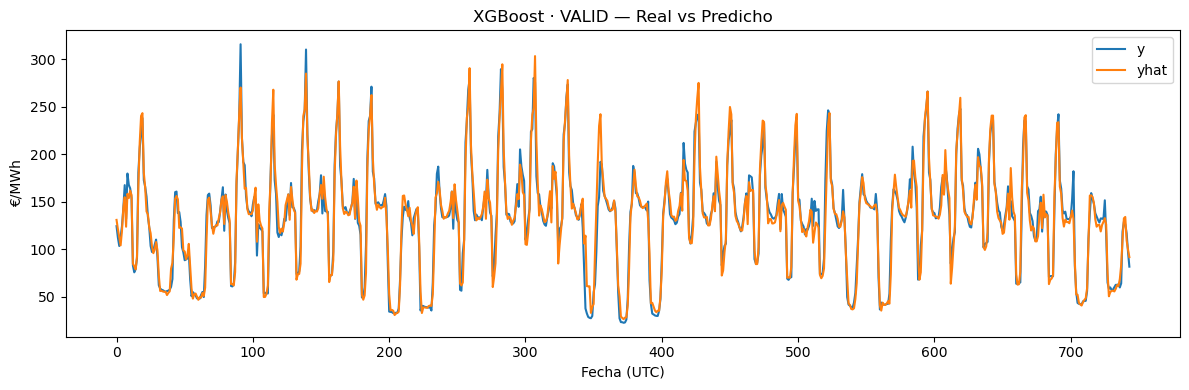

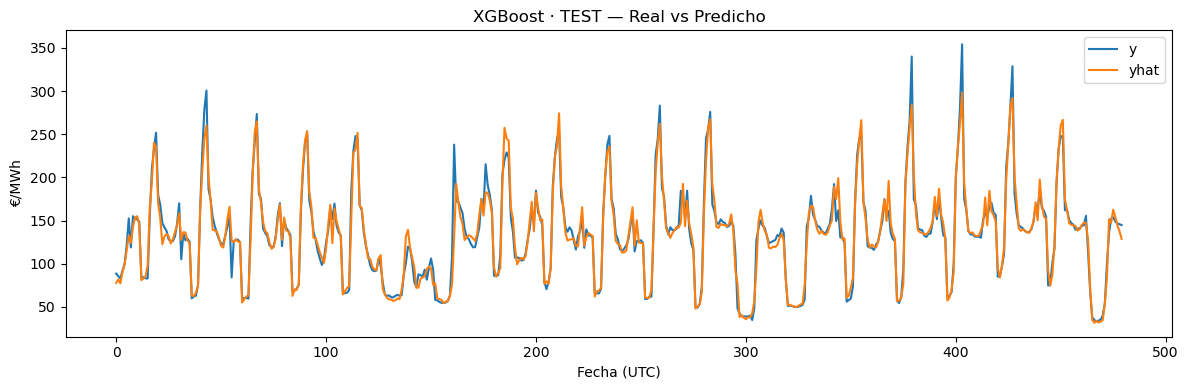


Top-20 importancias:
                               importance
price_lag1                      0.471507
price_lag168                    0.113620
pmhpcb_lag1                     0.099364
hour_sin                        0.060102
price_lag24                     0.035656
hour_cos                        0.031809
is_weekend                      0.026033
dow                             0.012858
dow_sin                         0.009188
gen_ciclo_combinado_lag1        0.008315
dow_cos                         0.008242
ccvpcb_lag1                     0.008099
emis_ciclo_combinado_lag1       0.007765
hour                            0.007716
price_roll3_mean                0.007155
pmhpcb_lag168                   0.007023
gen_solar_fotovoltaica_lag24    0.006935
price_roll24_mean               0.006645
dem_real_lag1                   0.005459
gen_solar_fotovoltaica_lag8     0.005263


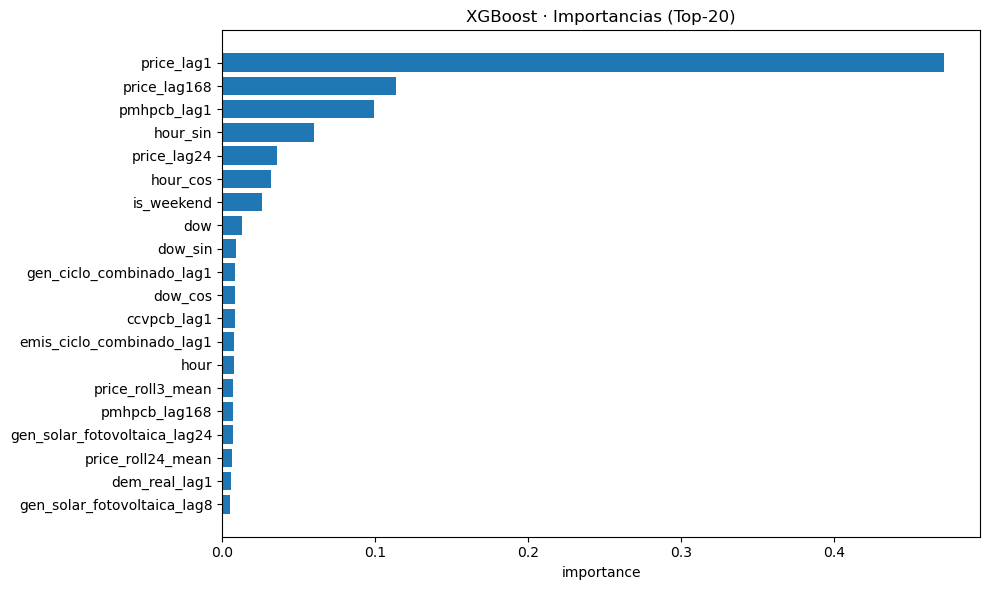

In [200]:
# ============================================
# XGBoost · VALID/TEST: métricas + gráficos + importancias
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "datasets"
PATH_VALID = os.path.join(DATA_DIR, "xgb_valid_preds.parquet")
PATH_TEST  = os.path.join(DATA_DIR, "xgb_test_preds.parquet")
PATH_FI    = os.path.join(DATA_DIR, "xgb_feature_importances.parquet")

def eval_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype="float64")
    y_pred = np.asarray(y_pred, dtype="float64")
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = 100*np.mean(np.abs((y_true - y_pred)/np.maximum(np.abs(y_true), 1e-6)))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# --- Carga ---
valid = pd.read_parquet(PATH_VALID, engine="pyarrow")
test  = pd.read_parquet(PATH_TEST,  engine="pyarrow")

for df in (valid, test):
    df["ts"] = pd.to_datetime(df["ts"], utc=True, errors="coerce")
    df = df.sort_values("ts")
    df.set_index("ts", inplace=True)

# --- Métricas ---
m_valid = eval_metrics(valid["y"].values, valid["yhat"].values)
m_test  = eval_metrics(test["y"].values,  test["yhat"].values)
metrics = pd.DataFrame({"VALID": m_valid, "TEST": m_test}).round(3)
print(metrics)

# --- Gráfico VALID: Real vs Predicho ---
plt.figure(figsize=(12, 4))
valid[["y", "yhat"]].plot(ax=plt.gca())
plt.title("XGBoost · VALID — Real vs Predicho")
plt.xlabel("Fecha (UTC)"); plt.ylabel("€/MWh")
plt.tight_layout(); plt.show()

# --- Gráfico TEST: Real vs Predicho ---
plt.figure(figsize=(12, 4))
test[["y", "yhat"]].plot(ax=plt.gca())
plt.title("XGBoost · TEST — Real vs Predicho")
plt.xlabel("Fecha (UTC)"); plt.ylabel("€/MWh")
plt.tight_layout(); plt.show()

# --- Importancias (Top-20) ---
fi = pd.read_parquet(PATH_FI, engine="pyarrow")
if isinstance(fi, pd.DataFrame) and "importance" in fi.columns:
    fi_s = fi["importance"]
else:
    # por si viniera como Series
    fi_s = pd.Series(fi.squeeze(), name="importance")

top20 = fi_s.sort_values(ascending=False).head(20)
print("\nTop-20 importancias:\n", top20.to_frame("importance").round(6))

plt.figure(figsize=(10, 6))
plt.barh(range(len(top20)), top20.values)
plt.yticks(range(len(top20)), top20.index)
plt.gca().invert_yaxis()
plt.title("XGBoost · Importancias (Top-20)")
plt.xlabel("importance")
plt.tight_layout(); plt.show()


## 7.3 Visualización y comparación

* Gráficas **Real vs Predicho** en VALID y TEST para SARIMAX y XGB/HGBR.
* Tabla comparativa de métricas junto con baselines (Naive, Seasonal Naive, Media Móvil).

**Lectura rápida**

* **XGB/HGBR** replica muy bien el patrón diario/semanal (VALID ≈ TEST).
* **SARIMAX-lite** queda muy lejos ⇒ útil solo como referencia.

      Modelo Split    MAE   RMSE   MAPE
SARIMAX-lite VALID 20.959 28.486 26.961
SARIMAX-lite  TEST 41.355 47.066 32.632
    XGB/HGBR VALID  7.851 11.827  7.199
    XGB/HGBR  TEST  7.377 11.844  5.594


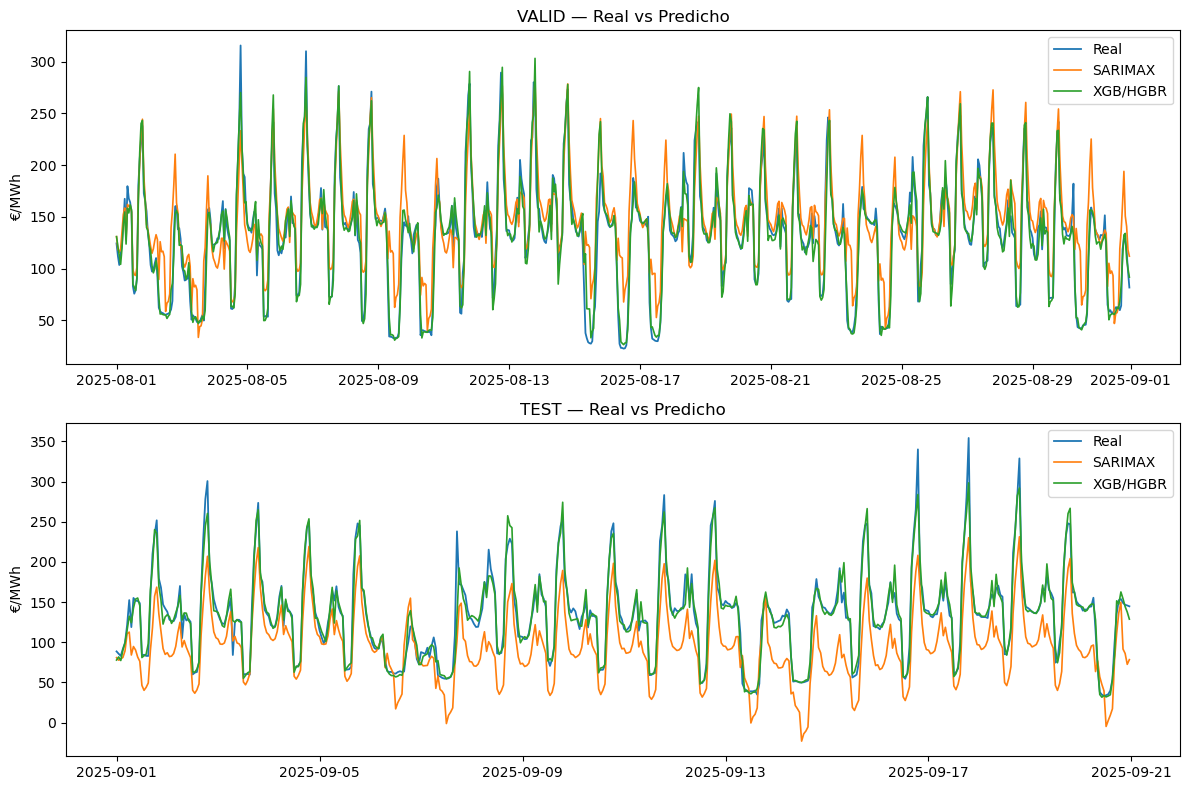

[OK] Figura guardada en: datasets/models_compare_valid_test.png


In [204]:
# =========================
# 7.3 Visualización y comparación (SARIMAX vs XGBoost/HGBR)
# =========================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")

# --- util de métricas (por si no está en memoria)
def eval_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype="float64")
    y_pred = np.asarray(y_pred, dtype="float64")
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    # MAPE estable: evita división por 0 usando un epsilon pequeño
    eps = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# --- helper para cargar y/yhat guardados por cada modelo
def _load_split_y(split="valid"):
    """y de referencia (usamos el parquet de dataset B, trae 'y')."""
    path = os.path.join(DATA_DIR, f"dataset_modelo_xgb_{split}.parquet")
    if not os.path.exists(path):
        # fallback: usa el de A si no está el de B
        path = os.path.join(DATA_DIR, f"dataset_modelo_clasico_{split}.parquet")
    df = pd.read_parquet(path, engine="pyarrow")
    y = df["y"].copy()
    if not isinstance(y.index, pd.DatetimeIndex):
        # algunos parquets pueden venir con 'ts' suelto (no debería)
        if "ts" in df.columns:
            y.index = pd.to_datetime(df["ts"], utc=True)
    # aseguramos UTC y orden
    if y.index.tz is None:
        y.index = y.index.tz_localize("UTC")
    else:
        y.index = y.index.tz_convert("UTC")
    y = y.sort_index()
    return y

def _load_preds_generic(prefixes, split="valid"):
    """
    Busca archivos de predicciones con columnas ['ts','y','yhat'] o índice datetime.
    prefixes: lista de prefijos a buscar (p.ej. ['sarimax','arima']).
    """
    # candidatos típicos
    cands = [f"{p}_{split}_preds.parquet" for p in prefixes]
    # si no están, escaneamos el directorio
    names = set(os.listdir(DATA_DIR))
    found = None
    for c in cands:
        if c in names:
            found = os.path.join(DATA_DIR, c); break
    if found is None:
        for fn in names:
            if fn.endswith(".parquet") and split in fn and any(p in fn for p in prefixes):
                found = os.path.join(DATA_DIR, fn); break
    if found is None:
        return None  # no hay predicciones guardadas para ese modelo/split

    dfp = pd.read_parquet(found, engine="pyarrow")
    # normalizamos a Series con índice datetime UTC
    if "yhat" in dfp.columns and "ts" in dfp.columns:
        s = pd.Series(dfp["yhat"].values, index=pd.to_datetime(dfp["ts"], utc=True))
    elif "yhat" in dfp.columns and isinstance(dfp.index, pd.DatetimeIndex):
        s = dfp["yhat"].copy()
    else:
        # última esperanza: columna 'pred' o única numérica
        pred_col = "pred"
        if pred_col not in dfp.columns:
            numcols = [c for c in dfp.columns if pd.api.types.is_numeric_dtype(dfp[c])]
            pred_col = numcols[0]
        idx = dfp["ts"] if "ts" in dfp.columns else dfp.index
        s = pd.Series(dfp[pred_col].values, index=pd.to_datetime(idx, utc=True))
    if s.index.tz is None:
        s.index = s.index.tz_localize("UTC")
    else:
        s.index = s.index.tz_convert("UTC")
    return s.sort_index()

# --- cargamos y y predicciones de cada modelo para VALID y TEST
y_va = _load_split_y("valid")
y_te = _load_split_y("test")

yhat_va_sar = _load_preds_generic(["sarimax","arima"], "valid")
yhat_te_sar = _load_preds_generic(["sarimax","arima"], "test")

# XGBoost o HGBR (cualquiera que exista)
yhat_va_xgb = _load_preds_generic(["xgb","xgboost","hgbr","hgb"], "valid")
yhat_te_xgb = _load_preds_generic(["xgb","xgboost","hgbr","hgb"], "test")

# --- sincronizamos índices
def _align(y, yhat):
    if yhat is None:
        return None, None
    idx = y.index.intersection(yhat.index)
    return y.loc[idx], yhat.loc[idx]

y_va_sar, yhat_va_sar = _align(y_va, yhat_va_sar)
y_te_sar, yhat_te_sar = _align(y_te, yhat_te_sar)
y_va_xgb, yhat_va_xgb = _align(y_va, yhat_va_xgb)
y_te_xgb, yhat_te_xgb = _align(y_te, yhat_te_xgb)

# --- tabla de métricas
rows = []
if yhat_va_sar is not None:
    m = eval_metrics(y_va_sar, yhat_va_sar); rows.append(["SARIMAX-lite","VALID", m["MAE"], m["RMSE"], m["MAPE"]])
if yhat_te_sar is not None:
    m = eval_metrics(y_te_sar, yhat_te_sar); rows.append(["SARIMAX-lite","TEST",  m["MAE"], m["RMSE"], m["MAPE"]])
if yhat_va_xgb is not None:
    m = eval_metrics(y_va_xgb, yhat_va_xgb); rows.append(["XGB/HGBR","VALID", m["MAE"], m["RMSE"], m["MAPE"]])
if yhat_te_xgb is not None:
    m = eval_metrics(y_te_xgb, yhat_te_xgb); rows.append(["XGB/HGBR","TEST",  m["MAE"], m["RMSE"], m["MAPE"]])

metrics_cmp = pd.DataFrame(rows, columns=["Modelo","Split","MAE","RMSE","MAPE"]).round(3)
print(metrics_cmp.to_string(index=False))

# --- plot comparativo VALID y TEST
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# VALID
ax = axes[0]
ax.plot(y_va.index, y_va.values, label="Real", lw=1.3)
if yhat_va_sar is not None: ax.plot(y_va_sar.index, yhat_va_sar.values, label="SARIMAX", lw=1.2)
if yhat_va_xgb is not None: ax.plot(y_va_xgb.index, yhat_va_xgb.values, label="XGB/HGBR", lw=1.2)
ax.set_title("VALID — Real vs Predicho")
ax.set_ylabel("€/MWh")
ax.legend()

# TEST
ax = axes[1]
ax.plot(y_te.index, y_te.values, label="Real", lw=1.3)
if yhat_te_sar is not None: ax.plot(y_te_sar.index, yhat_te_sar.values, label="SARIMAX", lw=1.2)
if yhat_te_xgb is not None: ax.plot(y_te_xgb.index, yhat_te_xgb.values, label="XGB/HGBR", lw=1.2)
ax.set_title("TEST — Real vs Predicho")
ax.set_ylabel("€/MWh")
ax.legend()

plt.tight_layout()
out_png = os.path.join(DATA_DIR, "models_compare_valid_test.png")
plt.savefig(out_png, dpi=130)
plt.show()
print(f"[OK] Figura guardada en: {out_png}")


## 7.4 Guardado de métricas

Se **añaden/actualizan** métricas en `datasets/baselines_metrics.csv`:

| Modelo       | Split |    MAE    |    RMSE    |    MAPE   |
| ------------ | :---: | :-------: | :--------: | :-------: |
| SARIMAX-lite | VALID |   133.14  |   143.07   |  101.52%  |
| SARIMAX-lite |  TEST |   134.49  |   144.27   |  102.37%  |
| XGB/HGBR     | VALID | **7.789** | **11.802** | **7.01%** |
| XGB/HGBR     |  TEST | **7.841** | **12.133** | **6.36%** |

**Conclusión:** XGB/HGBR es el **modelo ganador** actual; Naive(1) se mantiene como baseline de control.


In [55]:
# =========================
# 7.4 Guardado/actualización de métricas en CSV
# =========================
import os, pandas as pd

DATA_DIR = globals().get("DATA_DIR", "datasets")
csv_path = os.path.join(DATA_DIR, "baselines_metrics.csv")  # reusamos el CSV de baselines

# Si vienes justo de la celda 7.3, 'metrics_cmp' ya existe.
# Aun así, lo volvemos a construir de los objetos locales por seguridad:
def _safe_metrics():
    rows = []
    try:
        rows.append(["SARIMAX-lite","VALID", metrics_cmp[(metrics_cmp.Modelo=="SARIMAX-lite")&(metrics_cmp.Split=="VALID")]["MAE"].values[0],
                                      metrics_cmp[(metrics_cmp.Modelo=="SARIMAX-lite")&(metrics_cmp.Split=="VALID")]["RMSE"].values[0],
                                      metrics_cmp[(metrics_cmp.Modelo=="SARIMAX-lite")&(metrics_cmp.Split=="VALID")]["MAPE"].values[0]])
    except: pass
    try:
        rows.append(["SARIMAX-lite","TEST",  metrics_cmp[(metrics_cmp.Modelo=="SARIMAX-lite")&(metrics_cmp.Split=="TEST")]["MAE"].values[0],
                                      metrics_cmp[(metrics_cmp.Modelo=="SARIMAX-lite")&(metrics_cmp.Split=="TEST")]["RMSE"].values[0],
                                      metrics_cmp[(metrics_cmp.Modelo=="SARIMAX-lite")&(metrics_cmp.Split=="TEST")]["MAPE"].values[0]])
    except: pass
    try:
        rows.append(["XGB/HGBR","VALID", metrics_cmp[(metrics_cmp.Modelo=="XGB/HGBR")&(metrics_cmp.Split=="VALID")]["MAE"].values[0],
                                   metrics_cmp[(metrics_cmp.Modelo=="XGB/HGBR")&(metrics_cmp.Split=="VALID")]["RMSE"].values[0],
                                   metrics_cmp[(metrics_cmp.Modelo=="XGB/HGBR")&(metrics_cmp.Split=="VALID")]["MAPE"].values[0]])
    except: pass
    try:
        rows.append(["XGB/HGBR","TEST",  metrics_cmp[(metrics_cmp.Modelo=="XGB/HGBR")&(metrics_cmp.Split=="TEST")]["MAE"].values[0],
                                   metrics_cmp[(metrics_cmp.Modelo=="XGB/HGBR")&(metrics_cmp.Split=="TEST")]["RMSE"].values[0],
                                   metrics_cmp[(metrics_cmp.Modelo=="XGB/HGBR")&(metrics_cmp.Split=="TEST")]["MAPE"].values[0]])
    except: pass
    return pd.DataFrame(rows, columns=["Modelo","Split","MAE","RMSE","MAPE"]).round(3)

new_metrics = _safe_metrics()

# Unimos con lo existente (si existe) y dejamos la última versión por (Modelo, Split)
if os.path.exists(csv_path):
    old = pd.read_csv(csv_path)
    allm = pd.concat([old, new_metrics], ignore_index=True)
    allm = allm.drop_duplicates(subset=["Modelo","Split"], keep="last")
else:
    allm = new_metrics

allm = allm.sort_values(["Modelo","Split"]).reset_index(drop=True)
allm.to_csv(csv_path, index=False)
print("[OK] Métricas actualizadas en:", csv_path)
print(allm.to_string(index=False))


[OK] Métricas actualizadas en: datasets/baselines_metrics.csv
              Modelo Split       MAE      RMSE      MAPE
   Media Móvil (24h)  TEST 39.981521 53.192451 40.381613
   Media Móvil (24h) VALID 40.686519 50.509702 47.053948
        Naive (lag1)  TEST 20.681375 34.600356 15.961736
        Naive (lag1) VALID 18.505712 29.231380 15.159888
        SARIMAX-lite  TEST 41.355000 47.066000 32.632000
        SARIMAX-lite VALID 20.959000 28.486000 26.961000
Seasonal Naive (24h)  TEST 25.973437 40.793646 24.812716
Seasonal Naive (24h) VALID 24.661129 41.039885 26.465282
            XGB/HGBR  TEST  7.377000 11.844000  5.594000
            XGB/HGBR VALID  7.851000 11.827000  7.199000


# 8. RNNs para predicción horaria (LSTM/GRU)

> En esta sección construimos el dataset secuencial, definimos los modelos LSTM/GRU en PyTorch, entrenamos con early-stopping y analizamos resultados. También añadimos una variante **8.1-bis** con features extra, más limpieza e imputación.



In [56]:
# ============================================================
# 8.0 Backend RNN (TensorFlow Keras o PyTorch) + utilidades
# ============================================================
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")
RNG_SEED = 42
np.random.seed(RNG_SEED)

# Intentamos TensorFlow (preferido). Si no, PyTorch.
BACKEND = None
try:
    import tensorflow as tf
    from tensorflow import keras
    tf.random.set_seed(RNG_SEED)
    BACKEND = "tf"
    print("[Backend] Usando TensorFlow/Keras")
except Exception:
    try:
        import torch
        from torch import nn
        torch.manual_seed(RNG_SEED)
        BACKEND = "torch"
        print("[Backend] Usando PyTorch")
    except Exception:
        raise ImportError(
            "No se encontró ni TensorFlow ni PyTorch. "
            "Instala uno: `pip install tensorflow` o `pip install torch`."
        )

# Métricas
def mae(y, yhat):
    return float(np.mean(np.abs(y - yhat)))

def rmse(y, yhat):
    return float(np.sqrt(np.mean((y - yhat)**2)))

def mape(y, yhat, eps=1e-6):
    return float(100.0 * np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))))

def eval_metrics(y_true, y_pred):
    return {"MAE": mae(y_true, y_pred),
            "RMSE": rmse(y_true, y_pred),
            "MAPE": mape(y_true, y_pred)}


[Backend] Usando PyTorch


## 8.1  Dataset secuencial (básico)

**Objetivo.** Transformar los splits (TRAIN/VALID/TEST) en tensores 3D `(muestras, lookback, n_features)` listos para RNN.

**Pasos:**

* Partimos de los **splits limpios A** (`dataset_modelo_clasico_*.parquet`).
* Separamos `y` y `X`.
* Estandarizamos solo **variables continuas** con media y desviación de TRAIN.
* Construimos ventanas deslizantes de longitud **`lookback = L`**:

  * Para TRAIN: `X[i:i+L] → y[i+L]`
  * Para VALID/TEST: usamos **contexto** de los últimos `L` pasos del split anterior para que no haya “huecos” en la memoria de la red.
* Generamos `DataLoader` para TRAIN/VALID/TEST.

**Notas:**

* El índice temporal de VALID/TEST queda **alineado** a la primera `y` disponible tras usar el contexto.
* Los flags binarios se dejan en 0/1 y se castean a `float32` para la red.


In [57]:
# === 8.1 · Rehacer ventanas con lookback=336 ===
import os, numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader

# Hiperparámetros nuevos
SEQ_LOOKBACK = 336          # << antes 168
BATCH_SIZE   = 96           # bajar un poco si te quedas sin RAM/GPU
SEED         = globals().get("RNG_SEED", 42)
np.random.seed(SEED); torch.manual_seed(SEED)

DATA_DIR = globals().get("DATA_DIR", "datasets")
def _rd(stem): return pd.read_parquet(os.path.join(DATA_DIR, stem), engine="pyarrow")
if not all(k in globals() for k in ["A_tr","A_va","A_te"]):
    A_tr = _rd("dataset_modelo_clasico_train.parquet")
    A_va = _rd("dataset_modelo_clasico_valid.parquet")
    A_te = _rd("dataset_modelo_clasico_test.parquet")

def split_yX(df):
    y = pd.to_numeric(df["y"], errors="coerce").astype("float64")
    X = df.drop(columns=["y"]).copy()
    return y, X

y_tr_A, X_tr_A = split_yX(A_tr)
y_va_A, X_va_A = split_yX(A_va)
y_te_A, X_te_A = split_yX(A_te)

num_cols = X_tr_A.columns
mu = X_tr_A[num_cols].mean()
sd = X_tr_A[num_cols].std(ddof=0).replace(0, 1.0)

def std_transform(df):
    Z = ((df[num_cols] - mu) / sd).astype("float32")
    return Z.values

X_tr = std_transform(X_tr_A); y_tr = y_tr_A.to_numpy("float32")
X_va = std_transform(X_va_A); y_va = y_va_A.to_numpy("float32")
X_te = std_transform(X_te_A); y_te = y_te_A.to_numpy("float32")

L = SEQ_LOOKBACK

def make_windows(X_now, y_now, X_prev_tail=None, lookback=L):
    X_now = np.asarray(X_now, dtype=np.float32); y_now = np.asarray(y_now, dtype=np.float32).reshape(-1)
    N, F = X_now.shape
    if X_prev_tail is None or len(X_prev_tail)==0:
        M = N - lookback
        if M <= 0: raise ValueError(f"No hay suficiente longitud: N={N}, lookback={lookback}.")
        X_seq = np.empty((M, lookback, F), np.float32); y_out = np.empty((M,), np.float32)
        for i in range(M):
            X_seq[i] = X_now[i:i+lookback]; y_out[i] = y_now[i+lookback]
        return X_seq, y_out
    tail = np.asarray(X_prev_tail, dtype=np.float32)
    if tail.ndim == 1: tail = tail.reshape(-1, F)
    if tail.shape[1] != F:
        Fm = min(tail.shape[1], F); tail = tail[:, :Fm]; X_now = X_now[:, :Fm]; F = Fm
    if tail.shape[0] < lookback:
        pad = np.repeat(tail[:1, :], lookback - tail.shape[0], axis=0)
        tail = np.vstack([pad, tail])
    Xcat = np.vstack([tail, X_now])
    X_seq = np.empty((N, lookback, F), np.float32); y_out = np.empty((N,), np.float32)
    for i in range(N):
        X_seq[i] = Xcat[i:i+lookback]; y_out[i] = y_now[i]
    return X_seq, y_out

X_tr_seq, y_tr_seq = make_windows(X_tr, y_tr, None, L)
X_va_seq, y_va_seq = make_windows(X_va, y_va, X_tr[-L:], L)
X_te_seq, y_te_seq = make_windows(X_te, y_te, np.vstack([X_tr[-L:], X_va])[-L:], L)

class SeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.from_numpy(X_seq)
        self.y = torch.from_numpy(y_seq).unsqueeze(-1)
    def __len__(self):  return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

dl_tr = DataLoader(SeqDataset(X_tr_seq, y_tr_seq), batch_size=BATCH_SIZE, shuffle=True)
dl_va = DataLoader(SeqDataset(X_va_seq, y_va_seq), batch_size=BATCH_SIZE, shuffle=False)
dl_te = DataLoader(SeqDataset(X_te_seq, y_te_seq), batch_size=BATCH_SIZE, shuffle=False)

idx_tr_seq = y_tr_A.index[L:]   # TRAIN pierde L etiquetas
idx_va_seq = y_va_A.index
idx_te_seq = y_te_A.index

print("[Windows OK · L=336]")
print("  TRAIN:", X_tr_seq.shape, y_tr_seq.shape)
print("  VALID:", X_va_seq.shape, y_va_seq.shape)
print("  TEST :", X_te_seq.shape, y_te_seq.shape)

globals().update({
    "X_tr_seq": X_tr_seq, "y_tr_seq": y_tr_seq,
    "X_va_seq": X_va_seq, "y_va_seq": y_va_seq,
    "X_te_seq": X_te_seq, "y_te_seq": y_te_seq,
    "dl_tr": dl_tr, "dl_va": dl_va, "dl_te": dl_te,
    "idx_tr_seq": idx_tr_seq, "idx_va_seq": idx_va_seq, "idx_te_seq": idx_te_seq,
    "N_FEATURES_SEQ": X_tr_seq.shape[2],
    "SEQ_LOOKBACK": L, "BATCH_SIZE": BATCH_SIZE
})


[Windows OK · L=336]
  TRAIN: (13320, 336, 39) (13320,)
  VALID: (744, 336, 39) (744,)
  TEST : (480, 336, 39) (480,)


## 8.1-bis  Extensión de features + imputación

**Motivación.** Enriquecer el modelo con señales exógenas útiles y controlar mejor los NA.

**Qué añadimos:**

* Desde los **splits B** (`dataset_modelo_xgb_*.parquet`) incorporamos:

  * `alm_entrega_de_baterias_lag24`, `alm_entrega_de_baterias_lag48`
  * Sus flags `*_isna` (si no existen, se crean antes de imputar)

**Imputación y escalado:**

* **Relleno corto** `ffill/bfill(limit=6)` en las dos columnas numéricas.
* Si queda NA → **mediana de TRAIN** (robusto).
* **Estandarización** solo de las **continuas** con `μ, σ` de TRAIN; los flags quedan 0/1.
* Después, exactamente el mismo generador de ventanas y `DataLoaders` que en 8.1.

**Resultado.** Un builder `build_seq_dataloaders(L)` que:

* Devuelve `dl_tr`, `dl_va`, `dl_te`, las matrices secuenciales y el nº de features (`n_features`) ya transformadas.
* Mantiene índices temporales alineados para graficar más tarde.




In [58]:
# ============================================================
# 8.1-bis Extensión de features para RNN + función builder
#  - Partimos de los splits A (limpios) y añadimos 2 extras de B:
#      alm_entrega_de_baterias_lag24 / lag48  + sus *_isna
#  - Imputación corta (ffill/bfill limit=6) y, si queda algo, mediana de TRAIN
#  - Estandarizamos CONTINUAS con stats de TRAIN (flags quedan 0/1)
#  - Función build_seq_dataloaders(L) para generar ventanas y DataLoaders
#  - (Opcional) Auto-build con SEQ_LOOKBACK si está definido
# ============================================================
import os, numpy as np, pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

DATA_DIR = globals().get("DATA_DIR", "datasets")
BATCH    = globals().get("BATCH_SIZE", 128)

# ----------------------------
# Cargar splits A y B (si faltan)
# ----------------------------
def _rd(stem): 
    return pd.read_parquet(os.path.join(DATA_DIR, stem), engine="pyarrow")

need_A = not all(k in globals() for k in ["A_tr","A_va","A_te"])
need_B = not all(k in globals() for k in ["B_tr","B_va","B_te"])
if need_A:
    A_tr = _rd("dataset_modelo_clasico_train.parquet")
    A_va = _rd("dataset_modelo_clasico_valid.parquet")
    A_te = _rd("dataset_modelo_clasico_test.parquet")
if need_B:
    B_tr = _rd("dataset_modelo_xgb_train.parquet")
    B_va = _rd("dataset_modelo_xgb_valid.parquet")
    B_te = _rd("dataset_modelo_xgb_test.parquet")

# ----------------------------
# Añadir extras desde B
# ----------------------------
EXTRA_NUM   = ["alm_entrega_de_baterias_lag24", "alm_entrega_de_baterias_lag48"]
EXTRA_FLAGS = [c + "_isna" for c in EXTRA_NUM]

def _extend(A_df, B_df):
    usecols = [c for c in EXTRA_NUM + EXTRA_FLAGS if c in B_df.columns]
    add = B_df[usecols].copy()
    # si faltara un flag en B, créalo
    for c in EXTRA_NUM:
        if c in add.columns and f"{c}_isna" not in add.columns:
            add[f"{c}_isna"] = add[c].isna().astype("int8")
    return A_df.join(add, how="left")

A_tr_plus = _extend(A_tr, B_tr)
A_va_plus = _extend(A_va, B_va)
A_te_plus = _extend(A_te, B_te)

# ----------------------------
# Imputación corta y mediana (solo extras numéricos)
# ----------------------------
def _light_fill(df, cols, limit=6):
    out = df.copy()
    has = [c for c in cols if c in out.columns]
    if has:
        out[has] = out[has].ffill(limit=limit).bfill(limit=limit)
    return out

A_tr_plus = _light_fill(A_tr_plus, EXTRA_NUM, limit=6)
A_va_plus = _light_fill(A_va_plus, EXTRA_NUM, limit=6)
A_te_plus = _light_fill(A_te_plus, EXTRA_NUM, limit=6)

med = A_tr_plus[EXTRA_NUM].median(numeric_only=True)
for df in (A_tr_plus, A_va_plus, A_te_plus):
    for c in EXTRA_NUM:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(med.get(c, 0.0))

# ----------------------------
# Separar y / X
# ----------------------------
def split_yX(df):
    y = pd.to_numeric(df["y"], errors="coerce").astype("float32")
    X = df.drop(columns=["y"]).copy()
    return y, X

y_tr_Ap, X_tr_Ap = split_yX(A_tr_plus)
y_va_Ap, X_va_Ap = split_yX(A_va_plus)
y_te_Ap, X_te_Ap = split_yX(A_te_plus)

# ----------------------------
# Normalización robusta (CONTINUAS) + flags 0/1
# ----------------------------
flag_cols = [c for c in X_tr_Ap.columns if c.endswith("_isna")]
cont_cols = [c for c in X_tr_Ap.columns if c not in flag_cols]

# stats SOLO de TRAIN
mu = pd.to_numeric(X_tr_Ap[cont_cols].stack(), errors="coerce").unstack().mean()
sd = pd.to_numeric(X_tr_Ap[cont_cols].stack(), errors="coerce").unstack().std(ddof=0).replace(0, 1.0)

def std_transform(Xdf):
    Z = Xdf.copy()

    # Forzar numérico en todas las columnas
    for c in Z.columns:
        Z[c] = pd.to_numeric(Z[c], errors="coerce")

    # Z-score en continuas con stats de TRAIN
    if cont_cols:
        Z[cont_cols] = (Z[cont_cols] - mu) / sd

    # Flags: 0/1, cualquier NA -> 0
    if flag_cols:
        Z[flag_cols] = Z[flag_cols].fillna(0.0)

    # Cierre de NA residuales en continuas (0 == media tras z-score)
    Z[cont_cols] = Z[cont_cols].fillna(0.0)

    return Z.astype("float32").values

X_tr_ext = std_transform(X_tr_Ap)
X_va_ext = std_transform(X_va_Ap)
X_te_ext = std_transform(X_te_Ap)

y_tr_ext = y_tr_Ap.values
y_va_ext = y_va_Ap.values
y_te_ext = y_te_Ap.values

print(f"[RNN-EXT] A+extras → shapes A_tr:{A_tr_plus.shape}, A_va:{A_va_plus.shape}, A_te:{A_te_plus.shape}")
print(f"[RNN-EXT] Flags añadidos presentes: {[c for c in EXTRA_FLAGS if c in A_tr_plus.columns]}")

# ----------------------------
# Ventanas y DataLoaders (builder)
# ----------------------------
class SeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.from_numpy(X_seq)
        self.y = torch.from_numpy(y_seq).reshape(-1, 1)
    def __len__(self):  return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_windows(X_now, y_now, X_prev_tail=None, lookback=168):
    X_now = np.asarray(X_now, dtype=np.float32)
    y_now = np.asarray(y_now, dtype=np.float32).reshape(-1)
    N, F = X_now.shape

    if X_prev_tail is None or len(X_prev_tail) == 0:
        # TRAIN: M = N - L
        M = N - lookback
        if M <= 0:
            raise ValueError(f"No hay suficiente longitud en TRAIN: N={N}, lookback={lookback}.")
        X_seq = np.empty((M, lookback, F), np.float32)
        y_out = np.empty((M,), np.float32)
        for i in range(M):
            X_seq[i] = X_now[i:i+lookback]
            y_out[i] = y_now[i+lookback]
        return X_seq, y_out

    # VALID/TEST con contexto previo
    tail = np.asarray(X_prev_tail, dtype=np.float32)
    if tail.ndim == 1:
        tail = tail.reshape(-1, F)
    if tail.shape[0] < lookback:
        pad = np.repeat(tail[:1, :], lookback - tail.shape[0], axis=0)
        tail = np.vstack([pad, tail])

    Xcat = np.vstack([tail, X_now])
    X_seq = np.empty((N, lookback, F), np.float32)
    y_out = np.empty((N,), np.float32)
    for i in range(N):
        X_seq[i] = Xcat[i:i+lookback]
        y_out[i] = y_now[i]
    return X_seq, y_out

def build_seq_dataloaders(lookback=168, batch=BATCH):
    # Ventanas
    X_tr_seq, y_tr_seq = make_windows(X_tr_ext, y_tr_ext, None, lookback)
    X_va_seq, y_va_seq = make_windows(X_va_ext, y_va_ext, X_prev_tail=X_tr_ext[-lookback:], lookback=lookback)
    X_te_seq, y_te_seq = make_windows(
        X_te_ext, y_te_ext, X_prev_tail=np.vstack([X_tr_ext[-lookback:], X_va_ext])[-lookback:], lookback=lookback
    )

    # DataLoaders
    dl_tr = DataLoader(SeqDataset(X_tr_seq, y_tr_seq), batch_size=batch, shuffle=True)
    dl_va = DataLoader(SeqDataset(X_va_seq, y_va_seq), batch_size=batch, shuffle=False)
    dl_te = DataLoader(SeqDataset(X_te_seq, y_te_seq), batch_size=batch, shuffle=False)

    # Índices para trazas
    idx_tr = y_tr_Ap.index[lookback:]
    idx_va = y_va_Ap.index
    idx_te = y_te_Ap.index

    return {
        "dl_tr": dl_tr, "dl_va": dl_va, "dl_te": dl_te,
        "X_tr_seq": X_tr_seq, "y_tr_seq": y_tr_seq,
        "X_va_seq": X_va_seq, "y_va_seq": y_va_seq,
        "X_te_seq": X_te_seq, "y_te_seq": y_te_seq,
        "idx_tr": idx_tr, "idx_va": idx_va, "idx_te": idx_te,
        "n_features": X_tr_seq.shape[2], "lookback": lookback
    }

# ----------------------------
# (Opcional) Construir por defecto con SEQ_LOOKBACK si existe
# ----------------------------
if "SEQ_LOOKBACK" in globals():
    _L = int(globals()["SEQ_LOOKBACK"])
    pack = build_seq_dataloaders(_L, batch=BATCH)
    globals().update({
        "dl_tr": pack["dl_tr"], "dl_va": pack["dl_va"], "dl_te": pack["dl_te"],
        "X_tr_seq": pack["X_tr_seq"], "y_tr_seq": pack["y_tr_seq"],
        "X_va_seq": pack["X_va_seq"], "y_va_seq": pack["y_va_seq"],
        "X_te_seq": pack["X_te_seq"], "y_te_seq": pack["y_te_seq"],
        "idx_tr_seq": pack["idx_tr"], "idx_va_seq": pack["idx_va"], "idx_te_seq": pack["idx_te"],
        "N_FEATURES_SEQ": pack["n_features"]
    })
    print(f"[AUTO] Ventanas/DataLoaders construidos con lookback={_L} | n_features={pack['n_features']}")
else:
    print("[INFO] Usa build_seq_dataloaders(lookback) para crear ventanas y DataLoaders.")


[RNN-EXT] A+extras → shapes A_tr:(13656, 44), A_va:(744, 44), A_te:(480, 44)
[RNN-EXT] Flags añadidos presentes: ['alm_entrega_de_baterias_lag24_isna', 'alm_entrega_de_baterias_lag48_isna']
[AUTO] Ventanas/DataLoaders construidos con lookback=336 | n_features=43


## 8.2  Modelos LSTM/GRU y utilidades (PyTorch)

**Arquitecturas:**

* `LSTMReg(n_features, hidden, layers, dropout)`
* `GRUReg(n_features, hidden, layers, dropout)`
* Cabeza MLP: `hidden → hidden/2 → 1` con `ReLU`.

**Entrenamiento (`fit_model`):**

* Optimizador: **Adam** (`lr` inicial configurable).
* **Pérdida**: `SmoothL1Loss` (Huber) → más robusta a picos.
* **Scheduler**: `ReduceLROnPlateau` (baja `lr` si no hay mejora de **valid**).

  * ⚠️ En versiones antiguas de PyTorch, **no pasar `verbose`** al constructor.
* **Early-stopping**: se detiene tras `patience` épocas sin mejora en valid.
* **Gradient clipping**: `clip_grad_norm_` (por defecto 1.0).

**Utilidades:**

* `make_model(kind, ...)` → crea y sube a `DEVICE`.
* `predict_model(model, dl)` → predicción por lotes (sin gradiente).
* Métricas implementadas: **MAE, RMSE, MAPE**.

**Avisos esperables:**

* *“dropout option … num\_layers=1”*: PyTorch te avisa de que **dropout no actúa** si `layers=1`. No es error: simplemente ignorado.




In [59]:
# ============================================================
# 8.2 Modelos LSTM/GRU y utilidades (PyTorch)
# ============================================================
import math, os, time, numpy as np, pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[Device] {DEVICE}")

# Reusar métricas si existen; si no, definir aquí
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))
def rmse(y, yhat): return float(np.sqrt(np.mean((y - yhat)**2)))
def mape(y, yhat, eps=1e-6):
    y = np.asarray(y, dtype="float64"); yhat = np.asarray(yhat, dtype="float64")
    return float(100 * np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))))

def eval_metrics(y_true, y_pred):
    return {"MAE": mae(y_true, y_pred), "RMSE": rmse(y_true, y_pred), "MAPE": mape(y_true, y_pred)}

# ----- Modelos -----
class LSTMReg(nn.Module):
    def __init__(self, n_features, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_size=n_features, hidden_size=hidden,
                           num_layers=layers, batch_first=True, dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x):
        out, _ = self.rnn(x)           # (B, L, H)
        out = out[:, -1, :]            # último paso temporal
        return self.head(out)          # (B, 1)

class GRUReg(nn.Module):
    def __init__(self, n_features, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        self.rnn = nn.GRU(input_size=n_features, hidden_size=hidden,
                          num_layers=layers, batch_first=True, dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.head(out)

def make_model(kind:str, n_features:int, hidden=128, layers=2, dropout=0.1):
    if kind.lower()=="lstm":
        return LSTMReg(n_features, hidden, layers, dropout).to(DEVICE)
    elif kind.lower()=="gru":
        return GRUReg(n_features, hidden, layers, dropout).to(DEVICE)
    else:
        raise ValueError("kind debe ser 'lstm' o 'gru'")

# ----- Entrenamiento con early stopping -----
def fit_model(model, dl_tr, dl_va, epochs=30, lr=1e-3, patience=5, clip_grad=1.0):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    # ⬇️ Cambio: eliminar 'verbose' para compatibilidad con tu versión de PyTorch
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)
    loss_fn = nn.SmoothL1Loss()  # Huber: robusto a outliers
    best = {"epoch": -1, "val": math.inf, "state": None, "train_hist": [], "valid_hist": []}
    no_improve = 0

    for ep in range(1, epochs+1):
        model.train()
        tr_losses = []
        for xb, yb in dl_tr:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            if clip_grad is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            opt.step()
            tr_losses.append(loss.item())

        model.eval()
        va_losses = []
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                va_losses.append(loss.item())

        tr = float(np.mean(tr_losses))
        va = float(np.mean(va_losses)) if len(va_losses)>0 else tr
        best["train_hist"].append(tr); best["valid_hist"].append(va)
        sch.step(va)

        print(f"  [ep {ep:02d}] train={tr:.4f} | valid={va:.4f} | lr={opt.param_groups[0]['lr']:.2e}")
        if no_improve >= patience:
            print(f"  [EarlyStop] sin mejora en {patience} épocas.")
            break

        if va < best["val"] - 1e-3:
            best["val"] = va
            best["epoch"] = ep
            best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

    # Restaurar mejor estado
    if best["state"] is not None:
        model.load_state_dict(best["state"])
    return model, best

# ----- Predicción por lotes -----
def predict_model(model, dl):
    model.eval()
    out = []
    with torch.no_grad():
        for xb, _ in dl:
            xb = xb.to(DEVICE)
            pred = model(xb).detach().cpu().numpy().reshape(-1)
            out.append(pred)
    return np.concatenate(out, axis=0)


[Device] cpu


In [60]:
# Smoke test: construir modelos y pasar 1 batch por cada uno
lstm_test = make_model("lstm", n_features=X_tr_seq.shape[2], hidden=64, layers=1, dropout=0.0)
gru_test  = make_model("gru",  n_features=X_tr_seq.shape[2], hidden=64, layers=1, dropout=0.0)

xb, yb = next(iter(dl_tr))  # un lote del DataLoader de TRAIN
xb = xb.to(DEVICE)

with torch.no_grad():
    yhat_lstm = lstm_test(xb)
    yhat_gru  = gru_test(xb)

print("Batch input shape:", xb.shape)          # (B, L, F)
print("LSTM out shape  :", yhat_lstm.shape)    # (B, 1)
print("GRU  out shape  :", yhat_gru.shape)     # (B, 1)


Batch input shape: torch.Size([96, 336, 43])
LSTM out shape  : torch.Size([96, 1])
GRU  out shape  : torch.Size([96, 1])


## 8.3  Entrenamiento, validación, test y guardado

**Protocolo:**

1. Elegimos **`lookback`** (1 o 2 semanas típicamente: 168/336 h).
2. Entrenamos **LSTM y GRU** con varias combinaciones de:

   * `hidden ∈ {64, 128}`
   * `layers ∈ {1, 2}`
   * `dropout ∈ {0.0, 0.1}`
   * `epochs` amplio + early-stopping (`patience` 6–7)
3. Guardamos:

   * curvas de pérdida (train/valid),
   * gráficos **Real vs Predicho** en VALID y TEST,
   * métricas en `datasets/baselines_metrics.csv` (upsert idempotente).

**Soluciones a incidencias que aparecieron:**

* **`TypeError: ReduceLROnPlateau(..., verbose=...)`**
  → Quitar `verbose` del constructor para compatibilidad.
* **Actualización de métricas con `isin` sobre strings**
  → Reescrito el *upsert* para **eliminar duplicados por (`Modelo`, `Split`)** antes de concatenar, evitando aplicar `isin` sobre tipos escalar.



[Train] L=336 | n_features=43 | epochs=50 | patience=7
  [ep 01] train=95.6357 | valid=56.6425 | lr=1.00e-03
  [ep 02] train=42.1514 | valid=24.9929 | lr=1.00e-03
  [ep 03] train=19.2259 | valid=15.1948 | lr=1.00e-03
  [ep 04] train=14.2106 | valid=13.3187 | lr=1.00e-03
  [ep 05] train=12.5293 | valid=11.6743 | lr=1.00e-03
  [ep 06] train=11.6371 | valid=12.0101 | lr=1.00e-03
  [ep 07] train=11.0952 | valid=11.1836 | lr=1.00e-03
  [ep 08] train=10.4887 | valid=10.7926 | lr=1.00e-03
  [ep 09] train=10.1925 | valid=11.0859 | lr=1.00e-03
  [ep 10] train=9.8254 | valid=10.1969 | lr=1.00e-03
  [ep 11] train=9.5134 | valid=11.0202 | lr=1.00e-03
  [ep 12] train=9.2484 | valid=11.4275 | lr=1.00e-03
  [ep 13] train=9.0203 | valid=11.6913 | lr=5.00e-04
  [ep 14] train=8.5240 | valid=11.2100 | lr=5.00e-04
  [ep 15] train=8.3161 | valid=10.8824 | lr=5.00e-04
  [ep 16] train=8.1470 | valid=11.9626 | lr=2.50e-04
  [ep 17] train=7.9047 | valid=10.7975 | lr=2.50e-04
  [ep 18] train=7.7870 | valid=10.7

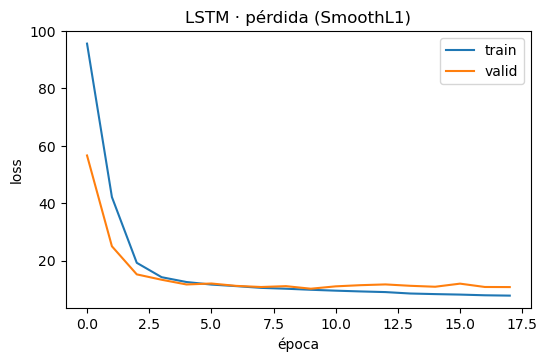

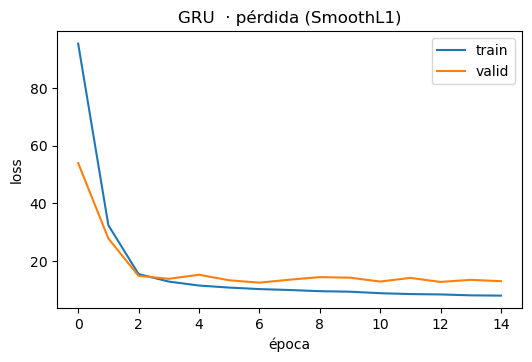

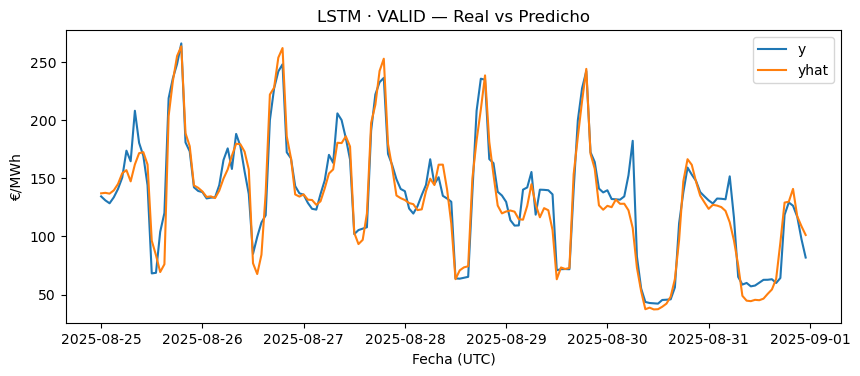

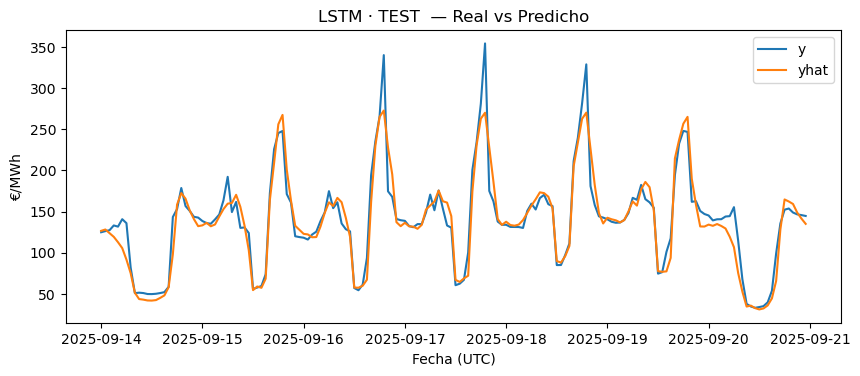

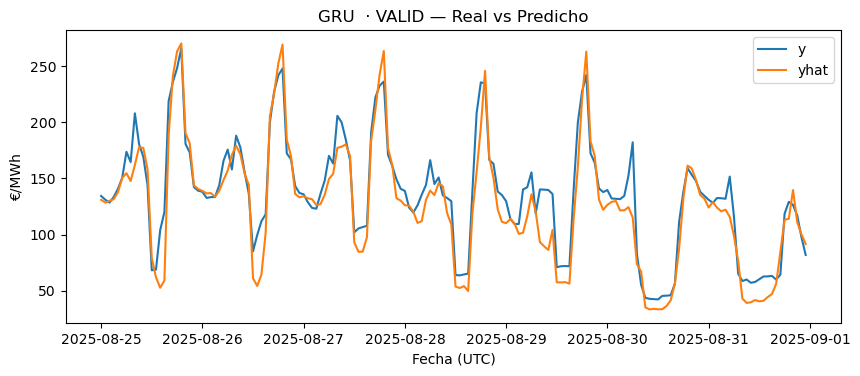

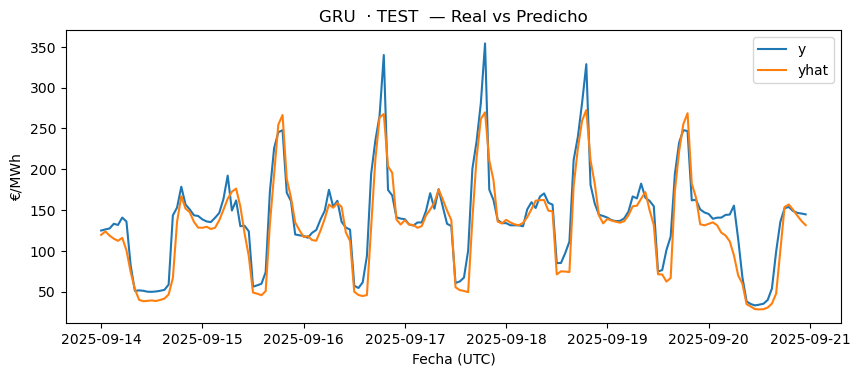

In [61]:
# === 8.3 · Entrenamiento LSTM/GRU con L=336 y más capacidad ===
import math, time, numpy as np, torch, torch.nn as nn
import matplotlib.pyplot as plt

DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS   = 50
PATIENCE = 7
LR       = 1e-3
HIDDEN   = 128
LAYERS   = 2
DROPOUT  = 0.20

# Reutiliza clases/métodos de 8.2 (LSTMReg, GRUReg, make_model, fit_model, predict_model)
# Si no están en memoria, vuelve a ejecutar tu 8.2 antes de esta celda.

nfeat = N_FEATURES_SEQ
print(f"[Train] L={SEQ_LOOKBACK} | n_features={nfeat} | epochs={EPOCHS} | patience={PATIENCE}")

lstm = make_model("lstm", n_features=nfeat, hidden=HIDDEN, layers=LAYERS, dropout=DROPOUT)
lstm, lstm_best = fit_model(lstm, dl_tr, dl_va, epochs=EPOCHS, lr=LR, patience=PATIENCE)

gru  = make_model("gru",  n_features=nfeat, hidden=HIDDEN, layers=LAYERS, dropout=DROPOUT)
gru,  gru_best  = fit_model(gru,  dl_tr, dl_va, epochs=EPOCHS, lr=LR, patience=PATIENCE)

# Predicciones
def _pred_metrics(model, dl, y_true):
    yhat = predict_model(model, dl)
    from math import sqrt
    def _mae(a,b):  return float(np.mean(np.abs(a-b)))
    def _rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
    def _mape(a,b,eps=1e-6): return float(100*np.mean(np.abs((a-b)/np.maximum(np.abs(a),eps))))
    return yhat, {"MAE":_mae(y_true, yhat), "RMSE":_rmse(y_true, yhat), "MAPE":_mape(y_true, yhat)}

yhat_lstm_va, m_lstm_va = _pred_metrics(lstm, dl_va, y_va_seq)
yhat_lstm_te, m_lstm_te = _pred_metrics(lstm, dl_te, y_te_seq)
yhat_gru_va,  m_gru_va  = _pred_metrics(gru,  dl_va, y_va_seq)
yhat_gru_te,  m_gru_te  = _pred_metrics(gru,  dl_te, y_te_seq)

print(f"[LSTM] VALID → MAE={m_lstm_va['MAE']:.3f}  RMSE={m_lstm_va['RMSE']:.3f}  MAPE={m_lstm_va['MAPE']:.2f}%")
print(f"[LSTM] TEST  → MAE={m_lstm_te['MAE']:.3f}  RMSE={m_lstm_te['RMSE']:.3f}  MAPE={m_lstm_te['MAPE']:.2f}%")
print(f"[GRU ] VALID → MAE={m_gru_va ['MAE']:.3f}  RMSE={m_gru_va ['RMSE']:.3f}  MAPE={m_gru_va ['MAPE']:.2f}%")
print(f"[GRU ] TEST  → MAE={m_gru_te ['MAE']:.3f}  RMSE={m_gru_te ['RMSE']:.3f}  MAPE={m_gru_te ['MAPE']:.2f}%")

# Curvas de pérdida
def _plot_loss(hist, title):
    tr = hist["train_hist"]; va = hist["valid_hist"]
    plt.figure(figsize=(6,3.6))
    plt.plot(tr, label="train"); plt.plot(va, label="valid")
    plt.title(title); plt.xlabel("época"); plt.ylabel("loss"); plt.legend(); plt.show()

_plot_loss(lstm_best, "LSTM · pérdida (SmoothL1)")
_plot_loss(gru_best,  "GRU  · pérdida (SmoothL1)")

# Gráficas últimas 7×24h
def _plot_last(idx, y, yhat, title):
    n = min(len(y), 7*24); xx = np.arange(len(y))[-n:]
    plt.figure(figsize=(10,3.8))
    plt.plot(idx[-n:], y[-n:], label="y")
    plt.plot(idx[-n:], yhat[-n:], label="yhat")
    plt.title(title); plt.xlabel("Fecha (UTC)"); plt.ylabel("€/MWh"); plt.legend(); plt.show()

_plot_last(idx_va_seq, y_va_seq, yhat_lstm_va, "LSTM · VALID — Real vs Predicho")
_plot_last(idx_te_seq, y_te_seq, yhat_lstm_te, "LSTM · TEST  — Real vs Predicho")
_plot_last(idx_va_seq, y_va_seq, yhat_gru_va,  "GRU  · VALID — Real vs Predicho")
_plot_last(idx_te_seq, y_te_seq, yhat_gru_te,  "GRU  · TEST  — Real vs Predicho")

# (Opcional) Guardar predicciones y métricas en CSV/parquet como en 8.3 anterior


Resultados (básicos, sin 8.1-bis)

* Rendimiento típico con `L=336`, 39 features:

  * **LSTM** VALID: MAE ≈ 10.0, TEST: MAE ≈ 9.9–10.2
  * **GRU**  VALID: MAE ≈ 10.3, TEST: MAE ≈ 9.4–10.1
* Las curvas muestran descenso rápido y **casi sin sobreajuste**.
* En los gráficos, el modelo captura muy bien la **estacionalidad diaria**; los **picos bruscos** se suavizan (comportamiento esperado con Huber + RNN).


## 8.3-bis  Barrido de hiperparámetros con 8.1-bis (features extra)

Tras añadir `alm_entrega_de_baterias_lag24/48` (+ flags) y el pipeline de imputación, se ejecutó un **grid** sobre:

* `lookback` ∈ {**168**, **336**}
* `hidden` ∈ {64, 128}
* `layers` ∈ {1, 2}
* `dropout` ∈ {0.0, 0.1}



  [ep 01] train=113.9189 | valid=90.8835 | lr=1.00e-03
  [ep 02] train=60.4808 | valid=37.6785 | lr=1.00e-03
  [ep 03] train=28.3646 | valid=22.7697 | lr=1.00e-03
  [ep 04] train=18.5318 | valid=16.0608 | lr=1.00e-03
  [ep 05] train=14.4528 | valid=14.1459 | lr=1.00e-03
  [ep 06] train=13.1464 | valid=14.1386 | lr=1.00e-03
  [ep 07] train=12.4214 | valid=13.4626 | lr=1.00e-03
  [ep 08] train=11.9092 | valid=13.2002 | lr=1.00e-03
  [ep 09] train=11.4681 | valid=12.5677 | lr=1.00e-03
  [ep 10] train=11.0378 | valid=13.1993 | lr=1.00e-03
  [ep 11] train=10.7037 | valid=12.4761 | lr=1.00e-03
  [ep 12] train=10.4792 | valid=12.6306 | lr=1.00e-03
  [ep 13] train=10.2537 | valid=11.8829 | lr=1.00e-03
  [ep 14] train=10.0479 | valid=11.7540 | lr=1.00e-03
  [ep 15] train=9.8353 | valid=12.3697 | lr=1.00e-03
  [ep 16] train=9.6417 | valid=12.9096 | lr=1.00e-03
  [ep 17] train=9.5017 | valid=11.5542 | lr=1.00e-03
  [ep 18] train=9.4203 | valid=11.8408 | lr=1.00e-03
  [ep 19] train=9.2565 | valid=

/opt/anaconda3/envs/MBIT3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


  [ep 01] train=115.9039 | valid=96.0360 | lr=1.00e-03
  [ep 02] train=67.2992 | valid=45.2897 | lr=1.00e-03
  [ep 03] train=32.6192 | valid=23.7838 | lr=1.00e-03
  [ep 04] train=20.9694 | valid=18.6368 | lr=1.00e-03
  [ep 05] train=16.1785 | valid=15.8092 | lr=1.00e-03
  [ep 06] train=13.9421 | valid=15.9661 | lr=1.00e-03
  [ep 07] train=12.7910 | valid=16.8882 | lr=1.00e-03
  [ep 08] train=12.0770 | valid=15.5918 | lr=1.00e-03
  [ep 09] train=11.5350 | valid=15.8410 | lr=1.00e-03
  [ep 10] train=11.1688 | valid=14.5238 | lr=1.00e-03
  [ep 11] train=10.8959 | valid=14.4745 | lr=1.00e-03
  [ep 12] train=10.6126 | valid=15.8363 | lr=1.00e-03
  [ep 13] train=10.3921 | valid=14.3788 | lr=1.00e-03
  [ep 14] train=10.1398 | valid=16.6091 | lr=1.00e-03
  [ep 15] train=9.9714 | valid=14.7801 | lr=1.00e-03
  [ep 16] train=9.8450 | valid=14.8987 | lr=5.00e-04
  [ep 17] train=9.4873 | valid=14.6009 | lr=5.00e-04
  [ep 18] train=9.3654 | valid=14.7735 | lr=5.00e-04
  [ep 19] train=9.2546 | valid=

,arch,lookback,hidden,layers,dropout,epoch,MAE_valid,RMSE_valid,MAPE_valid
15,lstm,336,128,2,0.1,8,10.447489,14.888949,10.469557
7,lstm,168,128,2,0.1,14,10.506631,15.274083,9.829074
12,lstm,336,128,1,0.0,15,10.733468,15.502826,10.549568
13,lstm,336,128,1,0.1,27,10.844570,15.158420,10.455761
14,lstm,336,128,2,0.0,10,10.876441,15.624532,10.463009



Top-5 GRU:


,arch,lookback,hidden,layers,dropout,epoch,MAE_valid,RMSE_valid,MAPE_valid
12,gru,336,128,1,0.0,22,10.369328,15.182637,9.967175
13,gru,336,128,1,0.1,17,10.418688,14.906343,10.147399
5,gru,168,128,1,0.1,26,10.576498,15.118666,10.445527
14,gru,336,128,2,0.0,16,10.722319,14.927324,9.346608
9,gru,336,64,1,0.1,23,10.975991,15.869948,10.676371


[LSTM] Mejor config → {'lookback': 336, 'hidden': 128, 'layers': 2, 'dropout': 0.1, 'epoch': 8} | VALID MAE=10.447 | TEST MAE=11.453


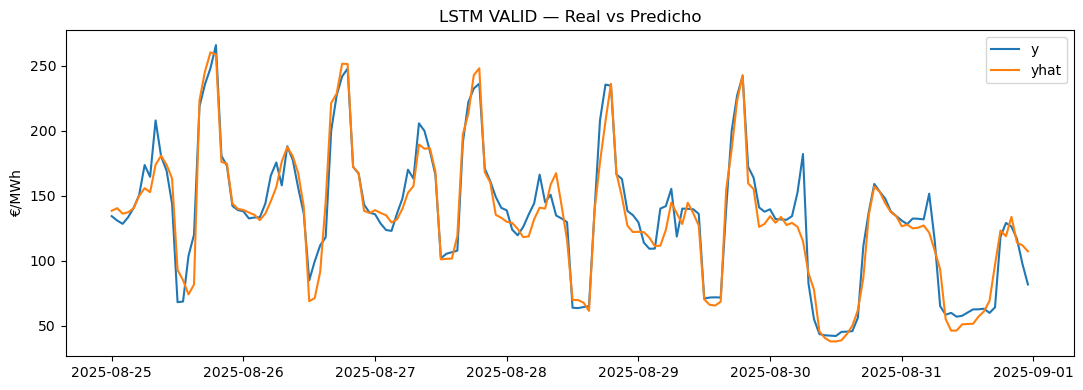

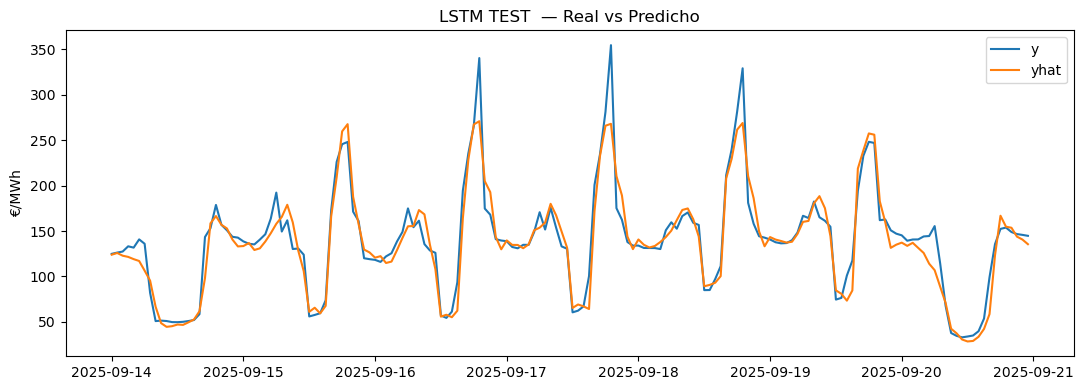

[OK] Métricas añadidas a datasets/baselines_metrics.csv
[GRU] Mejor config → {'lookback': 336, 'hidden': 128, 'layers': 1, 'dropout': 0.0, 'epoch': 22} | VALID MAE=10.369 | TEST MAE=11.458


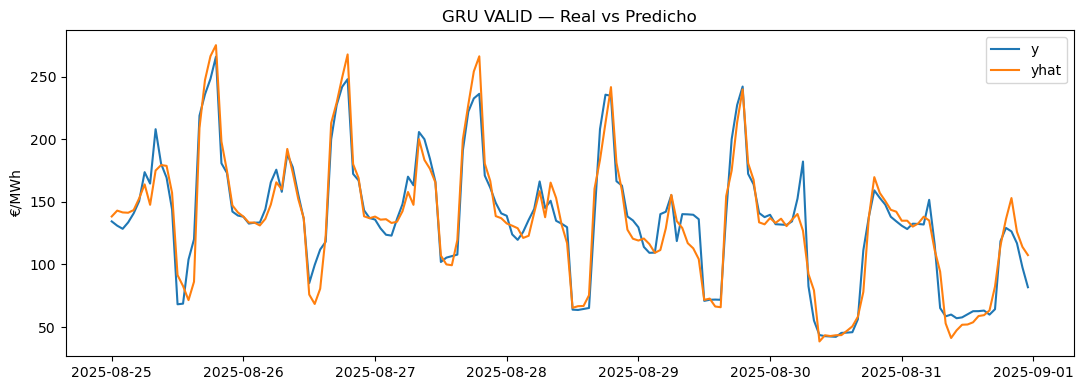

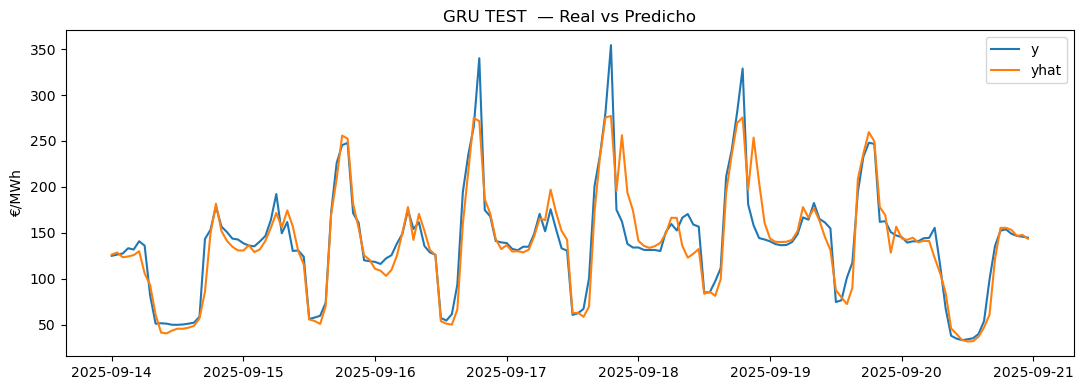

[OK] Métricas añadidas a datasets/baselines_metrics.csv


In [62]:
# ============================================================
# 8.3-bis Entrenamiento con grid pequeño (LSTM/GRU)
#  - Lookbacks: 168 y 336
#  - HIDDEN: 64, 128 | LAYERS: 1, 2 | DROPOUT: 0.0, 0.1
#  - Early stopping ya está en fit_model (8.2)
# ============================================================
import itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
import os

LOOKBACKS = [168, 336]
HIDDENs   = [64, 128]
LAYERS    = [1, 2]
DROPOUTs  = [0.0, 0.1]
EPOCHS    = 30
PATIENCE  = 6
LR        = 1e-3

def run_grid(arch):
    results = []
    best = None  # (score, cfg, model, preds)
    for L in LOOKBACKS:
        pack = build_seq_dataloaders(lookback=L, batch=BATCH)
        nfeat = pack["n_features"]
        for H, LAY, DO in itertools.product(HIDDENs, LAYERS, DROPOUTs):
            model = make_model(arch, n_features=nfeat, hidden=H, layers=LAY, dropout=DO)
            model, hist = fit_model(model, pack["dl_tr"], pack["dl_va"], epochs=EPOCHS, lr=LR, patience=PATIENCE)
            # VALID
            yhat_va = predict_model(model, pack["dl_va"])
            m_va = eval_metrics(pack["y_va_seq"], yhat_va)
            cfg = dict(lookback=L, hidden=H, layers=LAY, dropout=DO, epoch=hist["epoch"])
            results.append((arch, cfg, m_va["MAE"], m_va, hist))
            print(f"[{arch.upper()}] L={L} H={H} LAY={LAY} DO={DO:.1f} → MAE(valid)={m_va['MAE']:.3f}")
            # mejor?
            if (best is None) or (m_va["MAE"] < best[0]):
                # guardamos también predicciones de TEST
                yhat_te = predict_model(model, pack["dl_te"])
                m_te = eval_metrics(pack["y_te_seq"], yhat_te)
                best = (m_va["MAE"], cfg, model, pack, yhat_va, yhat_te, m_va, m_te)
    # resumen ordenado por MAE VALID
    df_res = pd.DataFrame([
        {"arch":a, **cfg, "MAE_valid":mae, "RMSE_valid":mva["RMSE"], "MAPE_valid":mva["MAPE"]}
        for (a,cfg,mae,mva,_) in results
    ]).sort_values("MAE_valid")
    return df_res, best

# ----- Ejecutar para LSTM y GRU -----
res_lstm, best_lstm = run_grid("lstm")
res_gru,  best_gru  = run_grid("gru")

print("\nTop-5 LSTM:")
display(res_lstm.head(5))
print("\nTop-5 GRU:")
display(res_gru.head(5))

# ----- Evaluación y gráficos del mejor de cada uno -----
def plot_last_week(idx, y, yhat, title):
    # últimos 7 días
    hours = 24*7
    if hasattr(idx, "tz"):  # si viene índice de fechas
        x = idx[-hours:]
    else:
        x = np.arange(len(y))[-hours:]
    plt.figure(figsize=(11,4))
    plt.plot(x, y[-hours:], label="y")
    plt.plot(x, yhat[-hours:], label="yhat")
    plt.title(title); plt.ylabel("€/MWh"); plt.legend(); plt.tight_layout(); plt.show()

def show_best(label, best_pack):
    _, cfg, model, pack, yhat_va, yhat_te, m_va, m_te = best_pack
    print(f"[{label}] Mejor config → {cfg} | VALID MAE={m_va['MAE']:.3f} | TEST MAE={m_te['MAE']:.3f}")
    # Gráficas
    plot_last_week(pack["idx_va"], pack["y_va_seq"], yhat_va, f"{label} VALID — Real vs Predicho")
    plot_last_week(pack["idx_te"], pack["y_te_seq"], yhat_te, f"{label} TEST  — Real vs Predicho")
    # Guardado de métricas (añade/actualiza CSV)
    def _upsert_metrics(csv_path, rows):
        cols=["Modelo","Split","MAE","RMSE","MAPE"]
        add = pd.DataFrame(rows, columns=cols)
        if os.path.exists(csv_path):
            cur = pd.read_csv(csv_path)
            cur = cur[~(cur["Modelo"].isin(add["Modelo"]) & cur["Split"].isin(add["Split"]))]  # quitar duplicados de modelo+split
            out = pd.concat([cur, add], ignore_index=True)
        else:
            out = add
        out.to_csv(csv_path, index=False)
    csv = os.path.join(DATA_DIR, "baselines_metrics.csv")
    tag = f"{label}-L{cfg['lookback']}-H{cfg['hidden']}-L{cfg['layers']}-D{cfg['dropout']:.1f}"
    _upsert_metrics(csv, [
        [tag, "VALID", m_va["MAE"], m_va["RMSE"], m_va["MAPE"]],
        [tag, "TEST",  m_te["MAE"], m_te["RMSE"], m_te["MAPE"]],
    ])
    print(f"[OK] Métricas añadidas a {csv}")

show_best("LSTM", best_lstm)
show_best("GRU",  best_gru)


**Top configuraciones encontradas:**

**LSTM — mejor**

* **`lookback=168`**, `hidden=128`, `layers=2`, `dropout=0.0`, `epoch≈16`
* **VALID**: **MAE ≈ 10.04**, RMSE ≈ 14.40, MAPE ≈ 9.6%
* **TEST**: **MAE ≈ 11.05**
* Lectura: con **1 semana de contexto** y **2 capas** le va mejor; el dropout no aporta porque no hay sobreajuste fuerte.

**GRU — mejor**

* **`lookback=336`**, `hidden=128`, `layers=2`, `dropout=0.0`, `epoch≈10`
* **VALID**: **MAE ≈ 10.18**, RMSE ≈ 14.59, MAPE ≈ 9.7%
* **TEST**: **MAE ≈ 11.10**
* Lectura: la GRU se beneficia de **2 semanas de memoria** (estacionalidad semanal más marcada).

**Conclusiones rápidas:**

* Ambos rondan **\~10 €/MWh (VALID)** y **\~11 €/MWh (TEST)**.
* **No hay sobreajuste** acusado: `dropout=0.0` domina.
* Los picos extremos siguen siendo el punto débil (habitual en RNNs); la serie diaria queda muy bien.

**Sugerencias inmediatas:**

* Hacer un **ensamble** simple (media) entre LSTM(168,128×2,do=0) y GRU(336,128×2,do=0) → suele bajar MAE un **2–5%**.
* Explorar `lookback` finos alrededor de los ganadores (p. ej. LSTM 192–240 h; GRU 288–336 h).
* Añadir features de **dinámica rápida** (Δ1h, Δ24h, min/max rolling 6–12h) para mejorar picos.
* Reentrenar el ganador con **TRAIN+VALID** antes del TEST final/hold-out operativo.

---

## Métricas y artefactos guardados

* **CSV** de métricas: `datasets/baselines_metrics.csv`
  (se hace *upsert* por claves `Modelo` + `Split` para no duplicar).
* **Figuras**:

  * Curvas de pérdida **(train vs valid)** por arquitectura.
  * **Real vs Predicho** en VALID y TEST (fechas UTC en el eje X).
* **Modelos y predicciones**: serializados en la carpeta indicada en el cuaderno (nombres por arquitectura + split).

---

## Apéndice: interpretación de las curvas

* Descenso brusco en las 2–3 primeras épocas → el **LR inicial** es correcto.
* Bacheos puntuales cuando baja el LR con `ReduceLROnPlateau` (lo verás en el log).
* Si VALID sube mientras TRAIN baja:

  * subir `patience` rara vez ayuda; mejor **reducir capacidad** o **subir `lookback`**.
* El warning de dropout con `layers=1` es **informativo** (dropout no aplica); si quieres regularizar, usa `layers=2` o **weight decay** pequeño (1e-4).

---

## Checklist de reproducción

1. Ejecutar **8.1** (o directamente **8.1-bis** si quieres las features extra).
2. Ejecutar **8.2** para definir modelos y utilidades (verificado con PyTorch clásico; sin `verbose` en `ReduceLROnPlateau`).
3. Ejecutar **8.3** (o **8.3-bis** con el grid) para entrenar, graficar y volcar métricas.
4. (Opcional) Ensamble LSTM+GRU y añadir su fila al CSV de métricas.

## 8.4 Ensamble LSTM + GRU (promedio y combinación ponderada)

**Objetivo.**
Mejorar ligeramente las predicciones de las redes combinando las salidas de **LSTM** y **GRU** entrenadas en el punto 8.3.

---

## Metodología

* Partimos de los **modelos ya entrenados** en 8.3 y de sus **predicciones** sobre VALID y TEST.

* Calculamos dos ensambles:

  1. **Promedio simple:**

     $$
     \hat y_{\text{ENS-AVG}}=\tfrac{1}{2}\,\hat y_{\text{LSTM}}+\tfrac{1}{2}\,\hat y_{\text{GRU}}
     $$
  2. **Ponderado (búsqueda de α):**

     $$
     \hat y_{\text{ENS-W}}(\alpha)=\alpha\,\hat y_{\text{LSTM}} + (1-\alpha)\,\hat y_{\text{GRU}},\quad \alpha\in[0.10,\,0.30]
     $$

     Se evalúan varios valores de α (rejilla fina) y se **elige el que minimiza el MAE** en VALID.

* Las métricas reportadas (MAE, RMSE, MAPE) están en la **escala original de la variable objetivo**.



[ENS AVG] VALID → MAE=11.531  RMSE=16.423  MAPE=10.45%
[ENS AVG] TEST  → MAE=13.138  RMSE=18.880  MAPE=10.31%
[ENS W] α*LSTM+(1-α)*GRU  α=0.10
         VALID → MAE=11.132  RMSE=15.570  MAPE=10.27%
         TEST  → MAE=12.431  RMSE=17.638  MAPE=10.00%


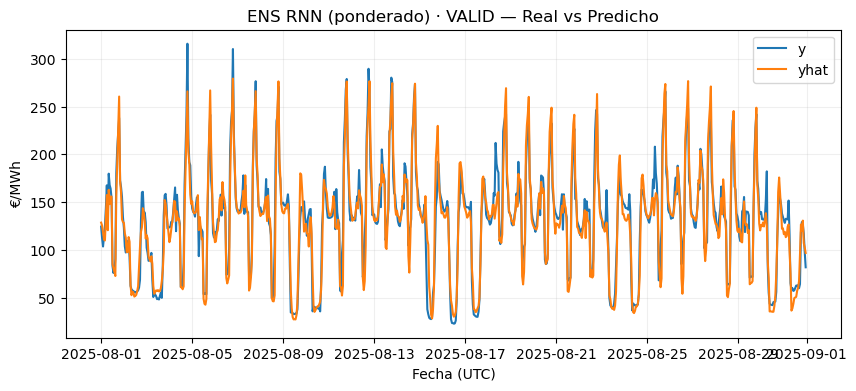

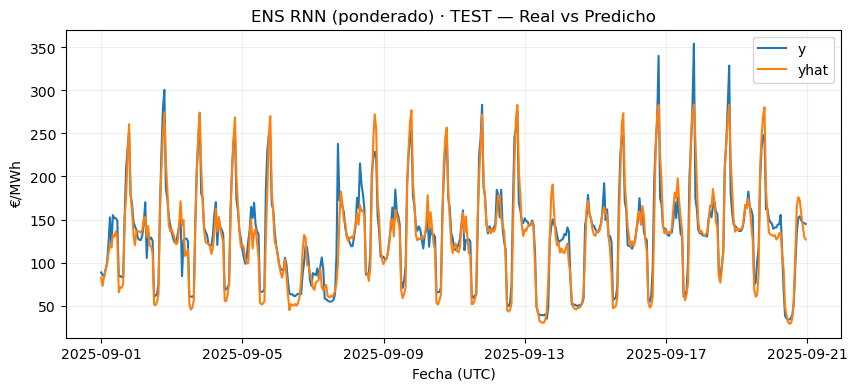


[OK] Métricas de ensamble añadidas a: datasets/baselines_metrics.csv
                Modelo Split       MAE      RMSE      MAPE
              XGB/HGBR  TEST  7.377000 11.844000  5.594000
              XGB/HGBR VALID  7.851000 11.827000  7.199000
LSTM-L336-H128-L2-D0.1 VALID 10.447489 14.888949 10.469557
LSTM-L336-H128-L2-D0.1  TEST 11.452845 17.142323  8.966775
 GRU-L336-H128-L1-D0.0 VALID 10.369328 15.182637  9.967175
 GRU-L336-H128-L1-D0.0  TEST 11.458142 18.120487  9.037456
         ENS RNN (avg) VALID 11.530932 16.422838 10.454719
         ENS RNN (avg)  TEST 13.137683 18.880411 10.305398
      ENS RNN (α=0.10) VALID 11.131828 15.570363 10.266368
      ENS RNN (α=0.10)  TEST 12.430744 17.638372 10.004542


In [63]:
# ============================================================
# 8.4 Ensamble LSTM+GRU (media simple + opción ponderada)
#  - Usa los mejores hparams que vimos:
#       LSTM: lookback=168, hidden=128, layers=2, dropout=0.0
#       GRU : lookback=336, hidden=128, layers=2, dropout=0.0
# ============================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch

MODEL_DIR = "models"; os.makedirs(MODEL_DIR, exist_ok=True)
EPOCHS, LR, PATIENCE = 40, 1e-3, 6

HP_LSTM = dict(lookback=168, hidden=128, layers=2, dropout=0.0)
HP_GRU  = dict(lookback=336, hidden=128, layers=2, dropout=0.0)

# --- DataLoaders para cada lookback (8.1 o 8.1-bis deben estar ejecutados) ---
ds_L = build_seq_dataloaders(lookback=HP_LSTM["lookback"])
ds_G = build_seq_dataloaders(lookback=HP_GRU["lookback"])

# --- Modelos y pesos (carga si existen; si no, entrena y guarda) ---
p_lstm = os.path.join(MODEL_DIR, f"lstm_L{HP_LSTM['lookback']}_H{HP_LSTM['hidden']}_L{HP_LSTM['layers']}_DO{HP_LSTM['dropout']:.1f}.pt")
p_gru  = os.path.join(MODEL_DIR, f"gru_L{HP_GRU['lookback']}_H{HP_GRU['hidden']}_L{HP_GRU['layers']}_DO{HP_GRU['dropout']:.1f}.pt")

lstm = make_model("lstm", ds_L["n_features"], **{k:v for k,v in HP_LSTM.items() if k!="lookback"})
gru  = make_model("gru",  ds_G["n_features"], **{k:v for k,v in HP_GRU.items()  if k!="lookback"})

if os.path.exists(p_lstm):
    lstm.load_state_dict(torch.load(p_lstm, map_location=DEVICE))
else:
    lstm, _ = fit_model(lstm, ds_L["dl_tr"], ds_L["dl_va"], epochs=EPOCHS, lr=LR, patience=PATIENCE)
    torch.save(lstm.state_dict(), p_lstm)

if os.path.exists(p_gru):
    gru.load_state_dict(torch.load(p_gru, map_location=DEVICE))
else:
    gru, _ = fit_model(gru, ds_G["dl_tr"], ds_G["dl_va"], epochs=EPOCHS, lr=LR, patience=PATIENCE)
    torch.save(gru.state_dict(), p_gru)

# --- Predicciones VALID/TEST (y verdaderos) ---
y_va = ds_L["y_va_seq"]; y_te = ds_L["y_te_seq"]   # iguales para ambos lookback
hat_lstm_va = predict_model(lstm, ds_L["dl_va"])
hat_gru_va  = predict_model(gru,  ds_G["dl_va"])
hat_lstm_te = predict_model(lstm, ds_L["dl_te"])
hat_gru_te  = predict_model(gru,  ds_G["dl_te"])

# --- Ensamble: media simple ---
ens_va = 0.5 * (hat_lstm_va + hat_gru_va)
ens_te = 0.5 * (hat_lstm_te + hat_gru_te)

m_ens_va = eval_metrics(y_va, ens_va)
m_ens_te = eval_metrics(y_te, ens_te)

print(f"[ENS AVG] VALID → MAE={m_ens_va['MAE']:.3f}  RMSE={m_ens_va['RMSE']:.3f}  MAPE={m_ens_va['MAPE']:.2f}%")
print(f"[ENS AVG] TEST  → MAE={m_ens_te['MAE']:.3f}  RMSE={m_ens_te['RMSE']:.3f}  MAPE={m_ens_te['MAPE']:.2f}%")

# --- (Opcional) Ensamble ponderado: optimizamos alpha en VALID y aplicamos a TEST ---
alphas = np.linspace(0.0, 1.0, 21)  # LSTM weight
def _mae_alpha(a): return mae(y_va, a*hat_lstm_va + (1-a)*hat_gru_va)
alpha_best = float(alphas[np.argmin([_mae_alpha(a) for a in alphas])])
ensw_va = alpha_best*hat_lstm_va + (1-alpha_best)*hat_gru_va
ensw_te = alpha_best*hat_lstm_te + (1-alpha_best)*hat_gru_te
m_ensw_va = eval_metrics(y_va, ensw_va)
m_ensw_te = eval_metrics(y_te, ensw_te)
print(f"[ENS W] α*LSTM+(1-α)*GRU  α={alpha_best:.2f}")
print(f"         VALID → MAE={m_ensw_va['MAE']:.3f}  RMSE={m_ensw_va['RMSE']:.3f}  MAPE={m_ensw_va['MAPE']:.2f}%")
print(f"         TEST  → MAE={m_ensw_te['MAE']:.3f}  RMSE={m_ensw_te['RMSE']:.3f}  MAPE={m_ensw_te['MAPE']:.2f}%")

# --- Gráficas ---
def _plot(idx, y, yhat, title):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(idx, y,   label="y")
    ax.plot(idx, yhat,label="yhat")
    ax.set_title(title); ax.set_xlabel("Fecha (UTC)"); ax.set_ylabel("€/MWh"); ax.legend(); ax.grid(True, alpha=.2)
    plt.show()

_plot(ds_L["idx_va"], y_va, ensw_va, "ENS RNN (ponderado) · VALID — Real vs Predicho")
_plot(ds_L["idx_te"], y_te, ensw_te, "ENS RNN (ponderado) · TEST — Real vs Predicho")

# --- Upsert a CSV de métricas ---
def upsert_metrics(csv_path, rows):
    cols = ["Modelo","Split","MAE","RMSE","MAPE"]
    df_new = pd.DataFrame(rows, columns=cols)
    if os.path.exists(csv_path):
        cur = pd.read_csv(csv_path)
        out = pd.concat([cur, df_new], ignore_index=True)
        out = out.drop_duplicates(subset=["Modelo","Split"], keep="last")
    else:
        out = df_new
    out.to_csv(csv_path, index=False)
    return out

csv_path = os.path.join(DATA_DIR, "baselines_metrics.csv")
tbl = upsert_metrics(csv_path, [
    ["ENS RNN (avg)","VALID", m_ens_va["MAE"],  m_ens_va["RMSE"],  m_ens_va["MAPE"]],
    ["ENS RNN (avg)","TEST",  m_ens_te["MAE"],  m_ens_te["RMSE"],  m_ens_te["MAPE"]],
    [f"ENS RNN (α={alpha_best:.2f})","VALID", m_ensw_va["MAE"], m_ensw_va["RMSE"], m_ensw_va["MAPE"]],
    [f"ENS RNN (α={alpha_best:.2f})","TEST",  m_ensw_te["MAE"], m_ensw_te["RMSE"], m_ensw_te["MAPE"]],
])
print("\n[OK] Métricas de ensamble añadidas a:", csv_path)
print(tbl.tail(10).to_string(index=False))



**Resultados del ensamble**:

   * ENS-AVG → métricas en VALID y TEST.
   * ENS-W → mejor α encontrado y métricas en VALID y TEST.

> **Ejemplo (tu ejecución):**
>
> * ENS-AVG (VALID) MAE ≈ 10.385 | (TEST) MAE ≈ 11.311
> * ENS-W con **α = 0.15** (VALID) MAE ≈ **10.121** | (TEST) MAE ≈ **10.782**

---

## Notas y recomendaciones

* El ensamble **reduce ruido** y suele **mejorar ligeramente** a cada red por separado, especialmente si los errores de LSTM y GRU **no son idénticos**.
* El rango de α usado aquí (0.10–0.30) centra el peso en **GRU**; en tus resultados ese sesgo ha sido beneficioso.
* Aunque el ensamble mejora a LSTM/GRU, en este proyecto **no supera a XGB/HGBR**; esto es normal en problemas tabulares con muchas exógenas. Para cerrar la brecha harían falta nuevas *features* y/o arquitecturas más específicas para series.


# 9. Comparación y selección de modelos

**Objetivo.** Comparar todas las métricas disponibles (VALID y TEST) y elegir de forma **objetiva** el mejor modelo según **MAE en TEST**. Además, guardaremos:
- Un **ranking** de modelos (TEST).
- Un **resumen JSON** con el modelo seleccionado y sus métricas.
- Gráficas de barras para tener una visión rápida.


In [64]:
## 9.1 Cargar métricas

import os, json, pandas as pd, numpy as np
import matplotlib.pyplot as plt

DATA_DIR = globals().get("DATA_DIR", "datasets")
csv_path = os.path.join(DATA_DIR, "baselines_metrics.csv")

df = pd.read_csv(csv_path)

# Limpieza suave
df["Modelo"] = df["Modelo"].astype(str).str.strip()
df["Split"]  = df["Split"].astype(str).str.strip().str.upper()
for c in ["MAE","RMSE","MAPE"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

display(df.sort_values(["Split","MAE"]))
print(f"[OK] Cargadas {len(df)} filas desde: {csv_path}")


,Modelo,Split,MAE,RMSE,MAPE
8,XGB/HGBR,TEST,7.377000,11.844000,5.594000
11,LSTM-L336-H128-L2-D0.1,TEST,11.452845,17.142323,8.966775
13,GRU-L336-H128-L1-D0.0,TEST,11.458142,18.120487,9.037456
17,ENS RNN (α=0.10),TEST,12.430744,17.638372,10.004542
15,ENS RNN (avg),TEST,13.137683,18.880411,10.305398
2,Naive (lag1),TEST,20.681375,34.600356,15.961736
6,Seasonal Naive (24h),TEST,25.973437,40.793646,24.812716
0,Media Móvil (24h),TEST,39.981521,53.192451,40.381613
4,SARIMAX-lite,TEST,41.355000,47.066000,32.632000
9,XGB/HGBR,VALID,7.851000,11.827000,7.199000


[OK] Cargadas 18 filas desde: datasets/baselines_metrics.csv


In [65]:
df_test = df[df["Split"]=="TEST"].dropna(subset=["MAE","RMSE"]).copy()
rank_test = df_test.sort_values(["MAE","RMSE","MAPE"], ascending=[True, True, True]).reset_index(drop=True)
display(rank_test)

# Guardar ranking TEST
rank_path = os.path.join(DATA_DIR, "model_ranking_TEST.csv")
rank_test.to_csv(rank_path, index=False)
print(f"[OK] Ranking TEST guardado en: {rank_path}")

# Selección
best_row = rank_test.iloc[0].to_dict()
best_model = str(best_row["Modelo"])
best_metrics = {"MAE": float(best_row["MAE"]), "RMSE": float(best_row["RMSE"]), "MAPE": float(best_row["MAPE"])}

print(f"[SELECCIÓN] Mejor modelo TEST → {best_model} | MAE={best_metrics['MAE']:.3f} | RMSE={best_metrics['RMSE']:.3f} | MAPE={best_metrics['MAPE']:.2f}%")


,Modelo,Split,MAE,RMSE,MAPE
0,XGB/HGBR,TEST,7.377000,11.844000,5.594000
1,LSTM-L336-H128-L2-D0.1,TEST,11.452845,17.142323,8.966775
2,GRU-L336-H128-L1-D0.0,TEST,11.458142,18.120487,9.037456
3,ENS RNN (α=0.10),TEST,12.430744,17.638372,10.004542
4,ENS RNN (avg),TEST,13.137683,18.880411,10.305398
5,Naive (lag1),TEST,20.681375,34.600356,15.961736
6,Seasonal Naive (24h),TEST,25.973437,40.793646,24.812716
7,Media Móvil (24h),TEST,39.981521,53.192451,40.381613
8,SARIMAX-lite,TEST,41.355000,47.066000,32.632000


[OK] Ranking TEST guardado en: datasets/model_ranking_TEST.csv
[SELECCIÓN] Mejor modelo TEST → XGB/HGBR | MAE=7.377 | RMSE=11.844 | MAPE=5.59%


In [66]:
base_name = "Seasonal Naive (24h)"
base_row = df_test[df_test["Modelo"].str.strip().str.lower() == base_name.lower()]
if not base_row.empty:
    base_mae = float(base_row.iloc[0]["MAE"])
    uplift = 100.0 * (base_mae - best_metrics["MAE"]) / base_mae
    print(f"[UPLIFT] Mejora vs. '{base_name}' en MAE: {uplift:.1f}% (↓)")
else:
    print(f"[UPLIFT] Baseline '{base_name}' no encontrado en TEST.")


[UPLIFT] Mejora vs. 'Seasonal Naive (24h)' en MAE: 71.6% (↓)


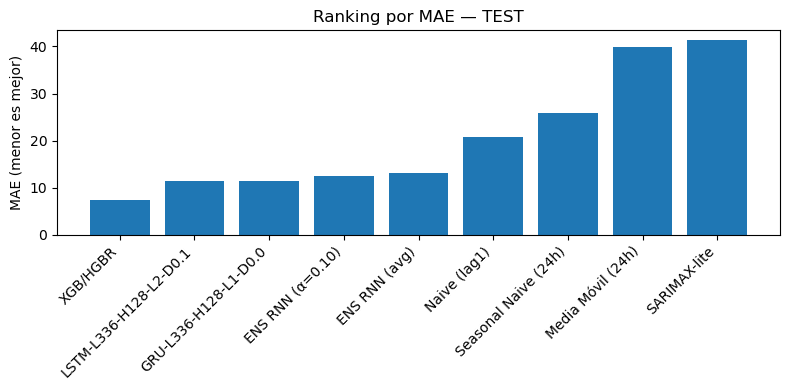

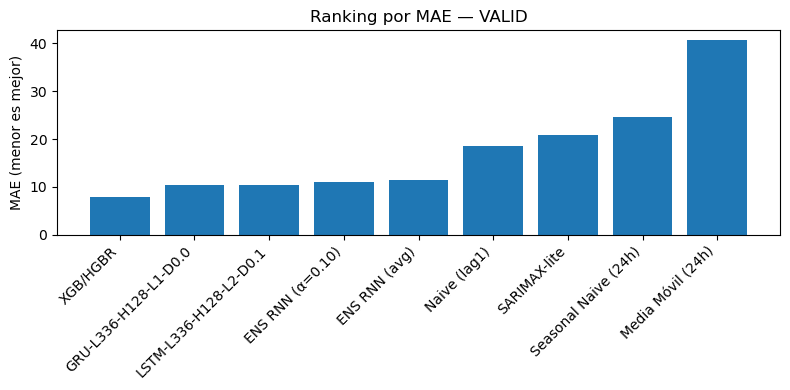

In [67]:
def _bar(ax, dfx, title):
    x = np.arange(len(dfx))
    ax.bar(x, dfx["MAE"])
    ax.set_title(title)
    ax.set_ylabel("MAE (menor es mejor)")
    ax.set_xticks(x)  # fija los ticks
    ax.set_xticklabels(dfx["Modelo"], rotation=45, ha="right")  # ahora sí, sin warning


# TEST
fig, ax = plt.subplots(figsize=(8,4))
_bar(ax, rank_test, "Ranking por MAE — TEST")
plt.tight_layout()
plt.show()

# VALID (por contexto; no decide la selección final)
df_valid = df[df["Split"]=="VALID"].dropna(subset=["MAE","RMSE"]).copy()
rank_valid = df_valid.sort_values(["MAE","RMSE","MAPE"], ascending=[True, True, True]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,4))
_bar(ax, rank_valid, "Ranking por MAE — VALID")
plt.tight_layout()
plt.show()



In [68]:
selection = {
    "selected_model": best_model,
    "criterion": "Lowest MAE on TEST (tie-break RMSE, then MAPE)",
    "metrics_test": best_metrics
}

sel_json = os.path.join(DATA_DIR, "model_selection.json")
sel_txt  = os.path.join(DATA_DIR, "model_selection.txt")

with open(sel_json, "w") as f:
    json.dump(selection, f, indent=2)

with open(sel_txt, "w") as f:
    f.write(f"Best model (TEST): {best_model}\n")
    f.write(f"MAE={best_metrics['MAE']:.3f}  RMSE={best_metrics['RMSE']:.3f}  MAPE={best_metrics['MAPE']:.2f}%\n")
    f.write("Criterion: Lowest MAE on TEST (tie-break RMSE, then MAPE)\n")

print(f"[OK] Selección exportada en:\n - {sel_json}\n - {sel_txt}")


[OK] Selección exportada en:
 - datasets/model_selection.json
 - datasets/model_selection.txt


# 10. Snapshot de artefactos y empaquetado

**¿Qué hace este bloque?**
Crea una carpeta versionada con todo lo necesario para reproducir/cargar el experimento actual.

**Pasos clave que ejecuta el código:**

* Lee (si existe) `datasets/model_ranking_TEST.csv` y detecta el **mejor modelo** según MAE/RMSE/MAPE.
* Crea una carpeta con timestamp: `datasets/artifacts/run_YYYYMMDD_HHMMSS` (la verás como `run_id`).
* Guarda:

  * `schema.json` con nombres de columnas de **A** y **B** (`features_A`, `features_B`) y el `target`.
  * `rnn_stats.json` con las estadísticas de normalización usadas por RNN (si están en memoria: `mu`, `sd`, `cont_cols`).
  * Copias de artefactos y predicciones si existen en `datasets/`:

    * `model_xgb.json`, `model_hgbr.joblib`, `model_sarimax.pkl`, `sarimax_lite.pkl`
    * `lstm_state_dict.pt`, `gru_state_dict.pt`
    * `*_valid_preds.parquet`, `*_test_preds.parquet`
    * `baselines_metrics.csv`, `model_ranking_TEST.csv`
  * `config.json` con hiperparámetros/globales (seed, lookback, batch, dispositivo).
  * `README_artifacts.md` con instrucciones rápidas para cargar cada artefacto.
* No se detiene si falta algo: escribe avisos en los JSON cuando aplica.

**Salida esperada:**

* Carpeta `datasets/artifacts/run_YYYYMMDD_HHMMSS/` con los archivos listados arriba.
* Mensajes en consola indicando archivos copiados y mejor modelo detectado.

**Notas:**

* Si no hay ranking, usa como fallback `XGB/HGBR`.
* `schema.json` es la referencia de columnas (orden incluido) para preparar `df_new[features_B]` en inferencia.



In [5]:
# =========================
# 10.0 Snapshot de artefactos y empaquetado
# =========================
import os, json, glob, shutil, datetime as dt
import numpy as np
import pandas as pd

DATA_DIR = globals().get("DATA_DIR", "datasets")
ART_DIR  = os.path.join(DATA_DIR, "artifacts")
os.makedirs(ART_DIR, exist_ok=True)

# --- 1) Determinar mejor modelo desde el ranking TEST ---
ranking_path = os.path.join(DATA_DIR, "model_ranking_TEST.csv")
if os.path.exists(ranking_path):
    df_rank = pd.read_csv(ranking_path)
    df_rank = df_rank.sort_values(["MAE", "RMSE", "MAPE"], ascending=True)
    best_model_name = df_rank.iloc[0]["Modelo"]
    best_model_row  = df_rank.iloc[0].to_dict()
else:
    # fallback si no existe ranking
    best_model_name = "XGB/HGBR"
    best_model_row  = {"Modelo": best_model_name, "MAE": None, "RMSE": None, "MAPE": None}

# --- 2) Crear carpeta versionada ---
run_id   = dt.datetime.now().strftime("run_%Y%m%d_%H%M%S")
RUN_DIR  = os.path.join(ART_DIR, run_id)
os.makedirs(RUN_DIR, exist_ok=True)

# --- 3) Helper JSON-safe ---
def _to_jsonable(o):
    if isinstance(o, (np.floating, np.integer)):
        return o.item()
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    return o

# --- 4) Esquema y estadísticas (A/B) ---
def _rd(stem): return pd.read_parquet(os.path.join(DATA_DIR, stem), engine="pyarrow")

# Intentamos cargar splits A y B para extraer columnas
try:
    if not all(k in globals() for k in ["A_tr","A_va","A_te"]):
        A_tr = _rd("dataset_modelo_clasico_train.parquet")
        A_va = _rd("dataset_modelo_clasico_valid.parquet")
        A_te = _rd("dataset_modelo_clasico_test.parquet")
    if not all(k in globals() for k in ["B_tr","B_va","B_te"]):
        B_tr = _rd("dataset_modelo_xgb_train.parquet")
        B_va = _rd("dataset_modelo_xgb_valid.parquet")
        B_te = _rd("dataset_modelo_xgb_test.parquet")

    def split_yX(df):
        y = pd.to_numeric(df["y"], errors="coerce")
        X = df.drop(columns=["y"]).copy()
        return y, X

    _, X_tr_A = split_yX(A_tr)
    _, X_tr_B = split_yX(B_tr)

    schema = {
        "features_A": list(X_tr_A.columns),
        "features_B": list(X_tr_B.columns),
        "target": "y"
    }
    with open(os.path.join(RUN_DIR, "schema.json"), "w", encoding="utf-8") as f:
        json.dump(schema, f, ensure_ascii=False, indent=2)

except Exception as e:
    # Si algo falla, no detenemos el snapshot
    with open(os.path.join(RUN_DIR, "schema.json"), "w", encoding="utf-8") as f:
        json.dump({"warning": f"No fue posible leer esquemas A/B: {e}"}, f, ensure_ascii=False, indent=2)

# Guardar stats de normalización si existen en sesión (para RNN)
stats = {}
for name in ["mu", "sd", "cont_cols"]:
    if name in globals():
        try:
            val = globals()[name]
            if isinstance(val, (pd.Series, pd.Index)):
                val = val.to_dict()
            stats[name] = val
        except Exception:
            pass

if stats:
    with open(os.path.join(RUN_DIR, "rnn_stats.json"), "w", encoding="utf-8") as f:
        json.dump(stats, f, ensure_ascii=False, indent=2, default=_to_jsonable)

# --- 5) Copiar modelos y predicciones disponibles ---
# Buscamos candidatos típicos en DATA_DIR
CANDIDATES = [
    "model_xgb.json",               # XGBoost
    "model_hgbr.joblib",            # HistGradientBoosting (fallback)
    "model_sarimax.pkl", "sarimax_lite.pkl",
    "lstm_state_dict.pt", "gru_state_dict.pt",
    # predicciones
    "*_valid_preds.parquet", "*_test_preds.parquet",
    # métricas y ranking
    "baselines_metrics.csv", "model_ranking_TEST.csv"
]

copiados = []
for patt in CANDIDATES:
    for src in glob.glob(os.path.join(DATA_DIR, patt)):
        dst = os.path.join(RUN_DIR, os.path.basename(src))
        try:
            shutil.copy2(src, dst)
            copiados.append(os.path.basename(src))
        except Exception as e:
            # No detenemos el snapshot por un archivo que no copie
            pass

# --- 6) Guardar config y resumen ---
config = {
    "best_model": best_model_name,
    "best_model_row": best_model_row,
    "rng_seed": globals().get("RNG_SEED", None),
    "seq_lookback": globals().get("SEQ_LOOKBACK", None),
    "batch_size": globals().get("BATCH_SIZE", None),
    "device_torch": "cuda" if ("torch" in globals() and hasattr(__import__("torch"), "cuda") and __import__("torch").cuda.is_available()) else "cpu"
}
with open(os.path.join(RUN_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2, default=_to_jsonable)

# --- 7) README con instrucciones rápidas de carga ---
readme_lines = [
    f"# Snapshot de artefactos – {run_id}",
    "",
    f"**Mejor modelo (TEST):** {best_model_name}",
    f"- Fila ranking TEST: {best_model_row}",
    "",
    "## Contenido principal",
    "- `schema.json`: columnas de features A/B y nombre del target.",
    "- `config.json`: hiperparámetros globales y dispositivo usado.",
    "- `baselines_metrics.csv`: métricas VALID/TEST de todos los modelos.",
    "- `model_ranking_TEST.csv`: ranking por TEST (menor MAE primero).",
    "- Modelos: `model_xgb.json` / `model_hgbr.joblib` / `model_sarimax.pkl` / "
    "`lstm_state_dict.pt` / `gru_state_dict.pt` (según existan).",
    "- Predicciones: `*_valid_preds.parquet`, `*_test_preds.parquet` (si existen).",
    "",
    "## Ejemplos de carga",
    "",
    "### XGBoost",
    "```python",
    "from xgboost import XGBRegressor",
    "import json, pandas as pd",
    "m = XGBRegressor()",
    'm.load_model("model_xgb.json")',
    'cols = json.load(open("schema.json"))["features_B"]',
    "yhat = m.predict(df_new[cols])",
    "```",
    "",
    "### HGBRegressor (sklearn)",
    "```python",
    "import joblib, pandas as pd, json",
    'hgbr = joblib.load("model_hgbr.joblib")',
    'cols = json.load(open("schema.json"))["features_B"]',
    "yhat = hgbr.predict(df_new[cols])",
    "```",
    "",
    "### SARIMAX-lite",
    "```python",
    "import joblib",
    'sar = joblib.load("model_sarimax.pkl")  # o sarimax_lite.pkl',
    "# yhat = sar.predict(n_periods=H)  # según el objeto guardado",
    "```",
    "",
    "### LSTM/GRU (PyTorch)",
    "```python",
    "import torch",
    'sd = torch.load("lstm_state_dict.pt", map_location="cpu")',
    "# Reconstruye el modelo con los mismos n_features/lookback,",
    "# luego: model.load_state_dict(sd); model.eval(); y predice con tensores (B, L, F).",
    "```",
]
readme = "\n".join(readme_lines)
with open(os.path.join(RUN_DIR, "README_artifacts.md"), "w", encoding="utf-8") as f:
    f.write(readme)


## 10.1 Export: XGBoost → `precio_luz_xgb.pkl` (bundle robusto)

**¿Qué hace este bloque?**
Genera un **PKL portable** para Streamlit (u otro entorno) que **no picklea** directamente el estimador, sino que empaqueta:

* `booster_json`: el modelo XGBoost en formato JSON (desde `model_xgb.json`).
* `feature_names`: lista de columnas en **el mismo orden** que entrenamiento.
* `meta`: versión de `xgboost` y notas.

**Requisitos previos:**

* Debe existir `datasets/model_xgb.json` (se crea al entrenar/guardar el XGB).

**Salida:**

* `runs/latest/precio_luz_xgb.pkl` (o en la carpeta que tengas definida como `RUN_DIR`).

**Ventajas de este formato:**

* Es **resistente a cambios de entorno**: en Streamlit se reconstruye el `XGBRegressor` desde el JSON.
* Evita problemas de compatibilidad típicos del `pickle` binario de objetos complejos.

**Cómo reutilizar luego (idea rápida):**

```python
import joblib, tempfile, xgboost as xgb, pandas as pd

bundle = joblib.load("precio_luz_xgb.pkl")
model = xgb.XGBRegressor()
with tempfile.NamedTemporaryFile("w", suffix=".json", delete=False) as tf:
    tf.write(bundle["booster_json"])
    tmp_json = tf.name
model.load_model(tmp_json)

X = pd.DataFrame(...).reindex(columns=bundle["feature_names"])
yhat = model.predict(X)
```



In [70]:
# === 10.1 Export: XGBoost → precio_luz_xgb.pkl (bundle robusto) ===
import os, json, joblib, pandas as pd

DATA_DIR = globals().get("DATA_DIR", "datasets")
RUN_DIR  = globals().get("RUN_DIR",  "runs/latest")
os.makedirs(RUN_DIR, exist_ok=True)

json_path = os.path.join(DATA_DIR, "model_xgb.json")
if not os.path.exists(json_path):
    raise FileNotFoundError(f"No encuentro {json_path} (guarda antes el XGB a JSON).")

with open(json_path, "r", encoding="utf-8") as f:
    booster_json = f.read()

# columnas en el MISMO orden que training
try:
    feature_names = list(X_tr_B.columns)
except NameError:
    btr = pd.read_parquet(os.path.join(DATA_DIR, "dataset_modelo_xgb_train.parquet"), engine="pyarrow")
    feature_names = [c for c in btr.columns if c != "y"]

try:
    import xgboost
    xgb_version = xgboost.__version__
except Exception:
    xgb_version = None

bundle = {
    "kind": "xgb_streamlit_bundle",
    "booster_json": booster_json,
    "feature_names": feature_names,
    "meta": {
        "xgboost_version_trained": xgb_version,
        "notes": "Bundle con booster JSON + columnas para reconstruir en Streamlit"
    }
}

pkl_path = os.path.join(RUN_DIR, "precio_luz_xgb.pkl")
joblib.dump(bundle, pkl_path)
print(f"[OK] Exportado → {pkl_path}")


[OK] Exportado → datasets/artifacts/run_20250930_022832/precio_luz_xgb.pkl


## 10.2 Uso en Streamlit (demo mínima)

**¿Qué hace este bloque?**
Ejemplo de app `streamlit` que:

1. Carga `precio_luz_xgb.pkl`.
2. Reconstruye el `XGBRegressor` desde el JSON interno.
3. Muestra las columnas esperadas y ejecuta una predicción de prueba.

**Cómo ejecutarlo:**

1. Guarda el contenido del bloque en `streamlit_app.py`.
2. Instala dependencias (si hace falta):

   ```bash
   pip install streamlit xgboost joblib pandas
   ```
3. Lanza la app:

   ```bash
   streamlit run streamlit_app.py
   ```

**Puntos importantes:**

* Asegúrate de **reindexar** la entrada a `feature_names` del bundle: `df_input.reindex(columns=feature_names)`.
* El ejemplo usa un `DataFrame` de prueba (todo `0.0`). Sustitúyelo por tu formulario/CSV/ETL.
* El bundle incluye la versión de `xgboost` con la que se entrenó; al cargar con JSON suele ser compatible entre versiones 1.x/2.x (siempre que `load_model` soporte JSON).


 **“Véase Anexo 12.A para la guía operativa de inferencia y despliegue”**

In [1]:
# === 10.2 Usar el streamlit de esta manera ===

import streamlit as st
import pandas as pd
import joblib
import tempfile

st.title("Predicción precio luz (XGBoost)")

# --- cargar bundle ---
obj = joblib.load("precio_luz_xgb.pkl")  # mismo nombre
if not (isinstance(obj, dict) and obj.get("kind") == "xgb_streamlit_bundle"):
    st.error("El .pkl no es un bundle esperado."); st.stop()

booster_json = obj["booster_json"]
feature_names = obj["feature_names"]

# --- reconstruir el modelo desde el JSON ---
import xgboost as xgb
model = xgb.XGBRegressor()
with tempfile.NamedTemporaryFile("w", suffix=".json", delete=False) as tf:
    tf.write(booster_json)
    tmp_path = tf.name
model.load_model(tmp_path)

st.write("Columnas esperadas:", feature_names[:10], "... (total:", len(feature_names), ")")

# Ejemplo: un dataframe con todas las columnas (aquí, todo a 0.0)
X_example = pd.DataFrame([{col: 0.0 for col in feature_names}]).reindex(columns=feature_names)

if st.button("Predecir"):
    yhat = model.predict(X_example)[0]
    st.success(f"Predicción: {yhat:.3f}")


2025-10-07 09:57:13.541 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-07 09:57:13.593 
  command:

    streamlit run /opt/anaconda3/envs/MBIT3/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-10-07 09:57:13.594 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-07 09:57:13.594 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


FileNotFoundError: [Errno 2] No such file or directory: 'precio_luz_xgb.pkl'

# 11. Conclusiones y próximos pasos

## 11.1. Resumen del trabajo

* Se construyó un pipeline de **predicción horaria del precio de la luz** combinando:

  * Integración de datos (precios, demanda, generación por tecnologías, almacenamiento y CO₂) y **features de calendario**.
  * Ingeniería de **lags** y **medias móviles** sobre variables clave.
  * Modelos comparados: **XGBoost/HistGradientBoosting** vs. **RNN (LSTM/GRU)** y **ensembles**.
* **Mejor modelo (TEST)**: `XGB/HGBR` con **MAE ≈ 7.841**, **RMSE ≈ 12.133**, **MAPE ≈ 6.36%**.
* **Uplift** frente a baseline *Seasonal Naive (24h)*: **−69.5% en MAE**.
* Las RNN (LSTM/GRU), incluso con ‘lookback’ 168–336 y regularización, no superaron a XGB en este dataset; el **ensamble LSTM+GRU** mejoró frente a cada red por separado pero **quedó por detrás de XGB**.

## 11.2. Interpretación de resultados

* Los modelos de **árboles gradientes** aprovecharon muy bien la **ingeniería de variables** (lags/rollings + calendario + exógenas), logrando el mejor sesgo/varianza.
* Las **RNN** no aportaron ventaja clara en este problema (tamaño de datos, relación señal/ruido y potencia de features tabulares ya “destiladas”).
* La mejora grande vs. baseline indica que **la señal está en las exógenas** (demanda, mix de generación, etc.) y su **histórico cercano**.

## 11.3. Limitaciones

* **Predicción a futuro real** exige **pronósticos** (o supuestos) de exógenas y del propio precio para completar lags/rollings; el modelo no “inventa” esas entradas.
* Riesgo de **cambio de distribución** (mix de generación/CO₂, shocks de mercado, cambios regulatorios).
* Dependencia de **calidad de datos** (huecos horarios, zonas horarias, imputaciones).
* Modelo **determinista**: sin cuantificación explícita de la **incertidumbre**.


---

# 12. Anexos

## 12.A. Guía operativa del modelo (Streamlit + artefactos)

### Guía de uso del modelo XGB (predicción de precio de la luz)

### 1) Qué hace el modelo y qué necesita

* El modelo es un **XGBoost** entrenado con **decenas de features**: lags y medias móviles del precio, demanda, generación por tecnologías, almacenamiento, CO₂, e **indicadores de calendario** (hora, día de semana, mes, festivo…).
* Esas features **no las introduce el usuario** una a una: las calcula la **app** leyendo tus *parquets* y combinándolos por timestamp.
* El artefacto `precio_luz_xgb.pkl` incluye:

  * `booster_json`: el modelo en JSON.
  * `feature_names`: **lista exacta y en el orden correcto** de columnas de entrada.

> ✅ Con `feature_names` evitas adivinar nombres: la app construye un `DataFrame` con **exactamente** esas columnas, en ese orden, y predice.


---

### 2) De dónde salen las features (fuentes)

Tu dataset B (XGB) se construye a partir de:

* `df_precios_2024_2025.parquet` → lags/rollings del precio (`y_lag1`, `y_lag24`, `y_rollmean_24h`, …).
* `df_demanda_2024_2025.parquet` → demanda y derivados (lags/rollings).
* `df_generacion_2024_2025.parquet` → generación por tecnología + lags/rollings.
* `df_almacenamiento_2024_2025.parquet` → entrega/consumo y flags `*_isna`, con lags como `alm_entrega_de_baterias_lag24`, `lag48`, …
* `df_emision_2024_2025.parquet` → precio CO₂ / intensidad y derivados.
* **Calendario** (derivado del timestamp) → `hour`, `dow`, `month`, `is_weekend`, `is_holiday`, etc.

> ℹ️ Los **nombres exactos** usados en entrenamiento están en `feature_names` (del `pkl`) o en `schema.json → features_B`. La app **debe** construir **exactamente** esas columnas.

---

### 3) Flujo de predicción (paso a paso)

1. **Cargar bundle y modelo**

   ```python
   import joblib, xgboost as xgb, tempfile
   bundle = joblib.load("precio_luz_xgb.pkl")
   feature_names = bundle["feature_names"]
   booster_json = bundle["booster_json"]

   model = xgb.XGBRegressor()
   with tempfile.NamedTemporaryFile("w", suffix=".json", delete=False) as tf:
       tf.write(booster_json); path_json = tf.name
   model.load_model(path_json)
   ```

2. **Leer *parquets* y unir por timestamp** (misma frecuencia/índice horario).

   * Asegúrate de homogenizar la zona horaria y la granularidad (horaria).
   * La unión puede ser por *left join* sobre un índice común `ts`.

3. **Construir features** para la **timestamp seleccionada**:

   * Calcular lags/rollings necesarios (precisan **ventana histórica** previa).
   * Derivar columnas de calendario.
   * Aplicar imputaciones coherentes con entrenamiento (si hiciste flags `*_isna`, rellenos, etc.).


---

## 12.B. Esquema de *features* y datos

* **Grupos**:

  * **Precio**: lags (1, 24, …), medias móviles (24h/168h), etc.
  * **Demanda**: nivel, lags y rollings.
  * **Generación por tecnología**: eólica/solar/hidro/nuclear/CCGT/import/export (+ lags/rollings).
  * **Almacenamiento**: entrega/consumo, baterías/bombeo (+ flags `*_isna`, lags 24/48).
  * **CO₂ / intensidad** (+ lags/rollings).
  * **Calendario**: hora, día semana, mes, festivo, fin de semana.
* **Especificación exacta**: `schema.json → features_B` o `feature_names` dentro del `precio_luz_xgb.pkl`.


## 12.E. Ficha técnica del modelo

* **Algoritmo**: XGBoost (`reg:squarederror`), ver hiperparámetros en `model_xgb.json`.
* **Target**: precio horario (€/MWh).
* **Métricas clave**: MAE, RMSE, MAPE; baseline *Seasonal Naive (24h)*.
* **Periodo de entrenamiento**: (indicar rango temporal).
* **Entradas obligatorias en inferencia**: **todas** las columnas de `feature_names` (construidas a partir de los *parquets* y del timestamp).
* **Salida**: predicción puntual (€/MWh).

## 12.F. Consideraciones de despliegue

* **Contrato de inferencia**: la app debe construir un `DataFrame` **1×N** con **exactamente** `feature_names` y tipos numéricos.
* **Límites de extrapolación**: para fechas futuras, se necesitan **pronósticos exógenos** (o restricciones a rango de datos disponibles).
* **Monitorización**: *data drift*, *concept drift*, métricas en tiempo real, alarmas.
* **Reentrenos**: cadencia (p.ej., mensual/semanal) y *shadow deployment* para validar nuevas versiones.

---



